### Research Project Code Implementation

In [1]:
# Python libraries used retrieve dataset path information and time module to estimate model running time
import os
import time
import warnings

# Turn off warnings completely for the Notebook
warnings.filterwarnings('ignore')

# Python libraries used import dataset as a dataframe into the IDE, perform array manipulations
# and data visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Python libraries used to preprocess dataset i.e. split the dataset into training set and testing set and also
# to standardize the dataset (optimize the dataset)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

# Supervised Learning models (Classifiers) used to implement the models
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics used to analyze the performance of the implemented models
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from imblearn.metrics import geometric_mean_score

# SMOTE technique used to eliminate the imbalance in the dataset
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# tensorflow keras Library used to implement the Artificial Neural Network (ANN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier
# import kerastunner as kt

# Evaluation Metrics used to analyze the performance of the ANN
from tensorflow.keras.metrics import *

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML as Center

Center(""" 
    <style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
    </style> 
""")

#### Variable Delaration

<p>
Global variables were used to keep track of constant value that are meant to be held constant, output from computation for further processing and referencing.
</p>

In [2]:
# setting to enable IDE and pandas to display up 200 records at a time for data records less than 200 records
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_seq_items = 200
pd.options.display.max_rows = 200

# the processed dataset for analysis will be store in this dictionary
analysis_df_dict = dict()

# All result from the analysis will be store in this dictionary 
analysis_results = dict()

# The dependent variable attribute is store in this variable
target_variable = 'traffic_type'

# Implemented model name keys
NBC = "NBC"
SVM = "SVM"
DTC = "DTC"
RFC = "RFC"
ANN = "ANN"

# dataset label keys
kddcup99 = "kddcup99"
unswnb15 = "unswnb15"

# Analysis dataset name dictionary
dataset_label_dict = {
    kddcup99: "KDD CUPP 99",
    unswnb15: "UNSW NB15"
}

# Implemented model name dictionary
model_label_dict = {
    NBC: "NAIVE BAYES CLASSIFIER",
    SVM: "SUPPORT VECTOR MACHINE",
    DTC: "DECISION TREE CLASSIFIER",
    RFC: "RANDOM FOREST CLASSIFIER",
    ANN: "ARTIFICIAL NEURAL NETWORK",
}

# Evaluation Metrics labels
AUC = "AUC"
GMEAN = "G-MEAN"

# these are the key for starting the training and test dataset in the analysis_df_dict dictionary variable
x_train_key = "x_train"
x_test_key = "x_test"
y_train_key = "y_train"
y_test_key = "y_test"



under = RandomUnderSampler(sampling_strategy=0.5)

### Implemented Objects Declaration

<p>
For the all supervised learning algorithms used for research project implementation, the libraries used to assemble these algorithm organized them into a class with properties and methods to facilitate ease of use. A neural network will usually consist of input layer, hidden layer and the output layer. The ANN model implemented has one input layer, one output layer and one hidden layer. For ease of maintenance and reusability, the ANN model was built in to class and the section below show the implementation of ANN model.
</p>

In [3]:
# This class is used to create an instance of artificial neural network (ANN). it uses tensorflow keras Sequential modules to build
# the model and uses tensorflow keras layer Dense Module to create the input layer, the hidden layer and the output layer.
# The KerasClassifier module is the wrapper that allow the use of sklearn GridSearchCV module to perform hyper-parameter 
# tuning

class ArtificailNeuralNetworkClassifier:
    __loss = None
    __optimizer = None
    __metrics = list()
    __epochs = None
    __batch_size  = None
    __input_dim = None
    __relu = "relu"
    __sigmoid="sigmoid"
    __softmax="softmax"
    __kernel_initializer="random_uniform"
    
    # Constructor function
    def __init__(self, input_dim, loss, optimizer, metrics, epochs = 10, batch_size=100):
        self.__loss = loss
        self.__optimizer = optimizer
        self.__metrics = metrics
        self.__epochs = epochs
        self.__batch_size = batch_size
        self.__input_dim = input_dim
    
    # neural network model build function
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.__input_dim, input_dim=self.__input_dim, activation=self.__relu, kernel_initializer=self.__kernel_initializer))
        model.add(Dense(1,activation=self.__sigmoid,kernel_initializer=self.__kernel_initializer))
        model.add(Dense(2,activation=self.__softmax))    
        model.compile(
            loss = self.__loss,
            optimizer = self.__optimizer,
            metrics = self.__metrics
        )
        model.summary()
        return model
    
    # build and compile the ANN model and wrapped using KerasClassifier module
    def get_model(self):
        return KerasClassifier(lambda: self.build_model(), epochs=self.__epochs, batch_size=self.__batch_size)

#### Reusable Function Declaration

<p>
A lot of functions were used for research project implementation to facilitate ease maintenance and for code reuse. The project implemented five machine learning models, two different experiments and two database which means that some of the function could have been used several times during this code implementation. To efficiently manage and maintain the code base, the collect of functions were implemented as shown below
</p>

In [4]:
# This function is used to plot pie charting showing the class distribution by class in percentage(%) 
# in the dependent variable

def show_pie_chart_target_variable(df, labels, colors, title):
    class_counts = [df[target_variable].value_counts()[0], df[target_variable].value_counts()[1]]
    count = df[target_variable].value_counts().to_frame().sort_index()
    plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=[colors[c] for c in count.index])
    plt.suptitle(title)
    plt.show()
    
    

In [5]:
# This function is used to plot bar charting showing the class distribution by class  using frequency count 
# in the dependent variable

def show_bar_chart_target_variable(df, target, labels, colors, title):
    ax = sns.countplot(x=target, data=df, palette=colors)
    ax.bar_label(container=ax.containers[0], labels=labels)
    ax.set(title=title)
    
    

In [6]:
# This is used to remove punctuation mark in the found to have been appended to the dataset dependent variable
# values

def remove_punctuation_from_value(x):
    return x.split('.')[0]



In [7]:
# This function is used to split the features as categorical variable and continuous variables. The concept here is that
# features with pandas' object datatype and integer with less than 10 unique different value were label categorical 
# variables. The rest features that was not in previous category was label are market as continuous variable and this 
# return a tuple

def split_dataframe_into_continuious_categorical_column_names(df):
    
    categorical_column_names = list(set(df.select_dtypes("object").columns))
    numeric_column_names = list(set(df.select_dtypes("number").columns))
    
    categorical_column_names = categorical_column_names if isinstance(categorical_column_names, list) else []
    continuous_column_names = list()
    
    for column_name in numeric_column_names:
        value_count = df[column_name].nunique()
        if value_count < 10:
            categorical_column_names.append(column_name)
        else:
            continuous_column_names.append(column_name)
        
    return categorical_column_names, continuous_column_names


In [8]:
# This function is used to retrieve the features names of column whose datatype is of the object(string) datatype

def get_object_data_type_column_names(df):
    categorical_cols = df.select_dtypes("object").columns
    return categorical_cols



In [9]:
# This function is used to retrieve the features names of column whose datatype is of the float64 datatype

def get_continuous_feature(df, feature_column_list):
    features = list()
    for feature in feature_column_list:
        if df[feature].dtype == 'float64':
            features.append(feature)
            
    return features


In [10]:
# This function is used to show bar charts for all categorical variables. The function also show the summary for the count of 
# the different unique values in the varaible

def show_bar_plots_for_all_categorical_plots(df, feature_column_list):
    
    fig, axes = plt.subplots(len(feature_column_list), 1,tight_layout=False)
    
    print("\n")
    print("\n")
    print("\n")
    for ax, feature in zip(axes, feature_column_list):
        
        if len(df[feature].value_counts()) >= 2:
            print("Summary for {} feature value counts".format(feature.upper()))
            print("\n")
            print(df[feature].value_counts())
            print("\n")
            print("\n")
            print("\n")
            title = "This is title for {} bar chart".format(feature.upper())
            plt.figure(figsize=(25,10))
            ax = df[feature].value_counts().plot(kind="bar")
            ax.set(title=title)
        
    plt.show()    
    

In [11]:
# This function is used to show histogram chart for all continuous variables.

def show_histogram_plots_for_all_continuous_plots(df, feature_column_list):
    
    feature_columns = get_continuous_feature(df, feature_column_list)
    fig, axes = plt.subplots(len(feature_columns), 1,tight_layout=False)
    
    for ax, feature in zip(axes, feature_columns):
        title = "This is title for {} histogram chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="hist")
        ax.set(title=title)
        
    plt.show()
    

In [12]:
# This function is used to perform feature mapping which help convert string datatype or pandas object datatype to integer
# datastype for columns having the object datatype. This function also invokes the generate_pmap_values() function to
# map the string values to integer values

def process_feature_mapping(df):
    object_column_names = get_object_data_type_column_names(df)
    
    print("\n")
    print("\n")
    print("\n")
    print("FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME")
    print("\n")
    for column_name in object_column_names:
        print("Processing feature mapping for {} feature".format(column_name))
        unique_values = df[column_name].unique()
        pmap_values = generate_pmap_values(unique_values)
        df[column_name] = df[column_name].map(pmap_values)
        print("\n")
        print("\n") 
    return df


In [13]:
# This function is used generate key value pair dictionary data structure, assigning a value incremented by 1 to the list 
# of string values using a for loop. The initial value for the first item of the list is 0

def generate_pmap_values(unique_values):
    pmap = {}
    initial_value = 0
    
    for val in unique_values:
        pmap[val] = initial_value
        initial_value += 1
    
    return pmap


In [14]:
# This function is used to perform model analysis for the Naive Bayes supervised learning algorithm for experiment one.
# The function create an instance of the GaussianNB module and proceed to call the perform_model_analysis function to 
# train and make prediction using Naive Bayes model.

def perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = NBC
        model = GaussianNB()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [15]:
# This function is used to perform model analysis for the Support Vector Machine (SVM) supervised learning algorithm 
# for experiment one. The function create an instance of the SVC module and proceed to call the perform_model_analysis  
# function to train and make prediction using SVM model.

def perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type): 
    for key in analysis_df_dict.keys():
        model = None
        start_time = time.time()
        model_name = SVM
        model = svm.SVC(gamma = 'scale')
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [16]:
# This function is used to perform model analysis for the Decision Tree supervised learning algorithm 
# for experiment one. The function create an instance of the DecisionTreeClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Decision Tree model.

def perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = DTC
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [17]:
# This function is used to perform model analysis for the Random Forest supervised learning algorithm 
# for experiment one. The function create an instance of the RandomForestClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Random Forest model.

def perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = RFC
        model = RandomForestClassifier(n_estimators=30)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [18]:
# This function is used to perform model analysis for the Artificial Neural Network (ANN) which is a deep learning 
# algorithm for experiment one. The function create an instance of the ArtificailNeuralNetworkClassifier that we created and proceed  
# to call the perform_model_analysis function to train and make prediction using ANN model.


def perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = ANN
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', ['accuracy'])
        model = ann.get_model()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [19]:
# This function is use to perform model analysis and show summary for the model analysis and the function is invoked by all
# model analysing function created above. This function help to train the model by calling the fit method on the model 
# instance, then use the trained model to make predictions which is then used to analyse and display the summary of the
# model performance

def perform_model_analysis(model, analysis_df_dict, dataset_key, model_name):
    model.fit(analysis_df_dict[dataset_key][x_train_key], analysis_df_dict[dataset_key][y_train_key].values.ravel())
     
    model_preditions = model.predict(analysis_df_dict[dataset_key][x_test_key])
    
    print("\n")
    print("\n")
    print("ANALYSIS SUMMARY FOR {} MODEL FOR {} DATASET".format(model_label_dict[model_name], dataset_label_dict[dataset_key]))
    print("\n")
    print("\n")
    
    
    print("CLASSIFICTION REPORT")
    print("=========================================================")
    print("\n")
    print(classification_report(analysis_df_dict[dataset_key][y_test_key], model_preditions, target_names=["Normal", "Attack"]))
    
    
    print("\n")
    print("\n")
    print("\n")
    print("CONFUSION MATRIX")
    print("=========================================================")
    print("\n")
    conf_mat = confusion_matrix(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    plt.figure(figsize=(5,5))
    ax_plot = sns.heatmap(conf_mat, annot=True)
    ax_plot.set_title("Seaborn Confusion Matrix Plot")
    ax_plot.set_xlabel('Predicted Values')
    ax_plot.set_ylabel('Actual Values')
    ax_plot.xaxis.set_ticklabels(["FALSE", "TRUE"])
    ax_plot.yaxis.set_ticklabels(["NEGATIVE", "POSITVE"])
    plt.show()
    
    
    print("\n")
    print("\n")
    print("\n")
    print("MODEL PERFORMANCE EVALUATION")
    print("=========================================================")
    print("\n")
    auc_score = roc_auc_score( analysis_df_dict[dataset_key][y_test_key], model_preditions)
    gmean_score = geometric_mean_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    print("AUC SCORE:  {:.4f}".format(auc_score))
    print("GEOMETRIC MEAN SCORE:  {:.4f}".format(gmean_score))
    
    result = {
        AUC: auc_score,
        GMEAN: gmean_score
    }
    
    return result
    

In [20]:
# This function is used to plot the correlation  heatmap for a selected group of features from the dataset

def show_correlation_heatmap_chart(df, title):
    df = df[[col for col in df if df[col].nunique() > 1]]
    corr = df.corr()
    plt.figure(figsize=(18,20))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, cmap=plt.cm.Reds, annot=True, mask=mask, linewidths=0.5, annot_kws={ "size": 10 })
    sns.set_style("white")
    plt.suptitle(title)
    plt.show()

In [21]:
# This function estimate the correlation between features the in a given dataset and select feature with high correlation.
# The correlation is said to be high if it is greater than the threshold argument given function. The function print out
# features with high correlation and the estimated value while returning a list of features name that has been marked 
# high

def estimate_correlation_to_select_highly_correlated_features(df, threshold):
    column_names = set()
    highly_corr_feature = dict()
    correlation_matrix = df.corr()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            computed_corr = correlation_matrix.iloc[i,j]
            if computed_corr > threshold:
                column_name = correlation_matrix.columns[i]
                column_name = correlation_matrix.columns[i]
                column_names.add(column_name)
                highly_corr_feature[column_name] = (computed_corr, correlation_matrix.columns[j])


    print("\n")
    print("\n")
    print("\n")
    print("FEATURES WITH HIGH CORRELATION VALUES")
    print("===================================================")
    for key in highly_corr_feature.keys():
        print("\n")
        print("Correlation between {} and {} feature is {}".format(key.upper(), highly_corr_feature[key][1].upper(), highly_corr_feature[key][0]))
        print("\n")

    print("\n")
    print("\n")
    print("\n")
    print("\n")
    print("\n")
    print("\n")
    return list(column_names)

In [22]:
def use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=None, dataset_name="", model_name=""):
    
    if cv == None:
        model = RandomizedSearchCV(model, param_grid)
    else:
        model = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 5, n_jobs = -1)
    
    return model

In [23]:
def use_GridSearchCV_for_parameter_turning(model, param_grid, cv=None, dataset_name="", model_name=""):
    
    if cv == None:
        model = GridSearchCV(model, param_grid)
    else:
        model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
        
    return model

In [24]:
def hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = NBC
        param_grid = {
            "var_smoothing": np.logspace(0,-9, num=100)
        }
        model = GaussianNB()
        model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)

        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [25]:
def hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = SVM
        tuned_parameters = {'kernel': ['linear', 'rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 50]}
        model = svm.SVC()
        model = use_GridSearchCV_for_parameter_turning(model, tuned_parameters, cv=None, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [26]:
def hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = DTC
        param_grid = {
            "criterion": ["gini", "entropy"],
            "max_depth": range(1, 10),
            "min_samples_split": range(1, 10),
            "min_samples_leaf": range(1, 5)
        }
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [27]:
def hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = RFC
        param_grid = { 
            'n_estimators': [20, 50, 100],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [80, 90, 100],
            'criterion' :['gini', 'entropy'],
            'bootstrap': [True],
        }
        model = RandomForestClassifier(n_estimators=30)
        model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [28]:
def hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        start_time = time.time()
        model = None
        model_name = ANN
        batch_size = [20, 50, 100]
        epochs = [10, 50, 100]
        param_grid = dict(batch_size=batch_size, epochs=epochs)
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', [ "accuracy" ])
        model = ann.get_model()
        model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
        end_time = time.time()
        print("\n")
        print("\n")
        print("\n")
        print("TIME TAKEN TO COMPLETE MODEL ANALYSIS")
        print("=========================================================")
        print("\n")
        print("{:.2f}".format(end_time - start_time))
        print("\n")
        print("\n")
        print("\n")

In [29]:
def create_imbalance_dataset(df):
    imbalance_dataset = None
    normal_traffics = df[df[target_variable] == 0]
    attack_traffics = df[df[target_variable] != 0]
    selected_sample_size = int((32/100)*normal_traffics.shape[0])
    selected_attack_traffics = attack_traffics.sample(n=selected_sample_size)
    imbalance_dataset = pd.concat([normal_traffics, selected_attack_traffics], ignore_index=True)
    return imbalance_dataset

In [30]:
def remove_imbalance_in_dataset_using_smote_technique(X_train, y_train):
    over = SMOTE(sampling_strategy=0.1)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    return pipeline.fit_resample(X_train, y_train)

#### Import Dataset into IDE

In [31]:
dataset_directory_path = "/data/project/"
kdd_cup_filename = "kddcup.data.corrected"

unsw_nb15_filename1 = "UNSW_NB15_training-set.csv"
unsw_nb15_filename2 = "UNSW_NB15_testing-set.csv"


kdd_cup_df = None
unsw_nb15_df = None

kdd_cup_column_header =(['duration','protocol_type','service','flag','src_bytes','dst_bytes',
                         'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
                         'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
                         'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
                         'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
                         'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
                         'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
                         'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                         'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',target_variable])

try:
    # Load dataset into IDE from file
    kdd_cup_df = pd.read_csv(os.getcwd() + dataset_directory_path + kdd_cup_filename)
    
    # Attach column header to dataframe
    kdd_cup_df.columns = kdd_cup_column_header
    
    # Remove puntuation from target variable values
    kdd_cup_df[target_variable] = kdd_cup_df[target_variable].apply(lambda x: remove_punctuation_from_value(x))
    
    # Convert the target variable to binary class
    kdd_cup_df[target_variable] = kdd_cup_df[target_variable].apply(lambda x: 0 if x.lower()=="normal" else 1)
    
    unsw_nb15_df1 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename1)
    unsw_nb15_df2 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename2)
    
    unsw_nb15_df = pd.concat([unsw_nb15_df1, unsw_nb15_df2], ignore_index=True)
    unsw_nb15_df.rename(columns={"label": target_variable}, inplace = True)
    
    kdd_cup_df = create_imbalance_dataset(kdd_cup_df)
    unsw_nb15_df = create_imbalance_dataset(unsw_nb15_df)
    
    selected_record_size = 45000
    
    if kdd_cup_df.shape[0] > selected_record_size:
        kdd_cup_df = kdd_cup_df.sample(n=selected_record_size)
        
    if unsw_nb15_df.shape[0] > selected_record_size:
        unsw_nb15_df = unsw_nb15_df.sample(n=selected_record_size)
        
    unsw_nb15_df1 = None
    unsw_nb15_df2 = None
        
except NameError:
    kdd_cup_df = None
    unsw_nb15_df = None
    print("FATAL ERROR:  Dataset records could not be read into the IDE.")
    print("Error Response")
    print(NameError)
    exit()

#### Preprocesing and Dataset Cleaning

In [32]:
kdd_cup_df.head(100)

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
169090          0           tcp      http    SF        215        310     0   
189211          0           tcp  ftp_data    SF       5929          0     0   
543950          0           tcp      http    SF        253       7207     0   
1233157         0          icmp     ecr_i    SF       1032          0     0   
1047076         0          icmp     ecr_i    SF       1032          0     0   
128417          0           tcp      http    SF        158       6170     0   
144643          0           tcp      http    SF        227       1537     0   
451940          0           tcp      http    SF        219        417     0   
512260          0           tcp  ftp_data    SF       5336          0     0   
1008076         0          icmp     ecr_i    SF        520          0     0   
403717          0           tcp      http   REJ          0          0     0   
669910          0           tcp      smtp    SF       9121        334     0   
1486            0           tcp      http    SF        195        566     0   
997485          0          icmp     ecr_i    SF       1032          0     0   
962765          0           tcp      http    SF        326       6534     0   
1049685         0           tcp   private   REJ          0          0     0   
192694          0           tcp    finger    SF         10        142     0   
126662          0           tcp      http    SF        288       3084     0   
820222          0           udp   private    SF        105        146     0   
1038147         0           tcp   private    S0          0          0     0   
1143453         0          icmp     ecr_i    SF       1032          0     0   
372010          1           tcp      smtp    SF        808        281     0   
395604          0           tcp      http    SF        257       1650     0   
1071889         0          icmp     ecr_i    SF       1032          0     0   
35913           1           tcp      smtp    SF       1313        332     0   
896470       2234           udp     other    SF        147        105     0   
515603          0          icmp     ecr_i    SF         30          0     0   
163315          0           tcp      http    SF        256        484     0   
1106258         0          icmp     ecr_i    SF       1032          0     0   
1114043         0          icmp     ecr_i    SF       1032          0     0   
354137          0           tcp      http   REJ          0          0     0   
592913          0           tcp      http    SF        207        770     0   
1110158         0           tcp   private    S0          0          0     0   
830689       1935           udp     other    SF        146        105     0   
934856        269           tcp      http    SF        212        758     0   
1146038         0           tcp   private    S0          0          0     0   
662097          0           udp  domain_u    SF         42        108     0   
1005752         0          icmp     ecr_i    SF       1032          0     0   
863462       2975           udp     other    SF        147        105     0   
31190           0           tcp      http    SF        223        431     0   
216810          0           tcp      http    SF        220       4210     0   
325726          0           tcp      http    SF        248       1088     0   
855488          0          icmp     urp_i    SF        183          0     0   
482016          0           tcp    finger    SF          8        364     0   
1129902         0          icmp     ecr_i    SF       1032          0     0   
131007          0           tcp      http    SF        337        458     0   
292802          0           tcp      http    SF        299       1042     0   
212138          0           tcp      http    SF        282       2692     0   
20772           0           tcp      http    SF        304        710     0   
808639          0           tcp      http    SF        199 

In [33]:
unsw_nb15_df.head(100)

id        dur      proto   service state  spkts  dpkts  sbytes  \
59151    22152   0.004872        tcp         -   FIN     18     18    3960   
70350    33351   0.322386        tcp         -   FIN     40     42    2542   
12548    35666   0.326474        tcp  ftp-data   FIN      8     12     424   
11796    34914   0.001141        udp       dns   CON      2      2     146   
53381    16382   0.273056        tcp         -   FIN     26     26    4160   
2631     25749   0.001092        udp       dns   CON      2      2     146   
88145    87630   0.888601        tcp      http   FIN     10      8     828   
84274    47275   0.817852        tcp         -   FIN     10      6     534   
21757    67090   1.685258        tcp       ftp   FIN     12     12     574   
64539    27540   0.000979        udp       dns   CON      2      2     130   
68225    31226   0.001010        udp       dns   CON      2      2     146   
19182    42300   0.000005        udp         -   INT      2      0     256   
56262    19263   0.007990        tcp       ssh   FIN     32     24    3728   
7374     30492   0.247009        tcp         -   FIN     16     18    1540   
44999     8000   0.001152        udp       dns   CON      2      2     130   
116212  159678  23.564014       ospf         -   INT     20      0    1280   
110451  142306   0.876446        tcp      http   FIN     10     10     816   
63200    26201   0.018331        tcp       ssh   FIN    106    114    9400   
106043   49710   0.000009        udp         -   INT      2      0     168   
985      24103   0.004582        udp         -   CON      4      4     568   
94036   172795   0.000003        udp       dns   INT      2      0     114   
79646    42647   0.688574        tcp         -   FIN     10      6     590   
38142     1143   4.001315        tcp         -   FIN     16     18    1540   
24500    69833   0.536138        tcp         -   CON      6      2    1012   
54414    17415   0.000944        udp       dns   CON      2      2     146   
87472    84253   0.744322        tcp         -   FIN     10      6     738   
69755    32756   1.004909        tcp      http   FIN     12     18    1580   
88176    87795   0.880912        tcp      http   FIN     10     10     802   
119713   56063   0.000008       unas         -   INT      2      0     200   
42393     5394   0.001084        udp       dns   CON      2      2     130   
2884     26002   0.004575        udp         -   CON      4      4     568   
70810    33811   0.017431        tcp         -   FIN     48     50    2958   
103939  123583   0.000009  idpr-cmtp         -   INT      2      0     200   
113740   86726   2.887770        tcp         -   FIN     28     88    1466   
35334    80667   0.000008        udp         -   INT      2      0     104   
25933    71266   0.845355        tcp         -   FIN     10      6     588   
91501   109912   0.000000        arp         -   INT      1      0      46   
78347    41348   1.136232        tcp       ftp   FIN     14     12     810   
100182   21799   0.000009        udp       dns   INT      2      0     114   
37573      574   1.002244        tcp         -   FIN     16     18    1540   
5936     29054   0.013602        tcp         -   FIN     44     46    2766   
112774   78242   0.773669        tcp      http   FIN     10     14     798   
102989    2395   0.000008    ipv6-no         -   INT      2      0     200   
36423    81756   0.151253        tcp         -   CON      6      2     998   
81652    44653   1.387246        tcp      http   FIN     10     10     864   
118453   54131   0.000010        udp       dns   INT      2      0     114   
20647    65980   6.985785        tcp         -   REQ      4      0     180   
71081    34082   0.013981        tcp         -   FIN     42     40    2646   
13838    36956   0.027457        tcp      smtp   FIN     52     42   37228   
77938    40939   0.000006        udp         -   INT      2      0    2058   
49936    12937   0.001034        u

In [34]:
kdd_cup_df.shape

(45000, 42)

In [35]:
unsw_nb15_df.shape

(45000, 45)

In [36]:
kdd_cup_df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [37]:
unsw_nb15_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [38]:
kdd_cup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 169090 to 330506
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     45000 non-null  int64  
 1   protocol_type                45000 non-null  object 
 2   service                      45000 non-null  object 
 3   flag                         45000 non-null  object 
 4   src_bytes                    45000 non-null  int64  
 5   dst_bytes                    45000 non-null  int64  
 6   land                         45000 non-null  int64  
 7   wrong_fragment               45000 non-null  int64  
 8   urgent                       45000 non-null  int64  
 9   hot                          45000 non-null  int64  
 10  num_failed_logins            45000 non-null  int64  
 11  logged_in                    45000 non-null  int64  
 12  num_compromised              45000 non-null  int64  
 13  root_shell

In [39]:
unsw_nb15_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 59151 to 119295
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 45000 non-null  int64  
 1   dur                45000 non-null  float64
 2   proto              45000 non-null  object 
 3   service            45000 non-null  object 
 4   state              45000 non-null  object 
 5   spkts              45000 non-null  int64  
 6   dpkts              45000 non-null  int64  
 7   sbytes             45000 non-null  int64  
 8   dbytes             45000 non-null  int64  
 9   rate               45000 non-null  float64
 10  sttl               45000 non-null  int64  
 11  dttl               45000 non-null  int64  
 12  sload              45000 non-null  float64
 13  dload              45000 non-null  float64
 14  sloss              45000 non-null  int64  
 15  dloss              45000 non-null  int64  
 16  sinpkt           

In [40]:
# kdd_cup_df = kdd_cup_df.drop(['num_outbound_cmds'], axis=1)
unsw_nb15_df = unsw_nb15_df.drop(['attack_cat'], axis=1)

#### Exploratory Data Analysis (EDA)

In [41]:
eda_kdd_cup_df = kdd_cup_df
eda_unsw_nb15_df = unsw_nb15_df

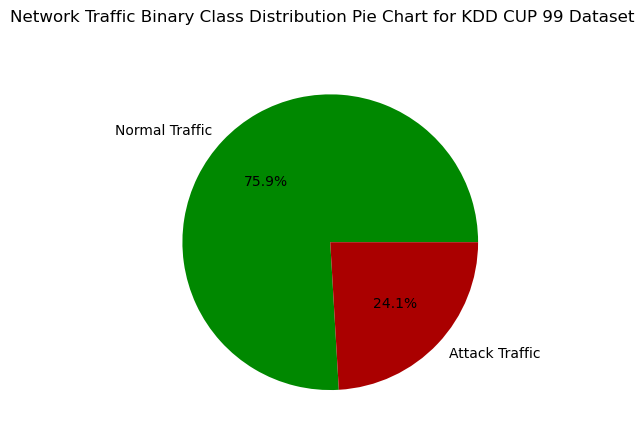

In [42]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_kdd_cup_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for KDD CUP 99 Dataset')

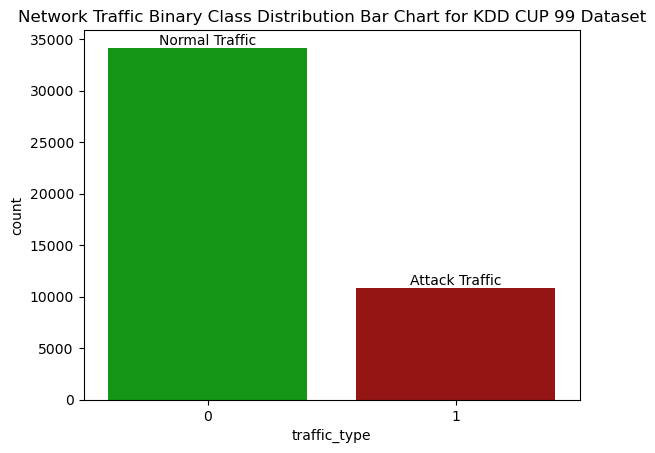

In [43]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_kdd_cup_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart for KDD CUP 99 Dataset')

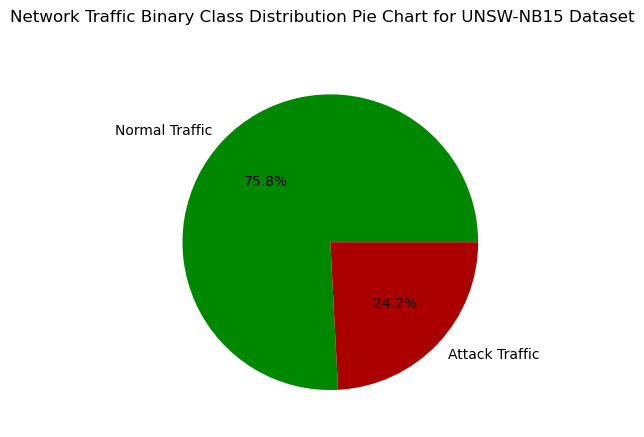

In [44]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_unsw_nb15_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for UNSW-NB15 Dataset')

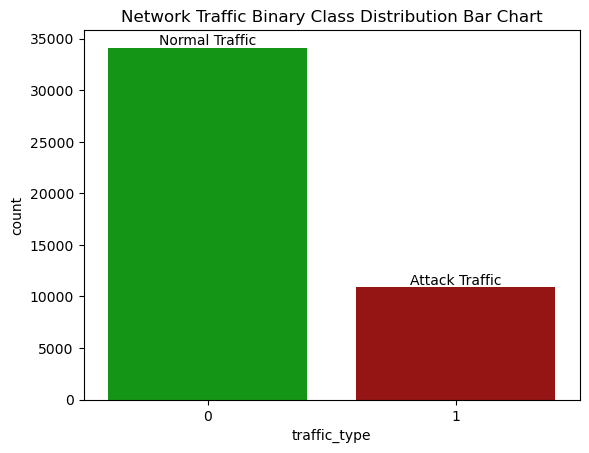

In [45]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_unsw_nb15_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart')

In [46]:
eda_kdd_cup_df = eda_kdd_cup_df.drop([target_variable], axis=1)
eda_unsw_nb15_df = eda_unsw_nb15_df.drop([target_variable], axis=1)

In [47]:
eda_kdd_cup_99_categorical_features, eda_kdd_cup_99_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_kdd_cup_df)

In [48]:
print("KDD CUP 99 dataset categorical variables count is {}".format(len(eda_kdd_cup_99_categorical_features)))
print("KDD CUP 99 dataset continuous variables count is {}".format(len(eda_kdd_cup_99_continuous_features)))

KDD CUP 99 dataset categorical variables count is 16
KDD CUP 99 dataset continuous variables count is 25


In [49]:
eda_unsw_nb15_categorical_features, eda_unsw_nb15_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_unsw_nb15_df)

In [50]:
print("UNSW-NB 15 dataset categorical variables count is {}".format(len(eda_unsw_nb15_categorical_features)))
print("UNSW-NB 15 dataset continuous variables count is {}".format(len(eda_unsw_nb15_continuous_features)))

UNSW-NB 15 dataset categorical variables count is 10
UNSW-NB 15 dataset continuous variables count is 33








Summary for SERVICE feature value counts


http           21646
ecr_i           7850
private         5492
smtp            3342
domain_u        2117
other           2018
ftp_data        1340
urp_i            193
finger           175
eco_i            157
ntp_u            132
ftp              125
auth              96
telnet            96
pop_3             43
time              16
IRC               15
whois              8
gopher             7
nnsp               6
name               6
exec               6
discard            6
ssh                5
pop_2              5
ldap               5
http_443           5
netbios_dgm        4
X11                4
uucp               4
sunrpc             4
daytime            4
csnet_ns           4
iso_tsap           4
hostnames          4
link               4
netbios_ns         3
uucp_path          3
netbios_ssn        3
klogin             3
shell              3
domain             3
supdup             3
kshell             3
imap4              3
mtp   

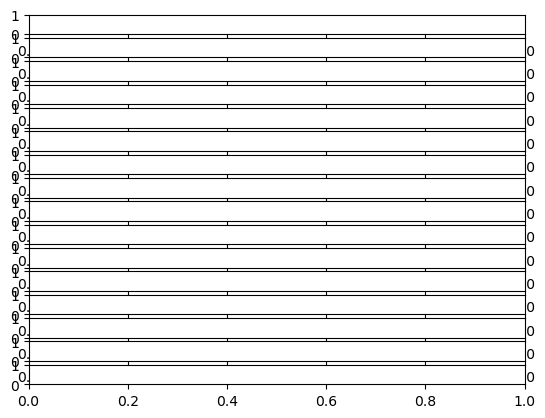

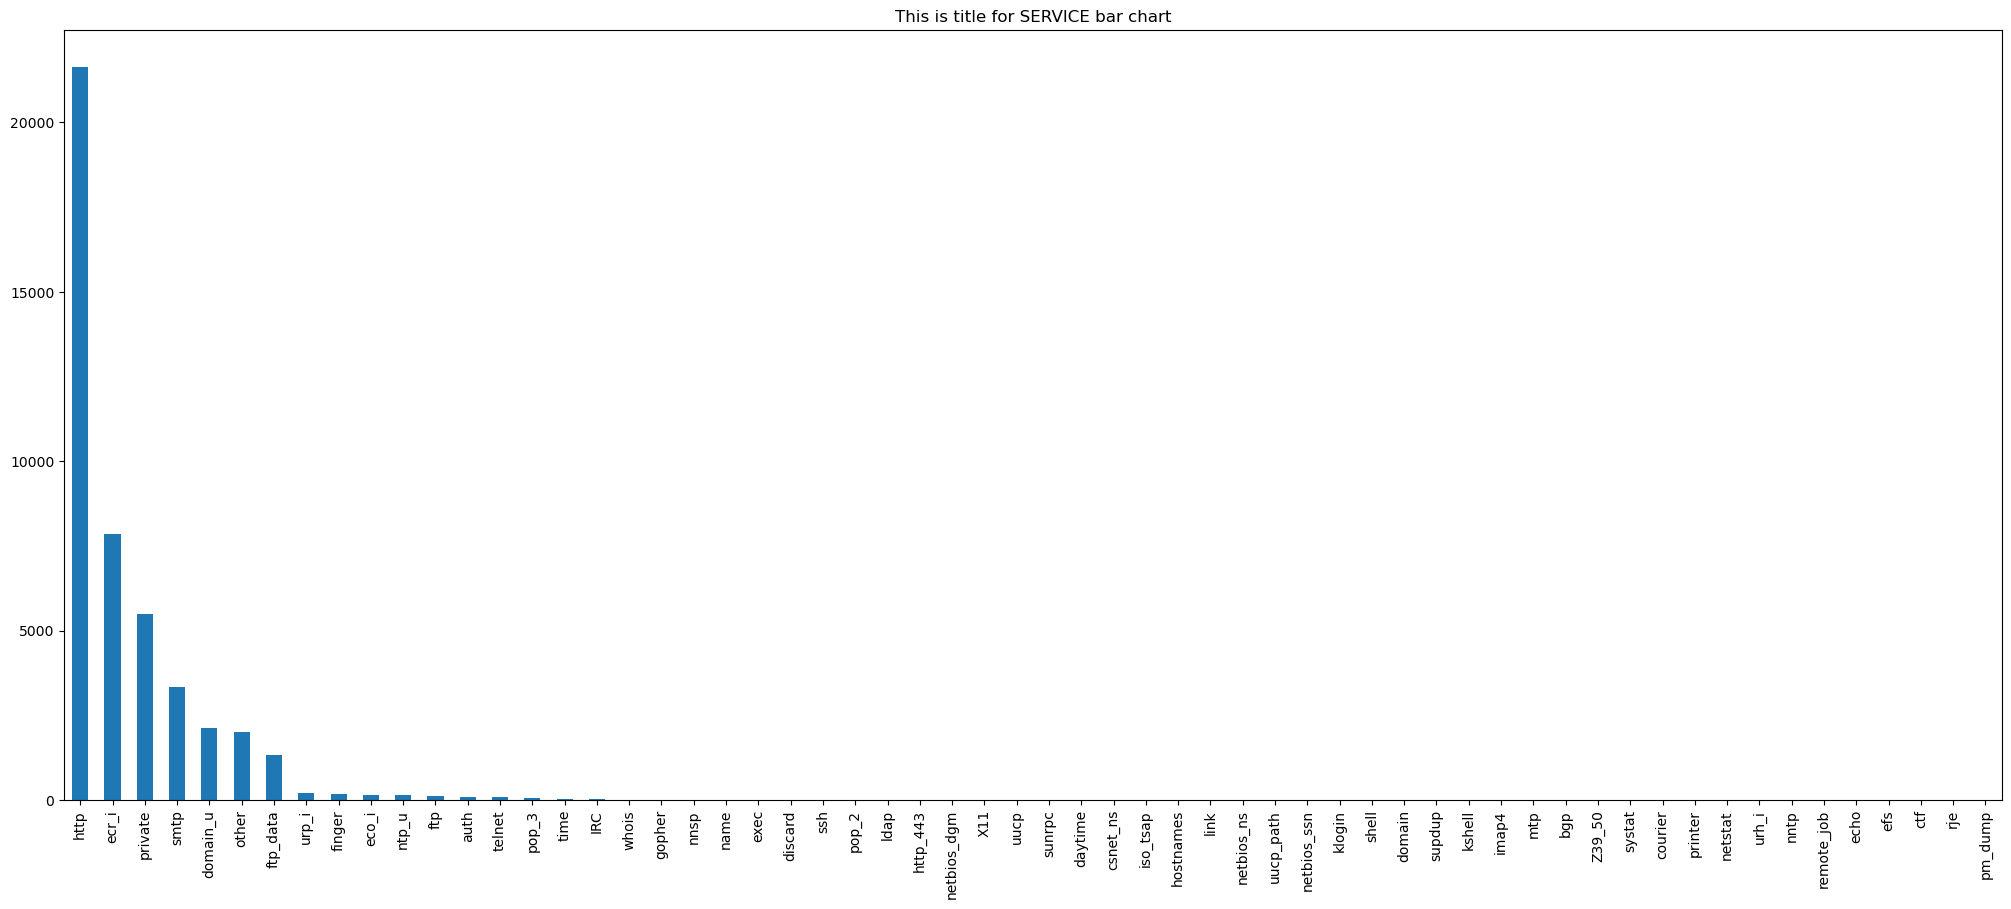

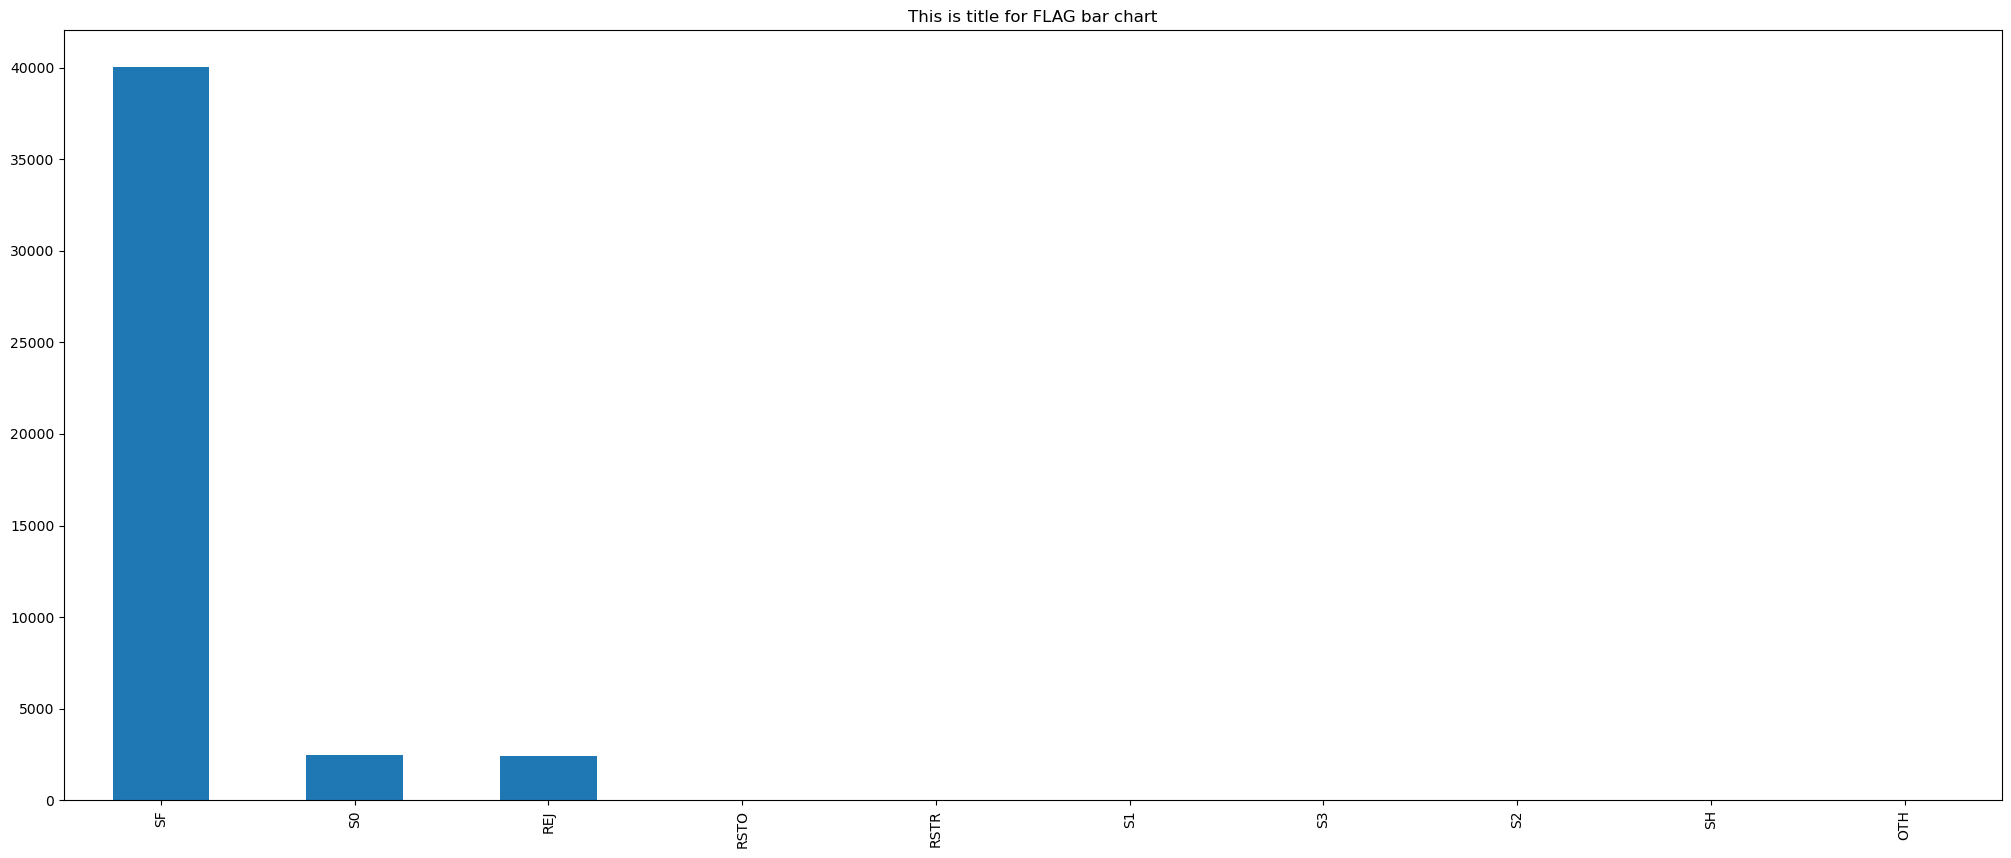

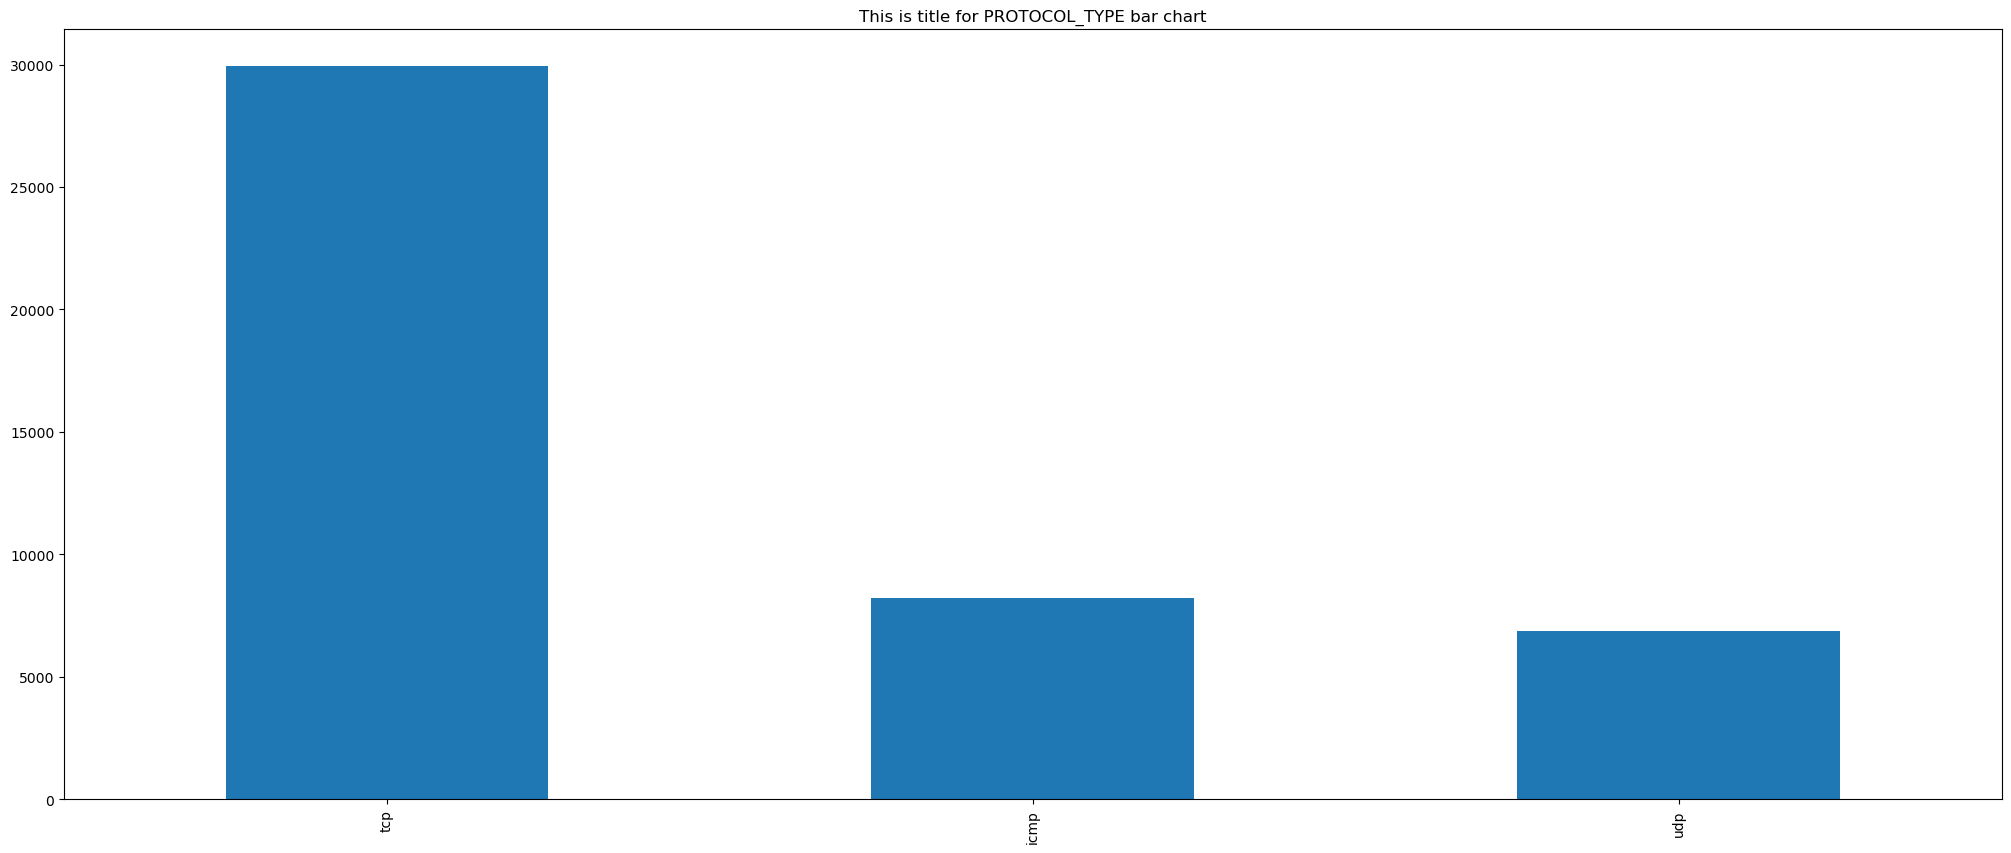

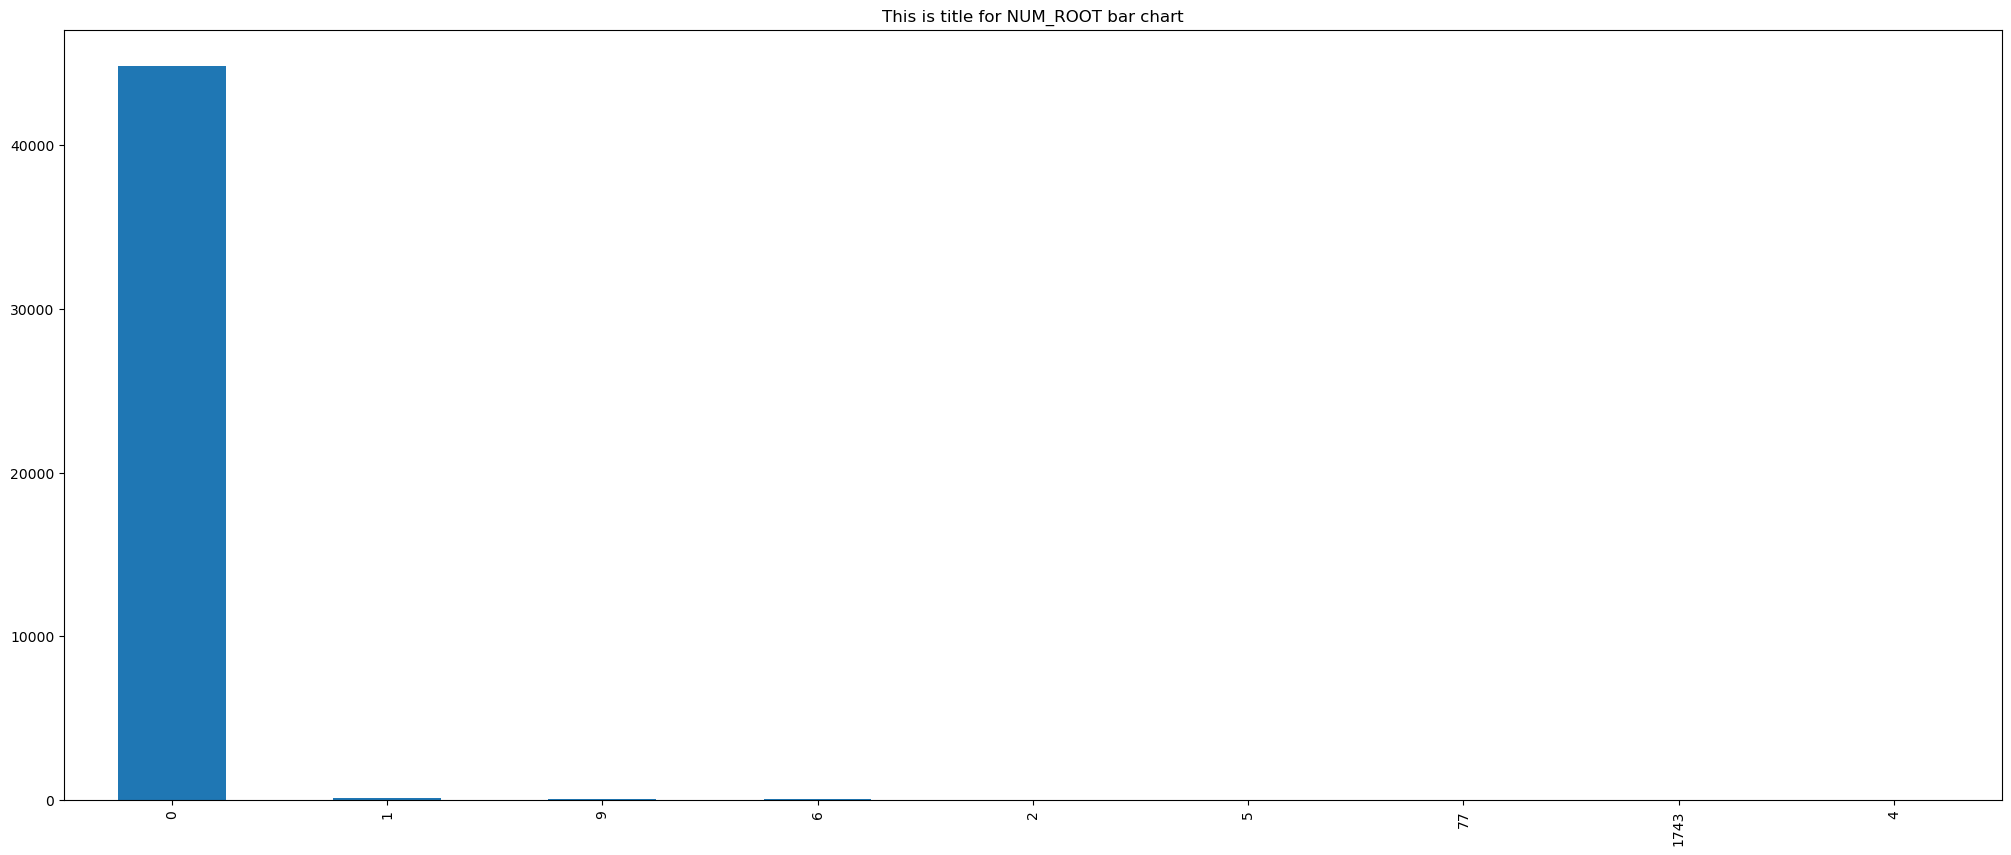

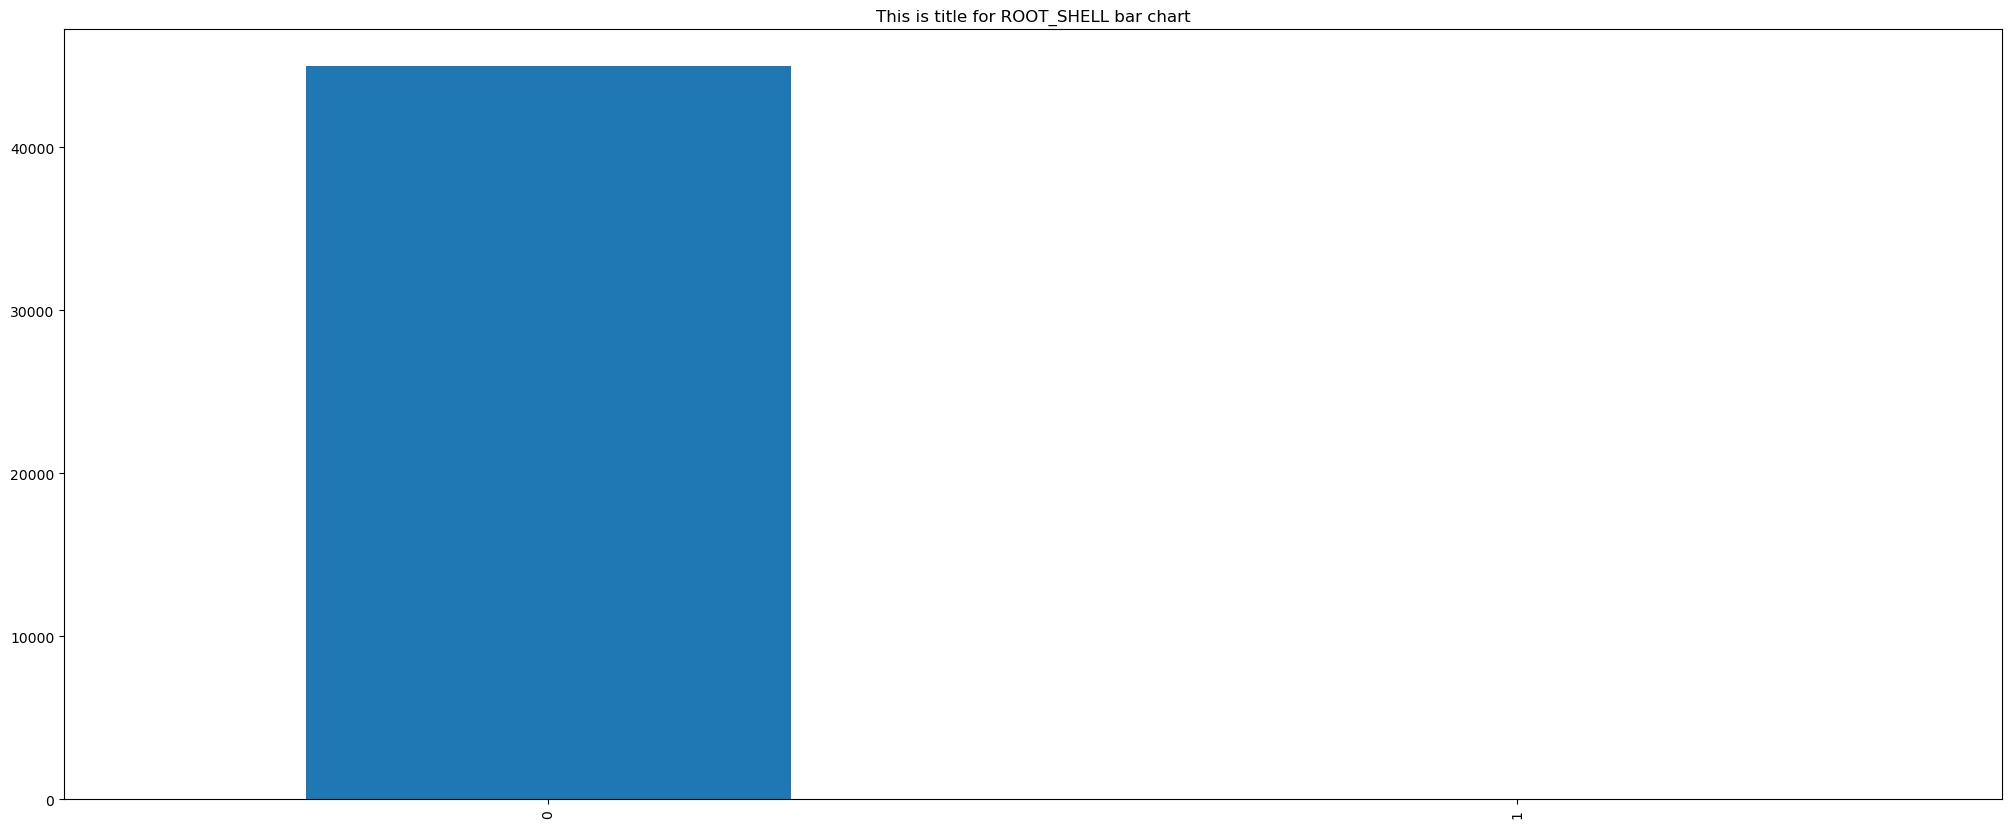

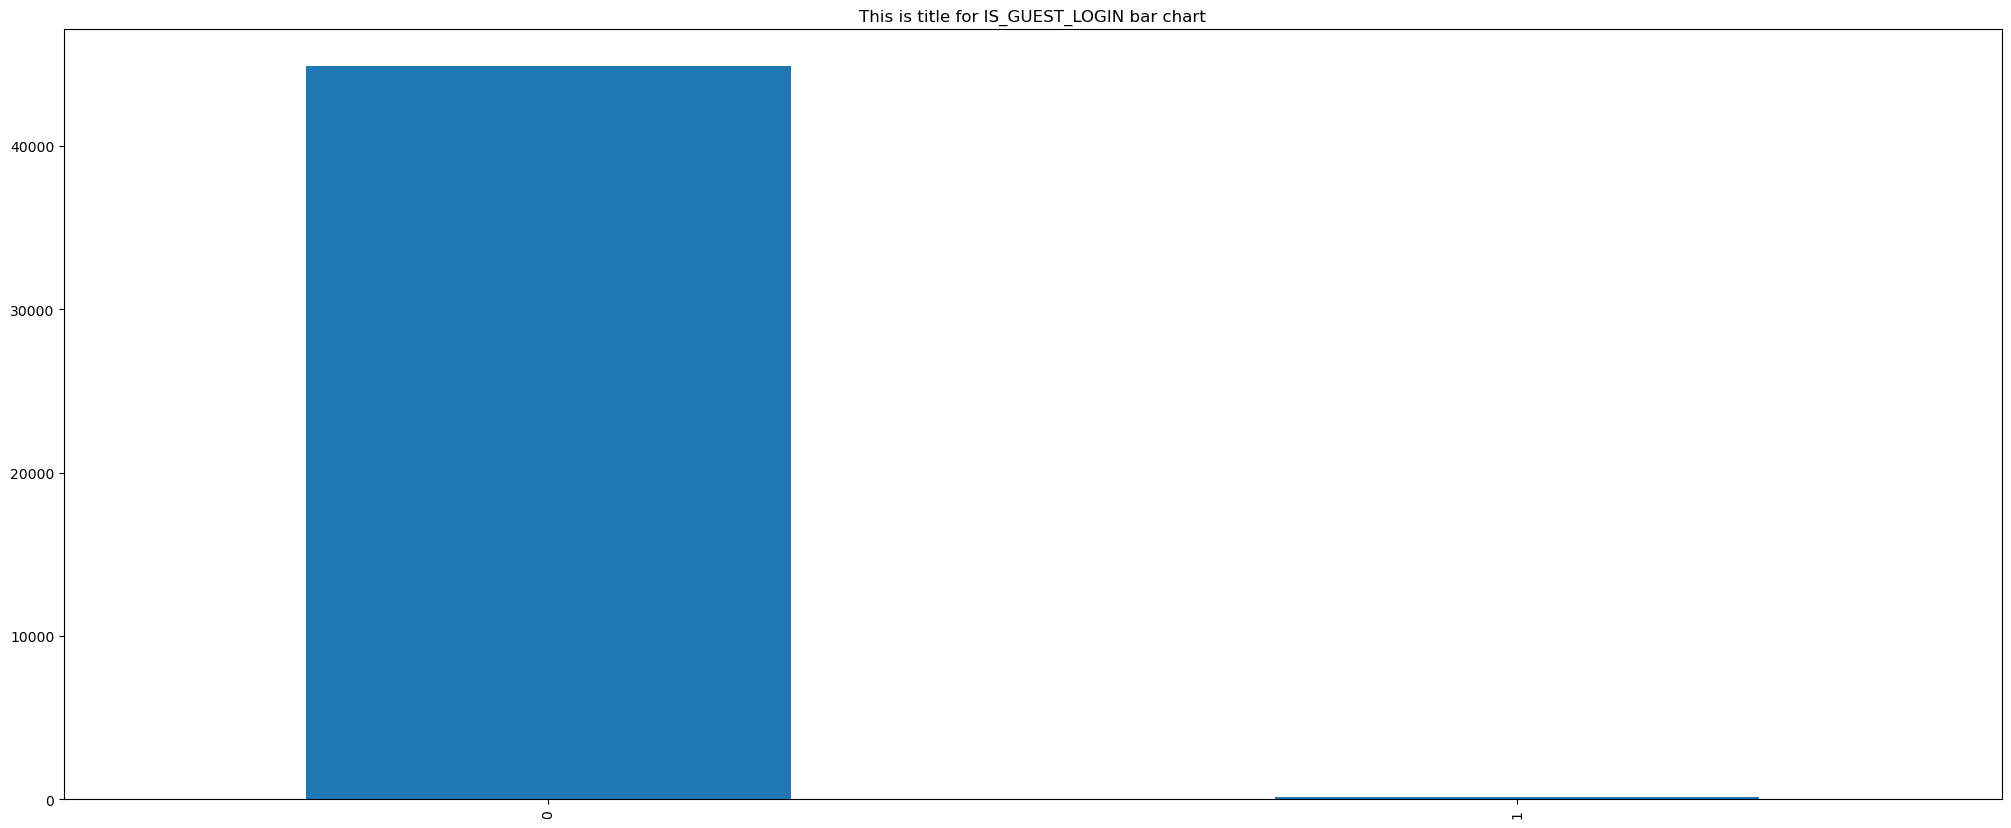

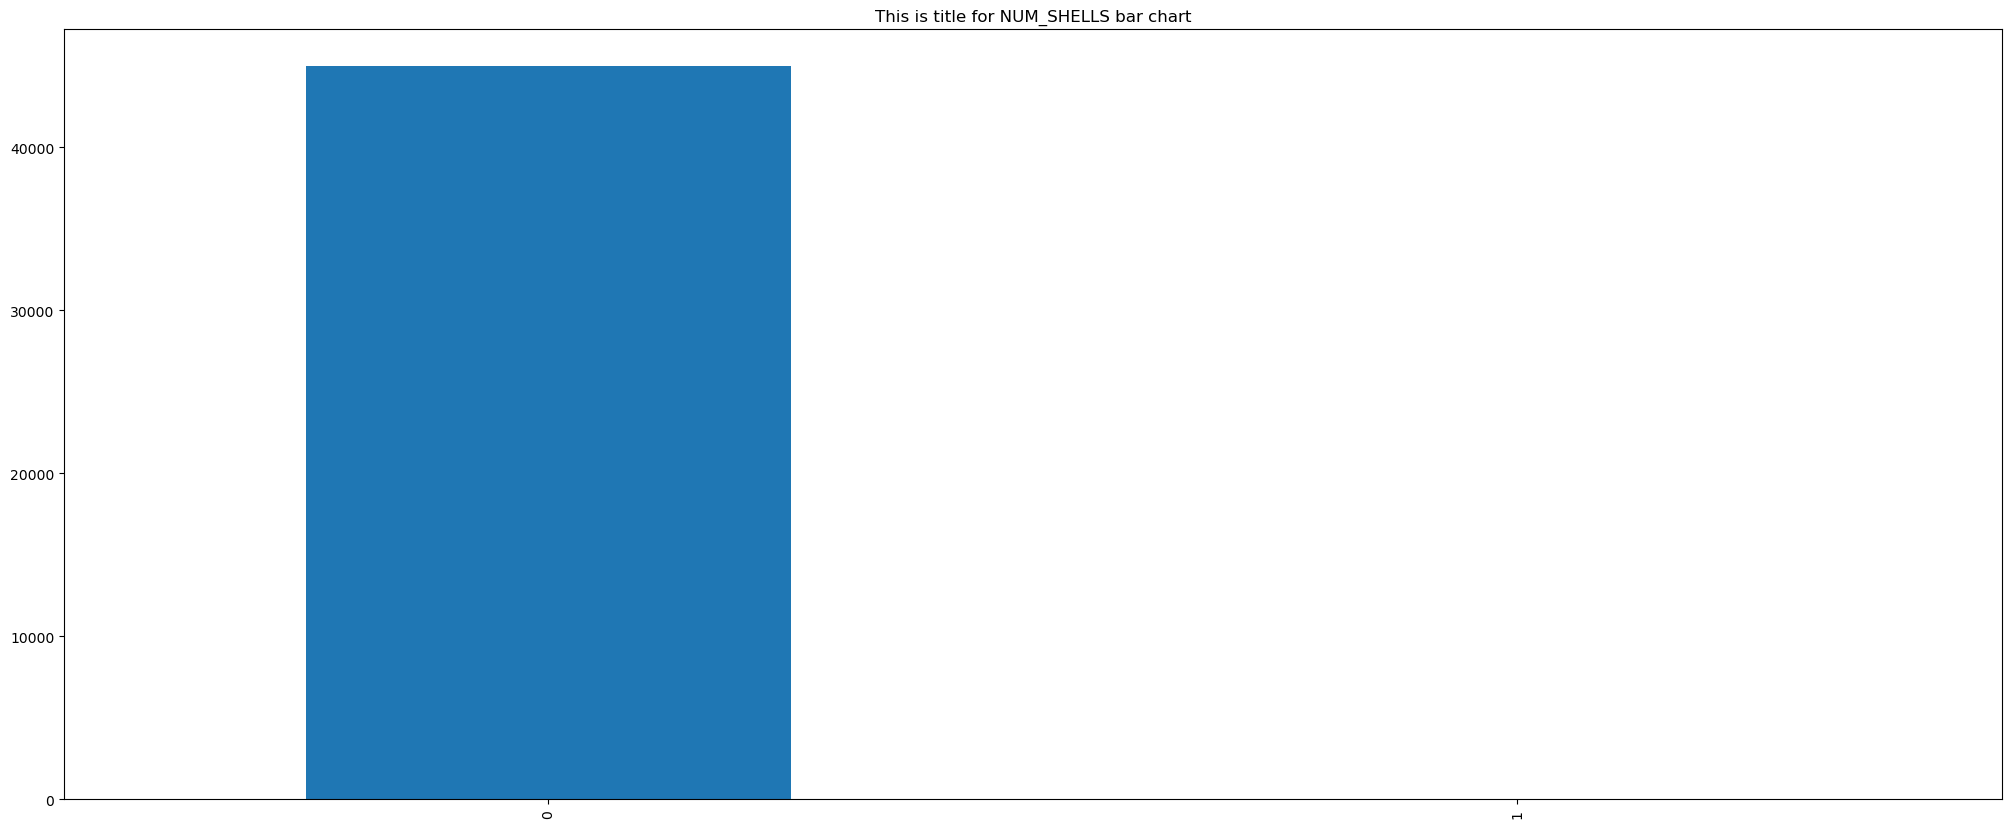

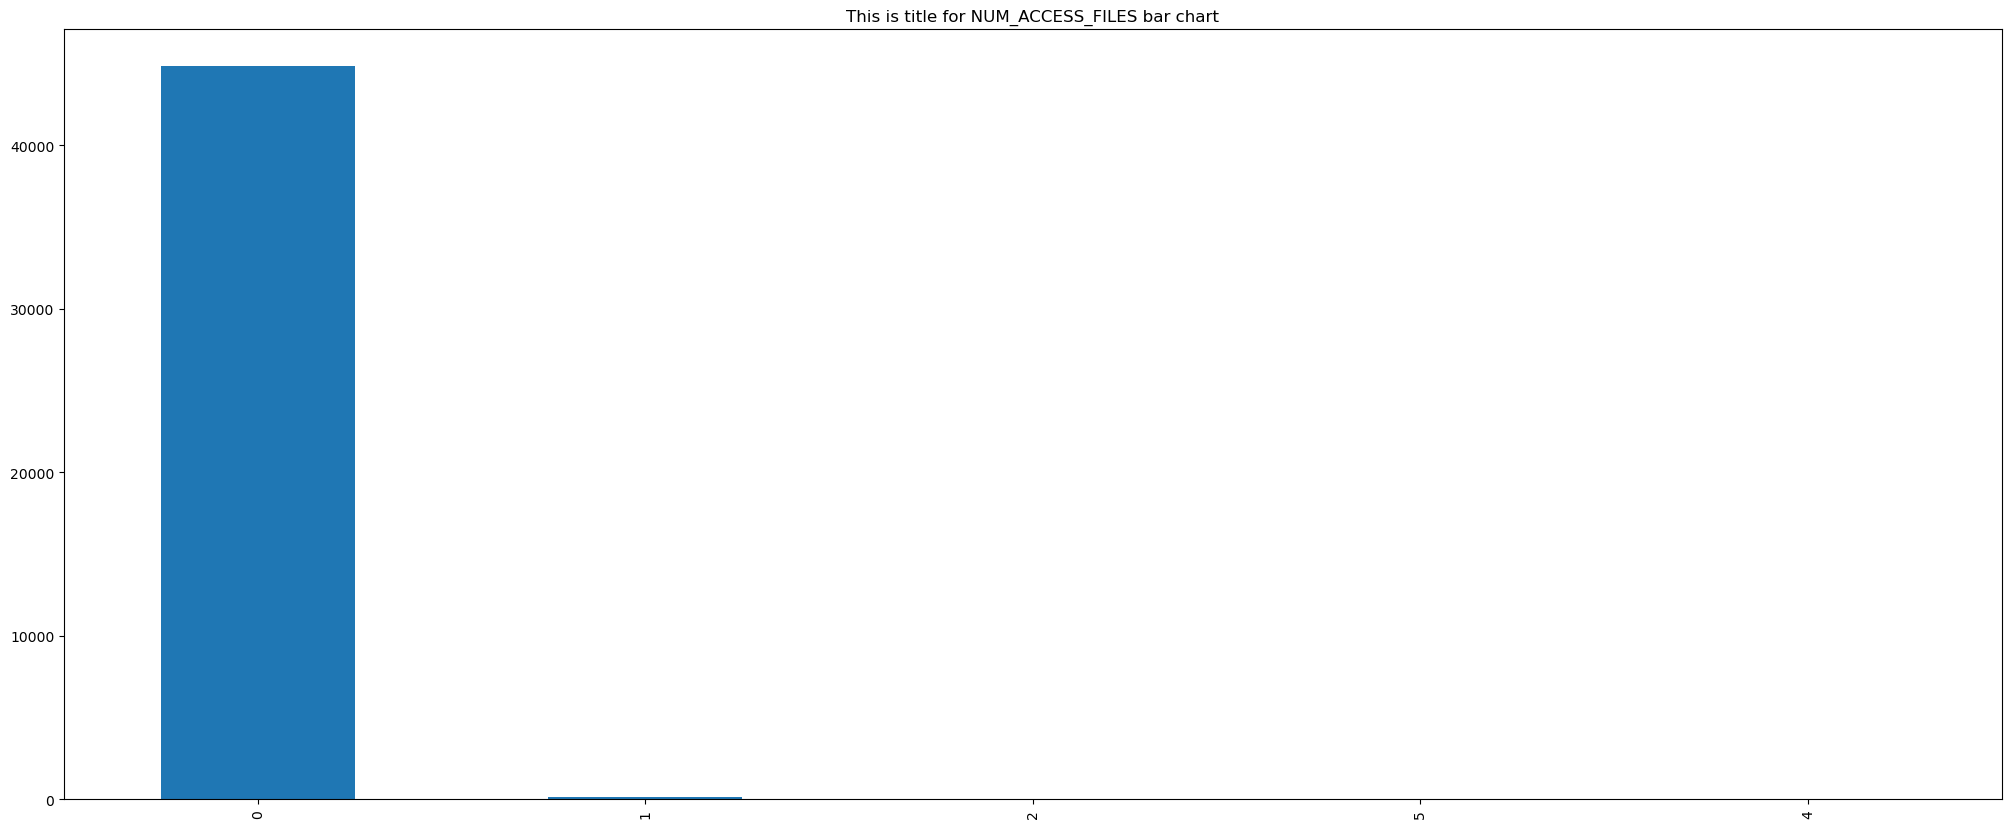

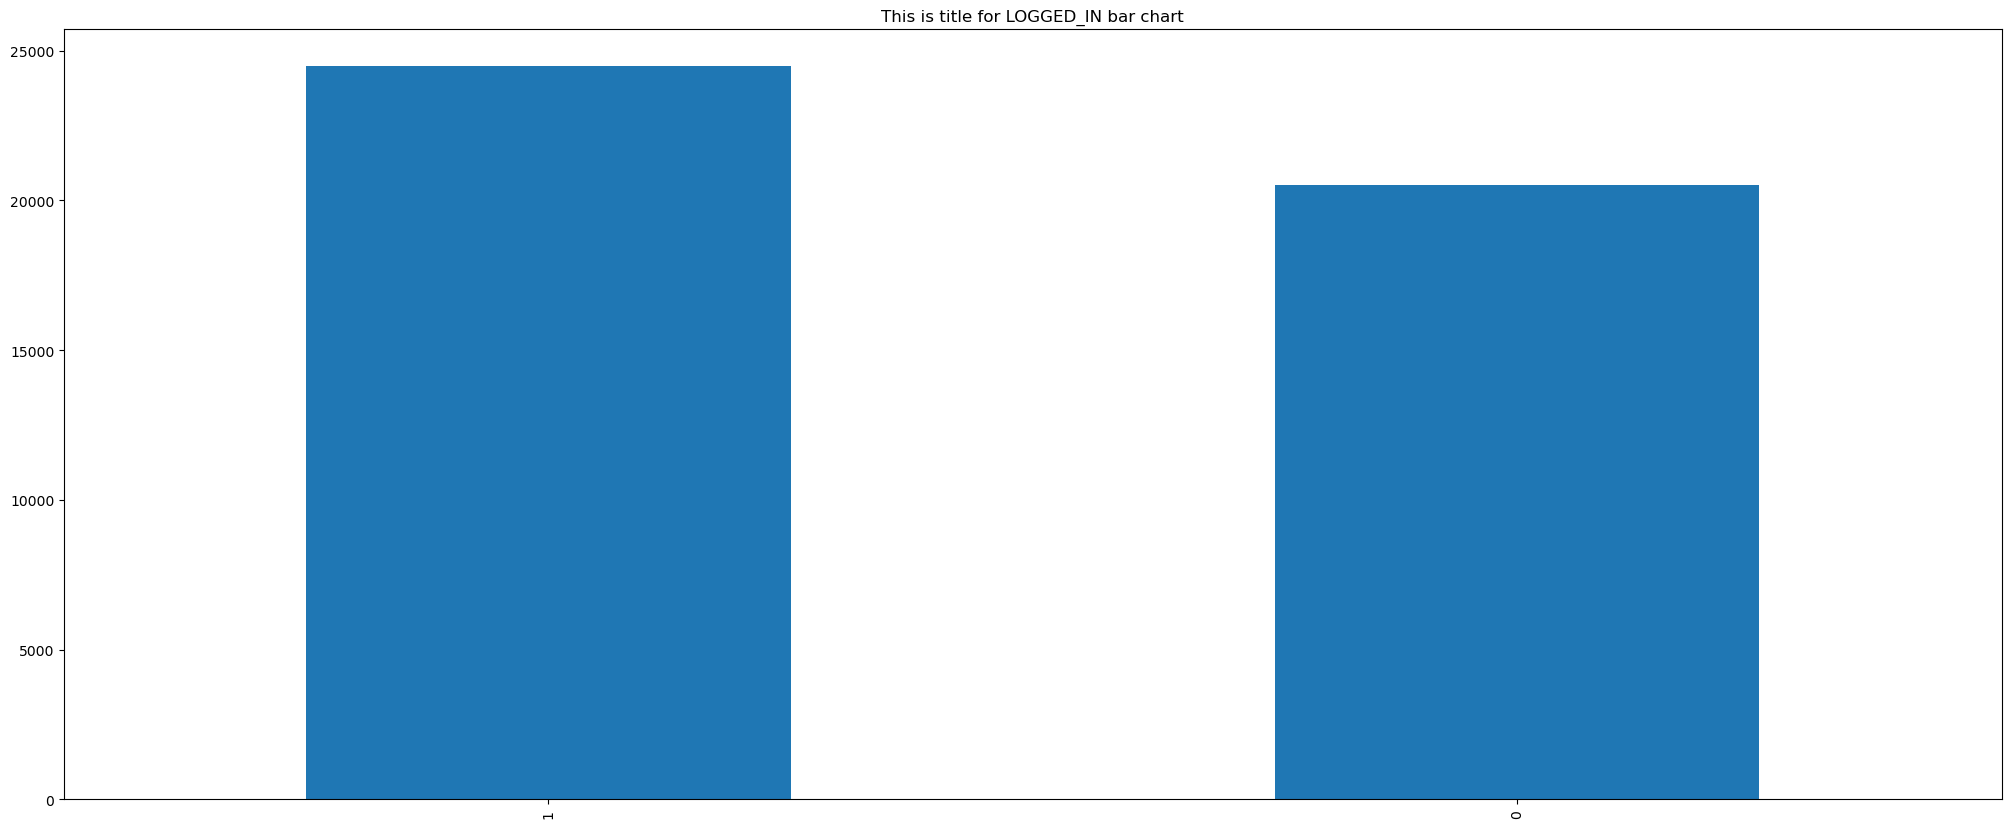

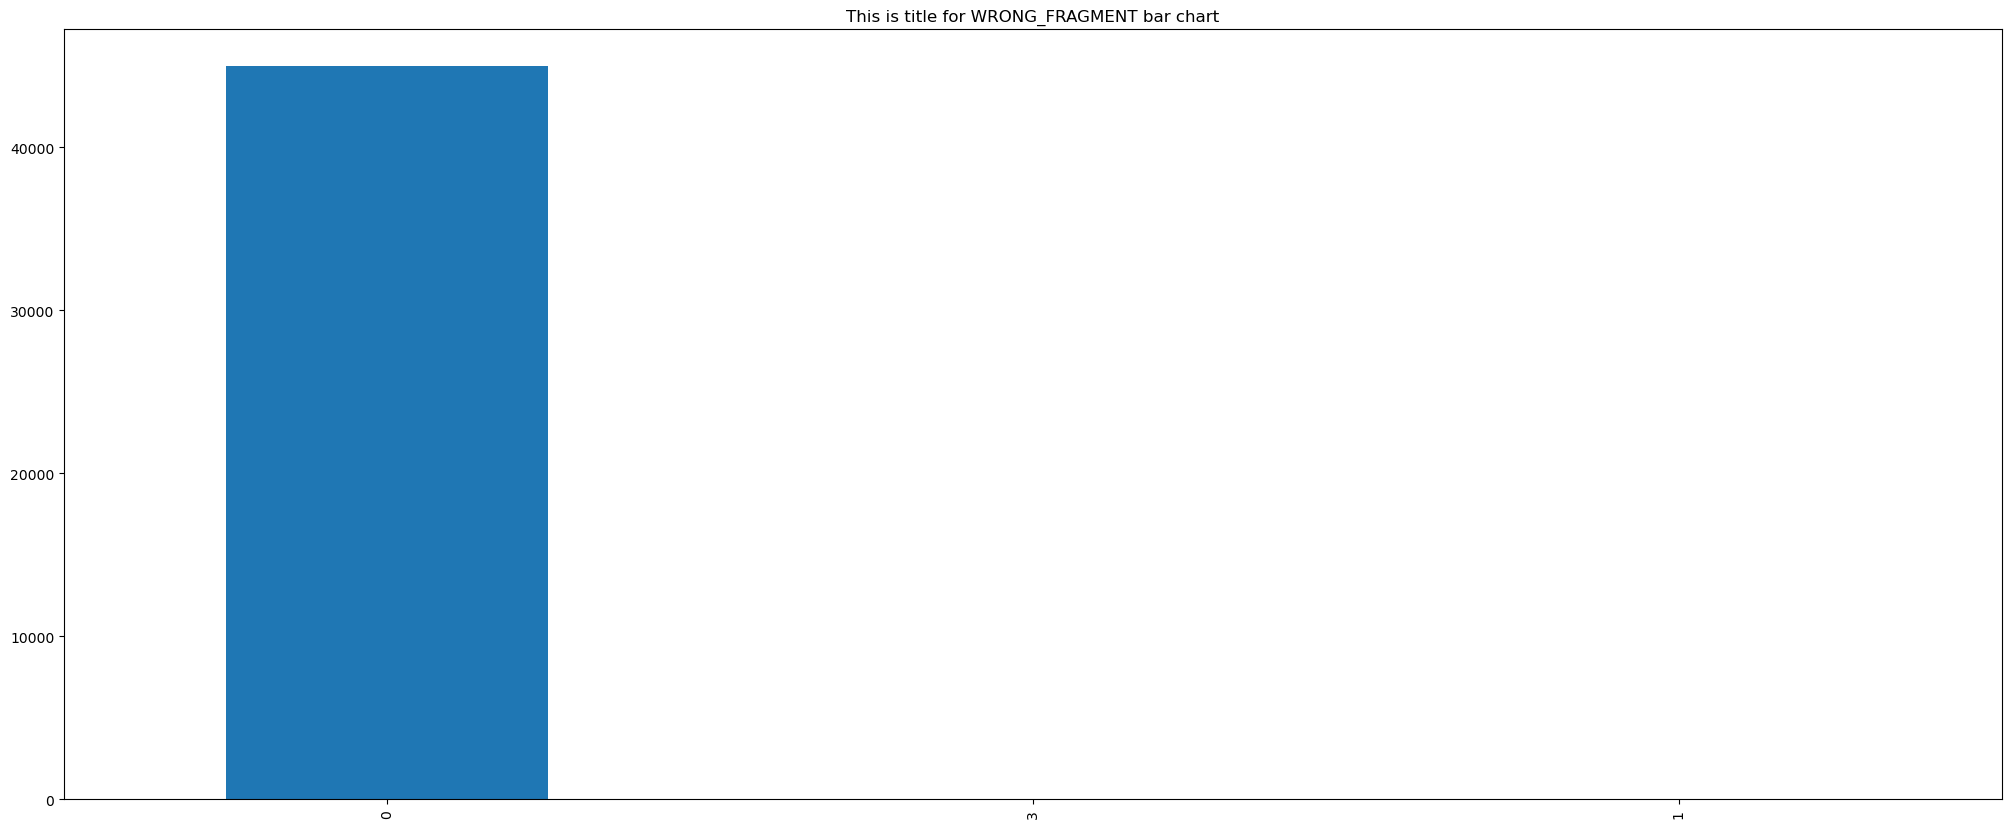

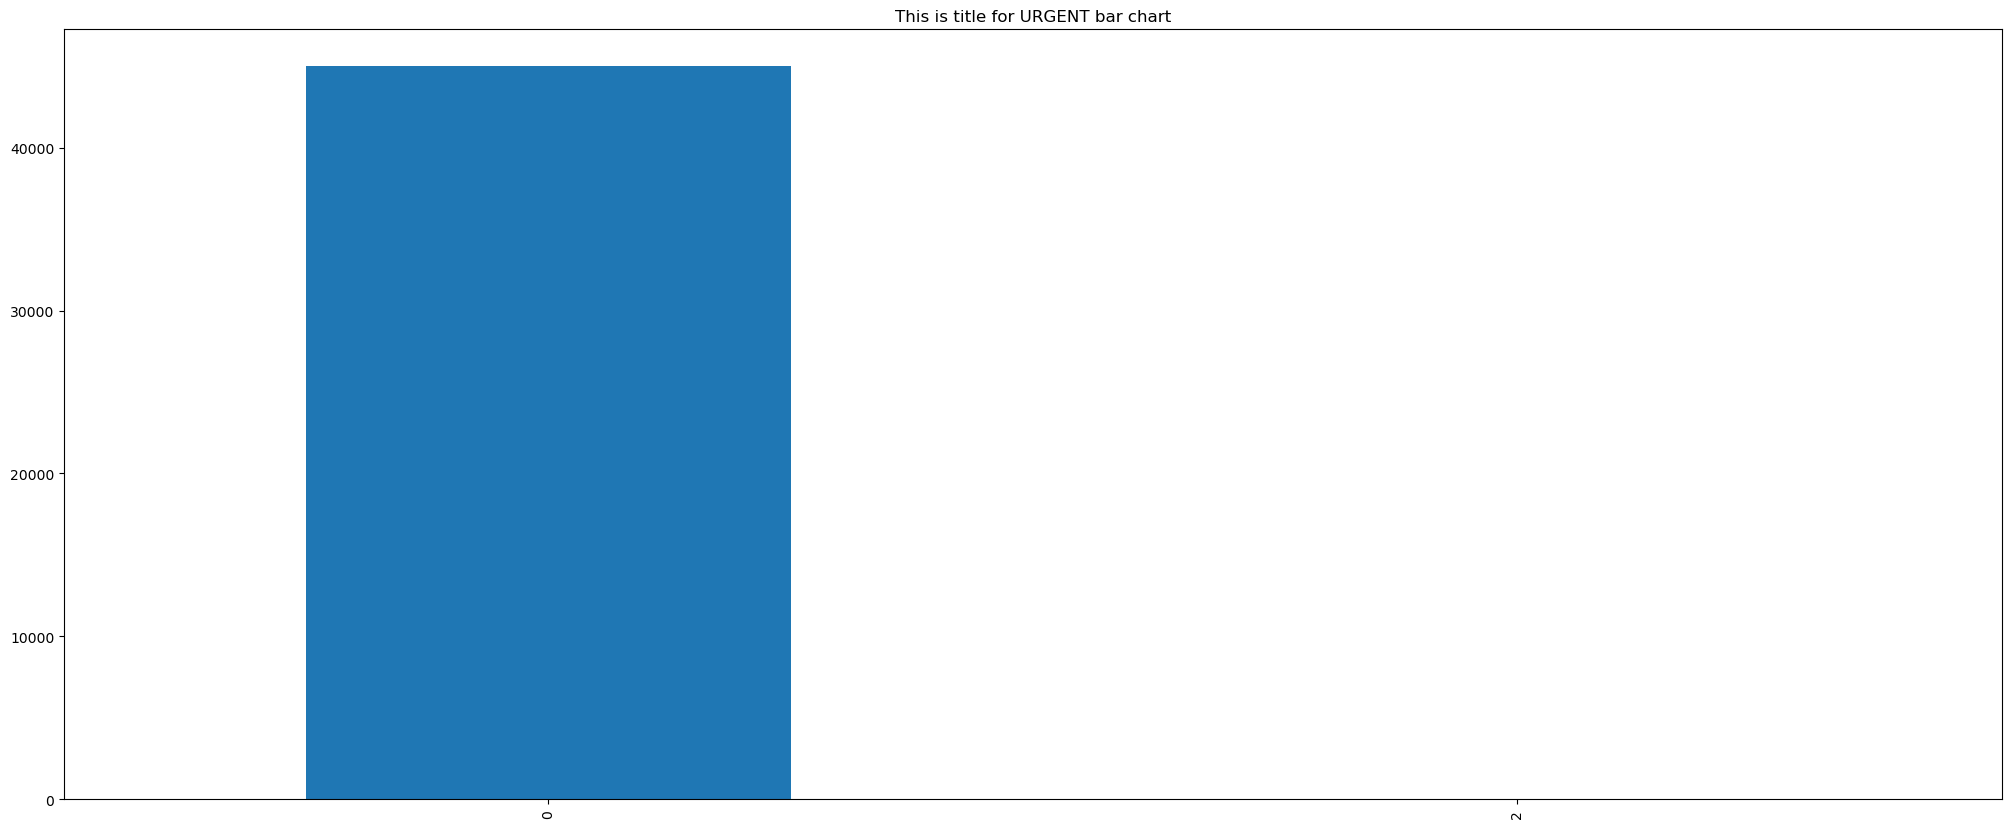

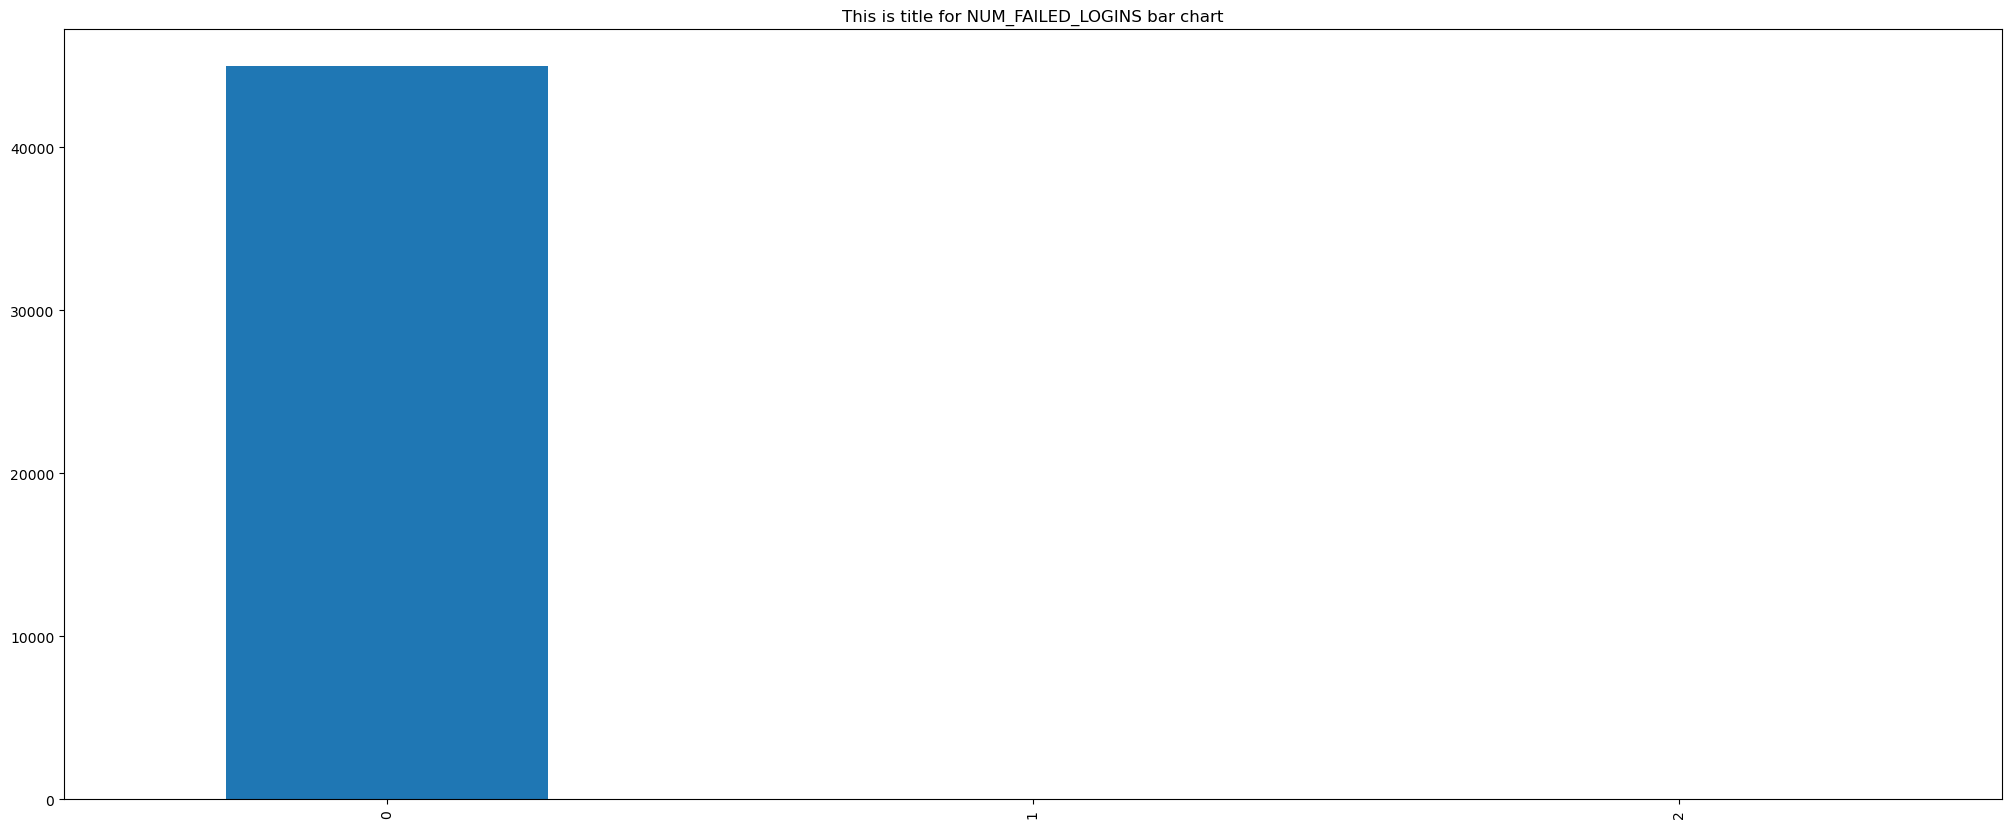

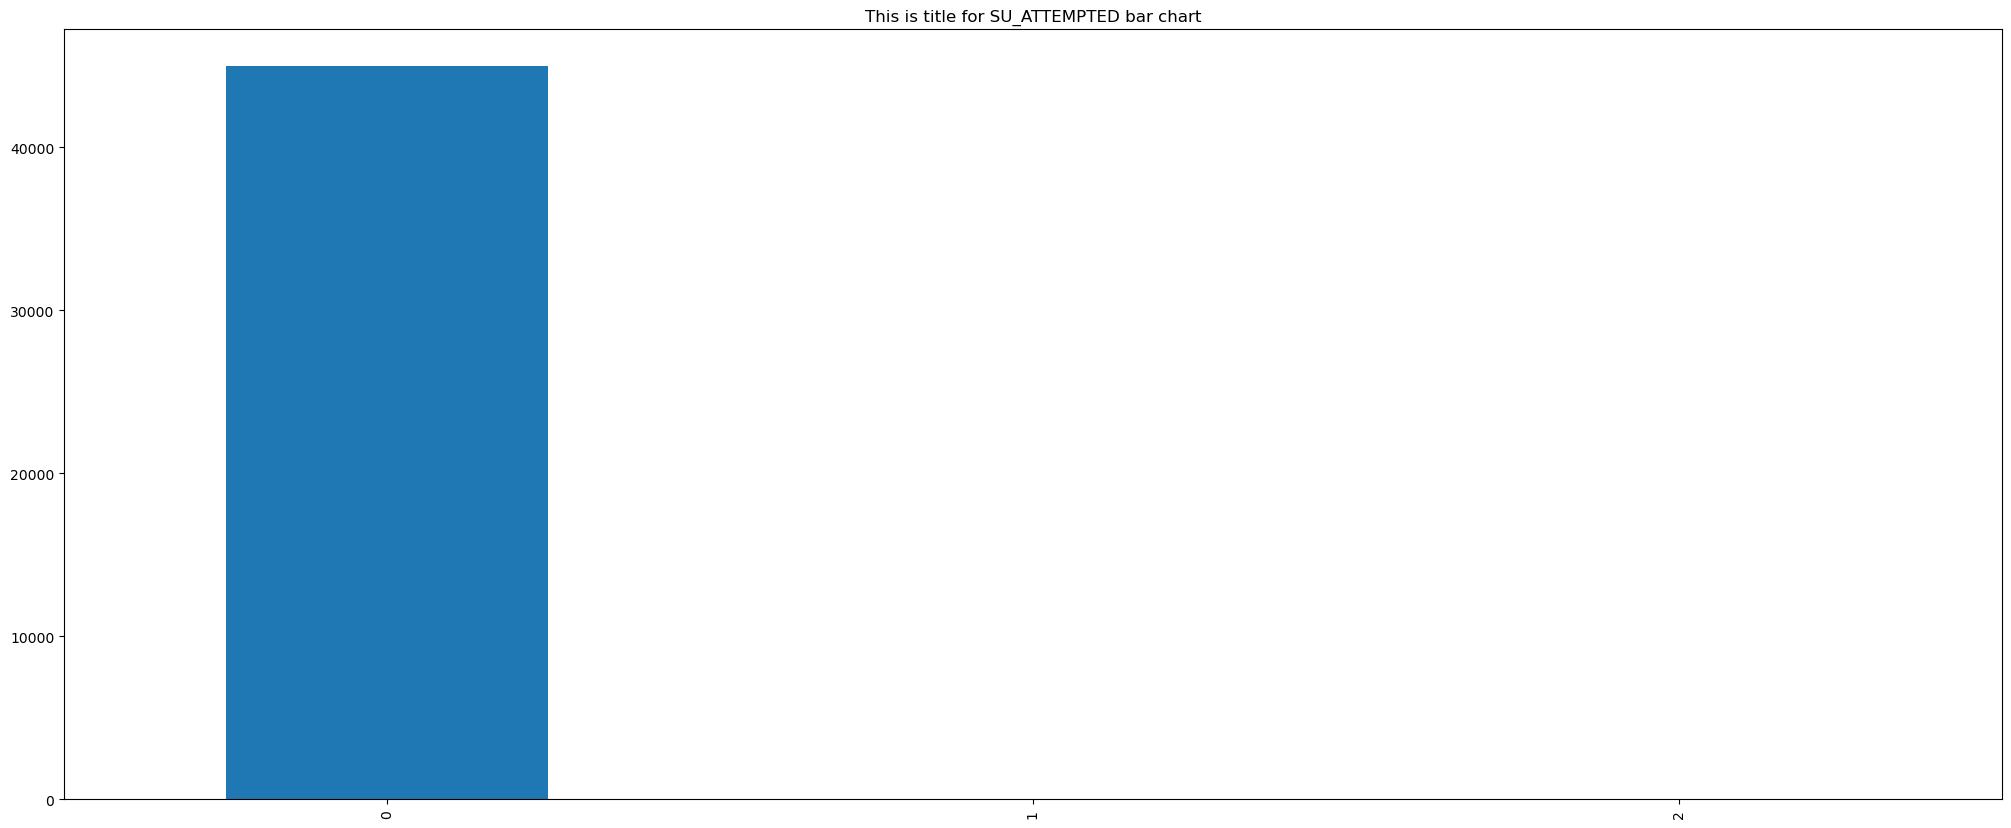

In [51]:
show_bar_plots_for_all_categorical_plots(eda_kdd_cup_df, eda_kdd_cup_99_categorical_features)







Summary for SERVICE feature value counts


-           28570
dns          7785
http         4562
ftp-data     1396
smtp         1109
ftp           929
ssh           538
pop3           93
dhcp            7
ssl             5
snmp            4
radius          1
irc             1
Name: service, dtype: int64






Summary for PROTO feature value counts


tcp            28245
udp            12803
arp             1404
unas            1031
ospf             254
sctp              91
any               24
swipe             22
gre               22
rsvp              19
mobile            16
ipv6-route        16
sep               15
scps              15
srp               15
sun-nd            14
iso-tp4           14
igmp              14
micp              14
pim               14
ipv6              14
vrrp              14
idrp              14
tp++              13
isis              13
ipv6-opts         12
cpnx              12
ip                12
ipv6-frag         12
sccopmce          12
cphb        

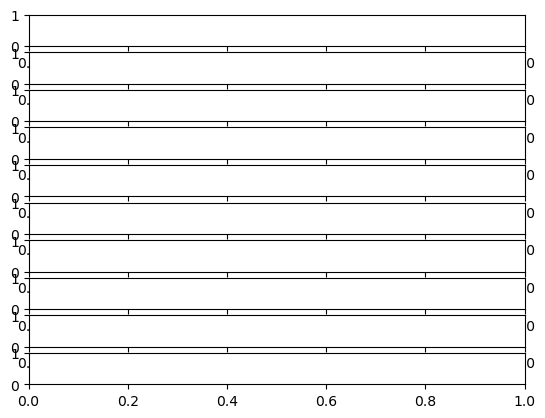

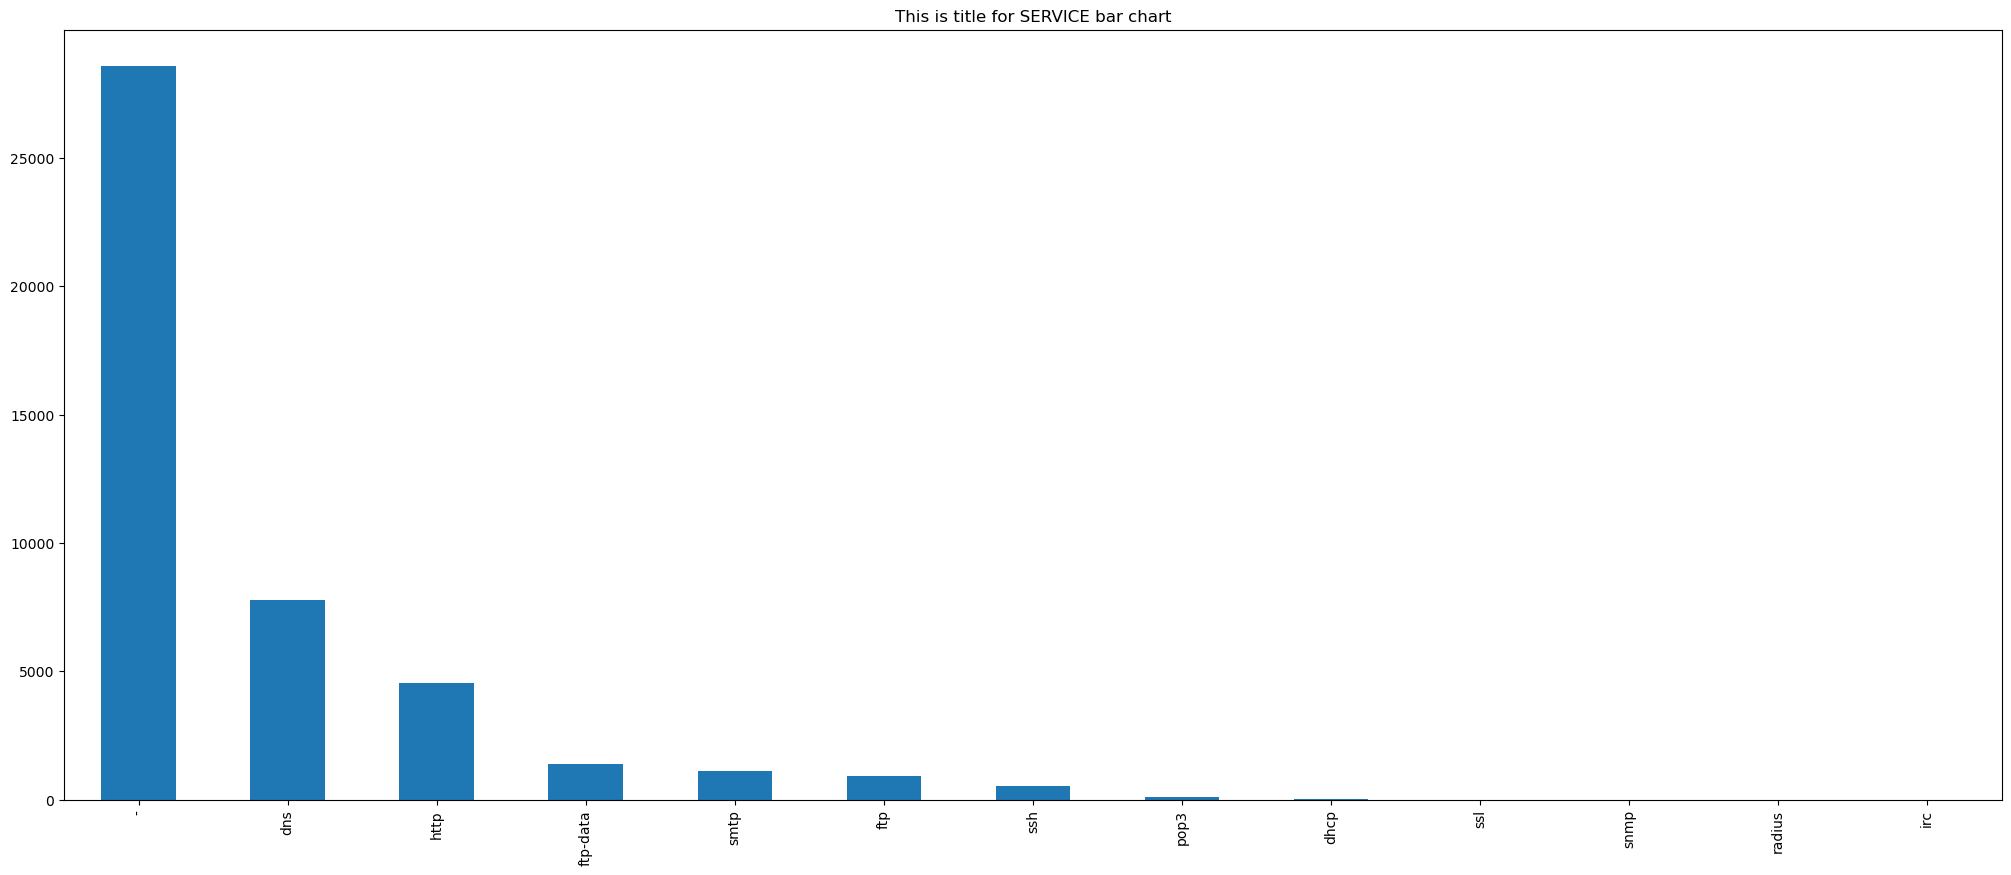

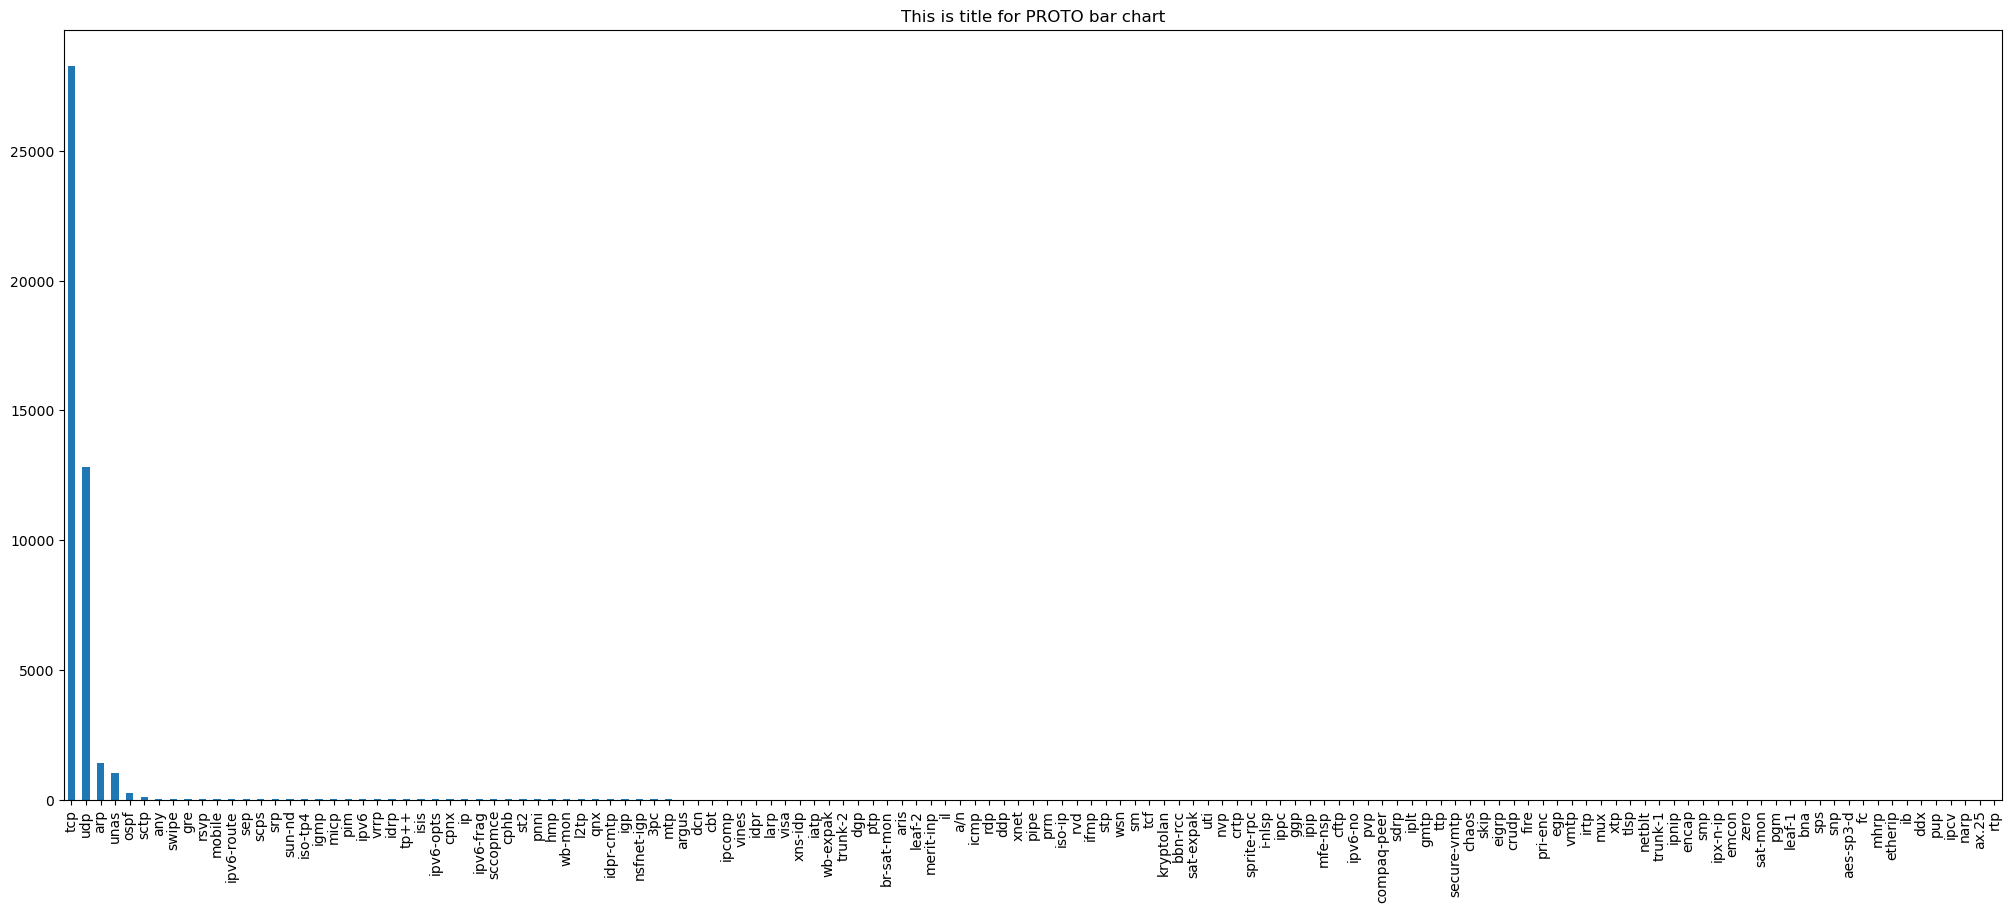

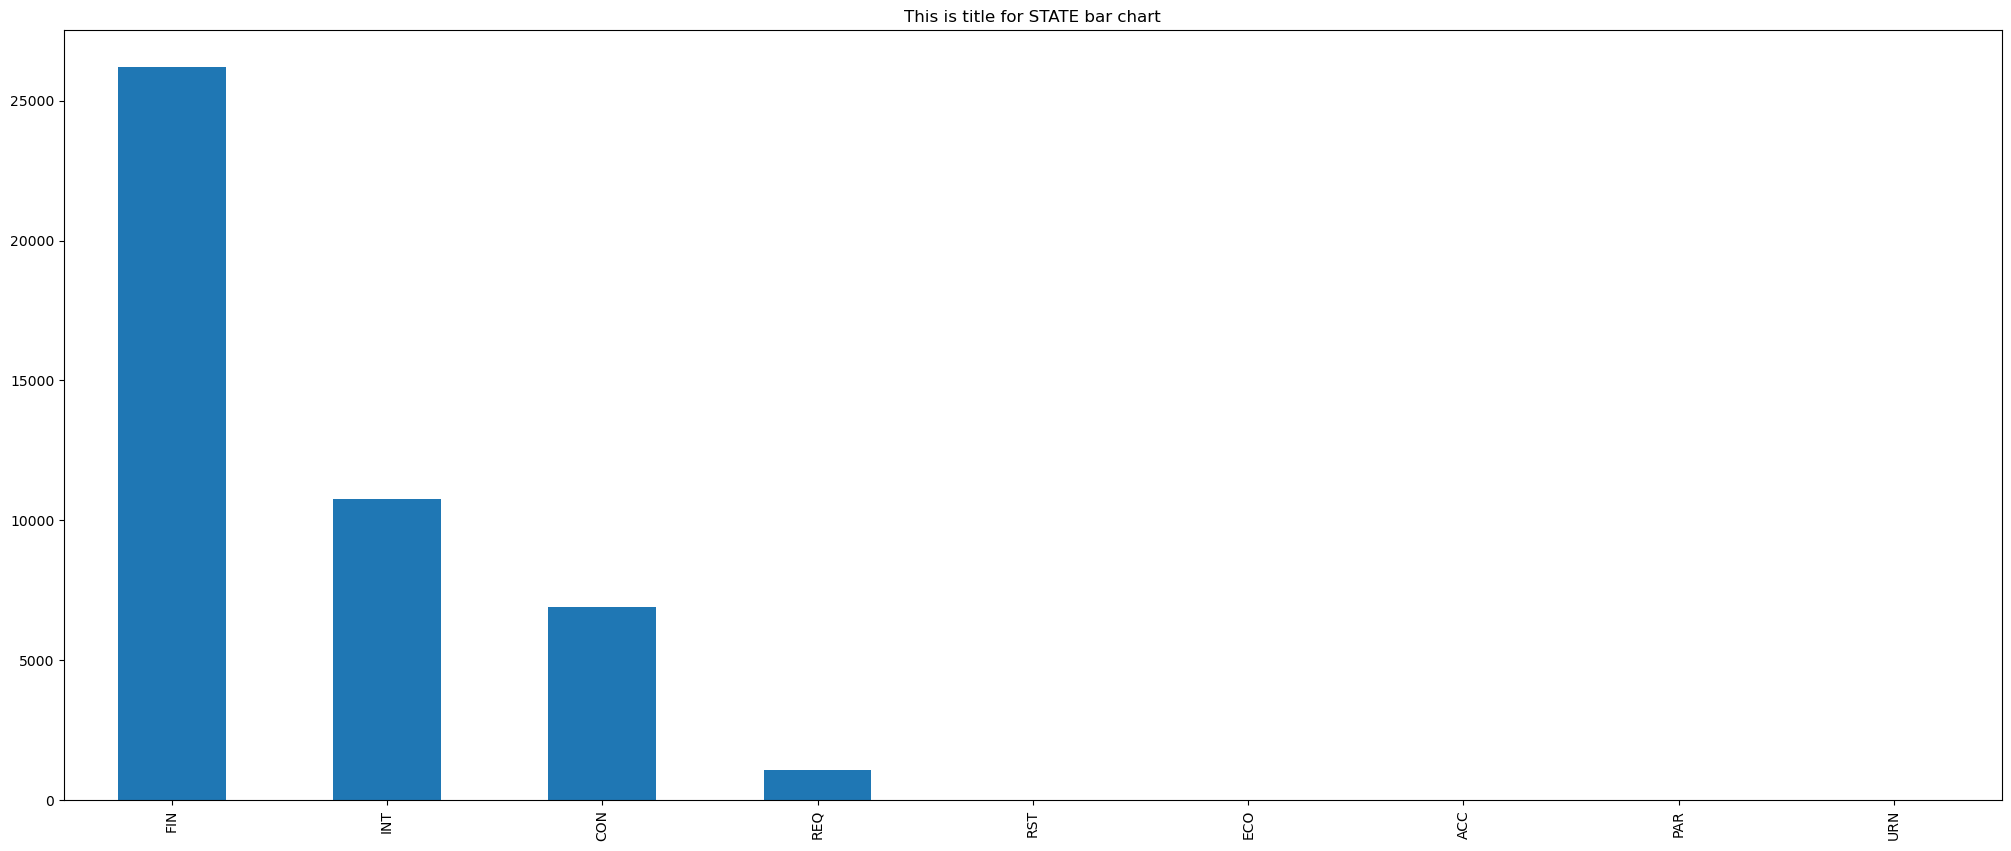

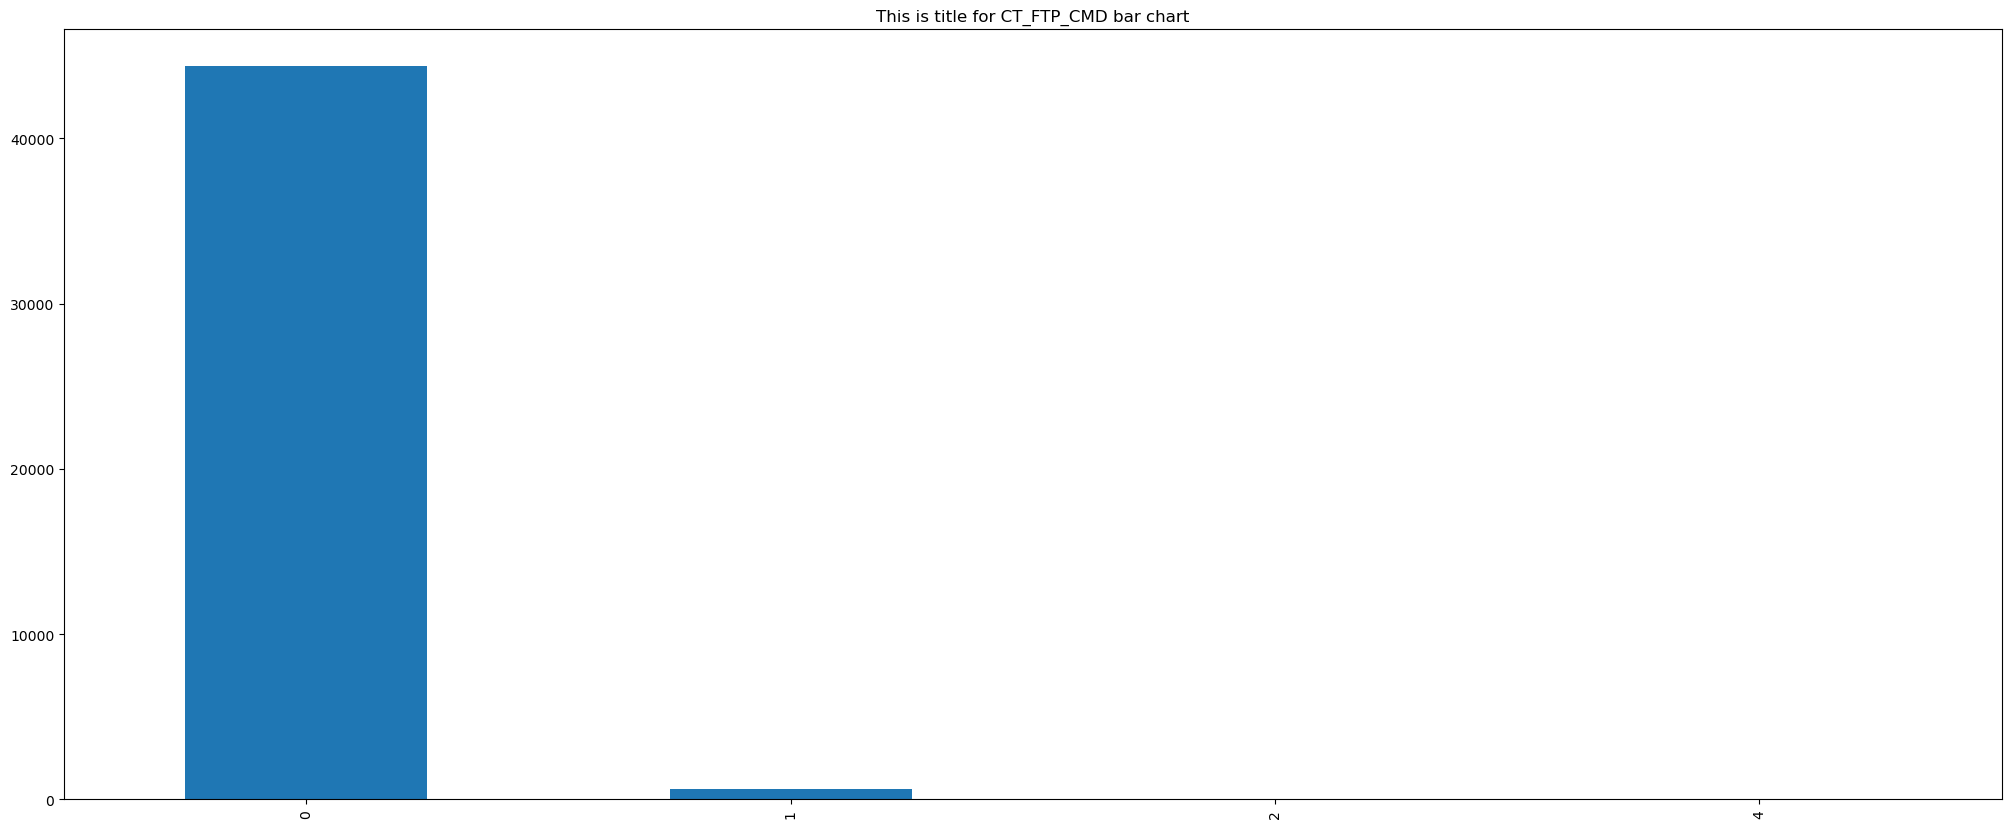

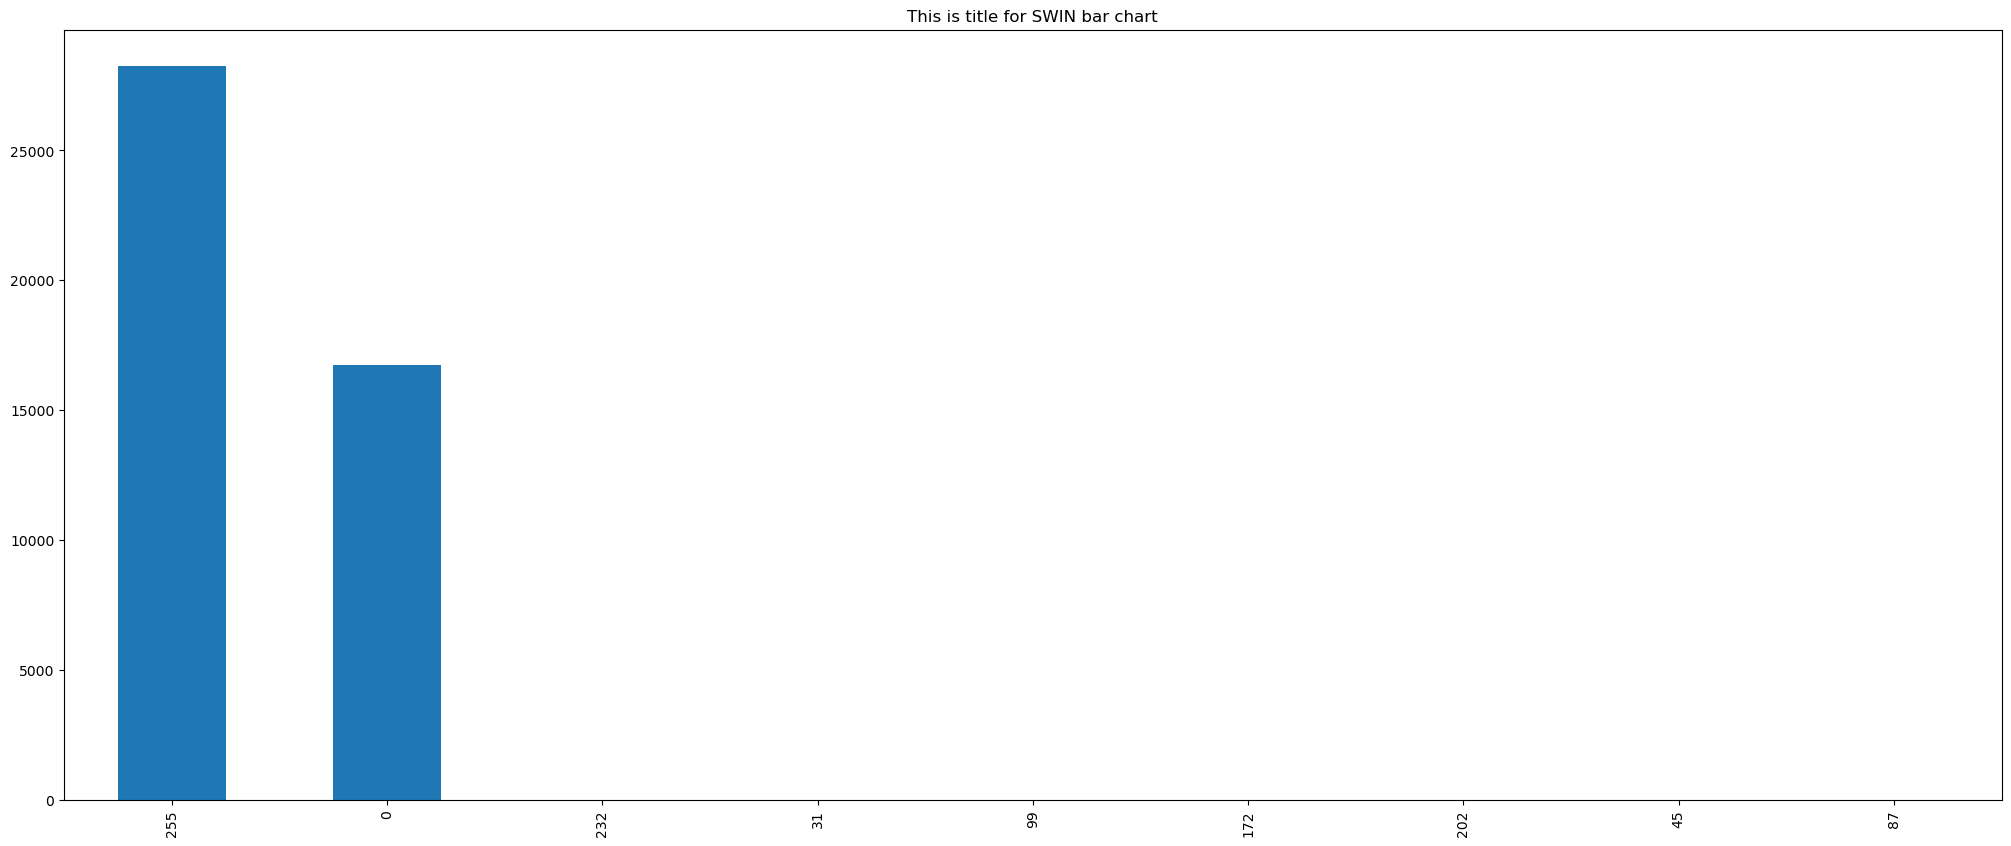

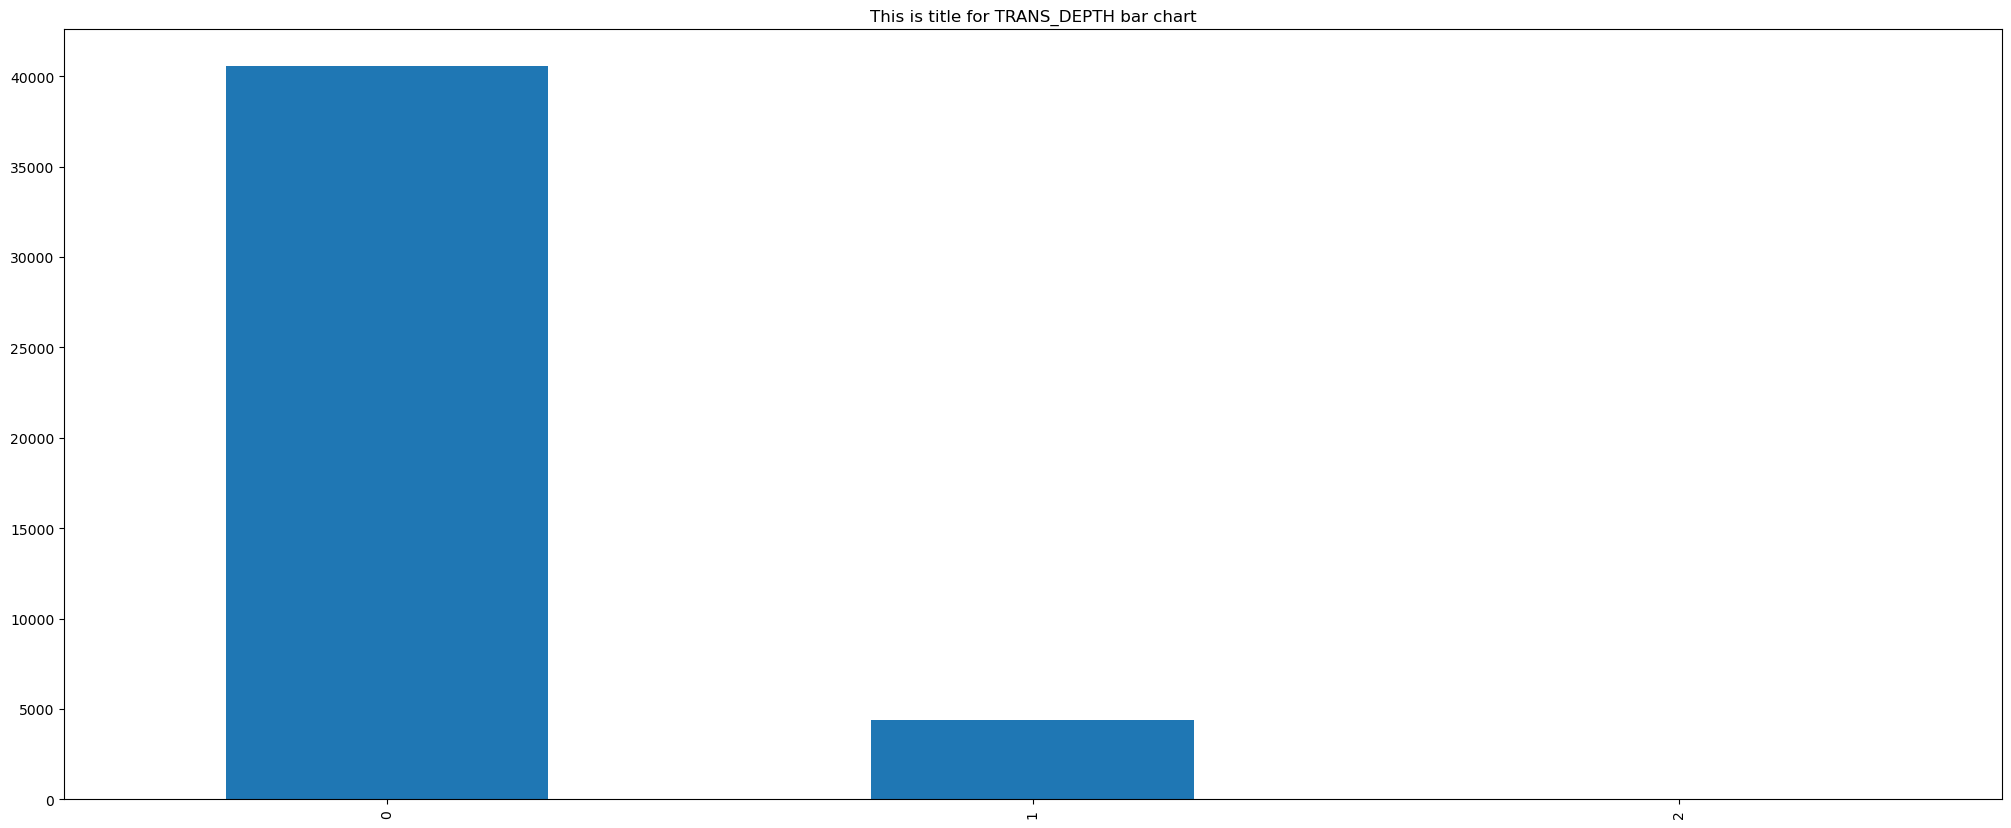

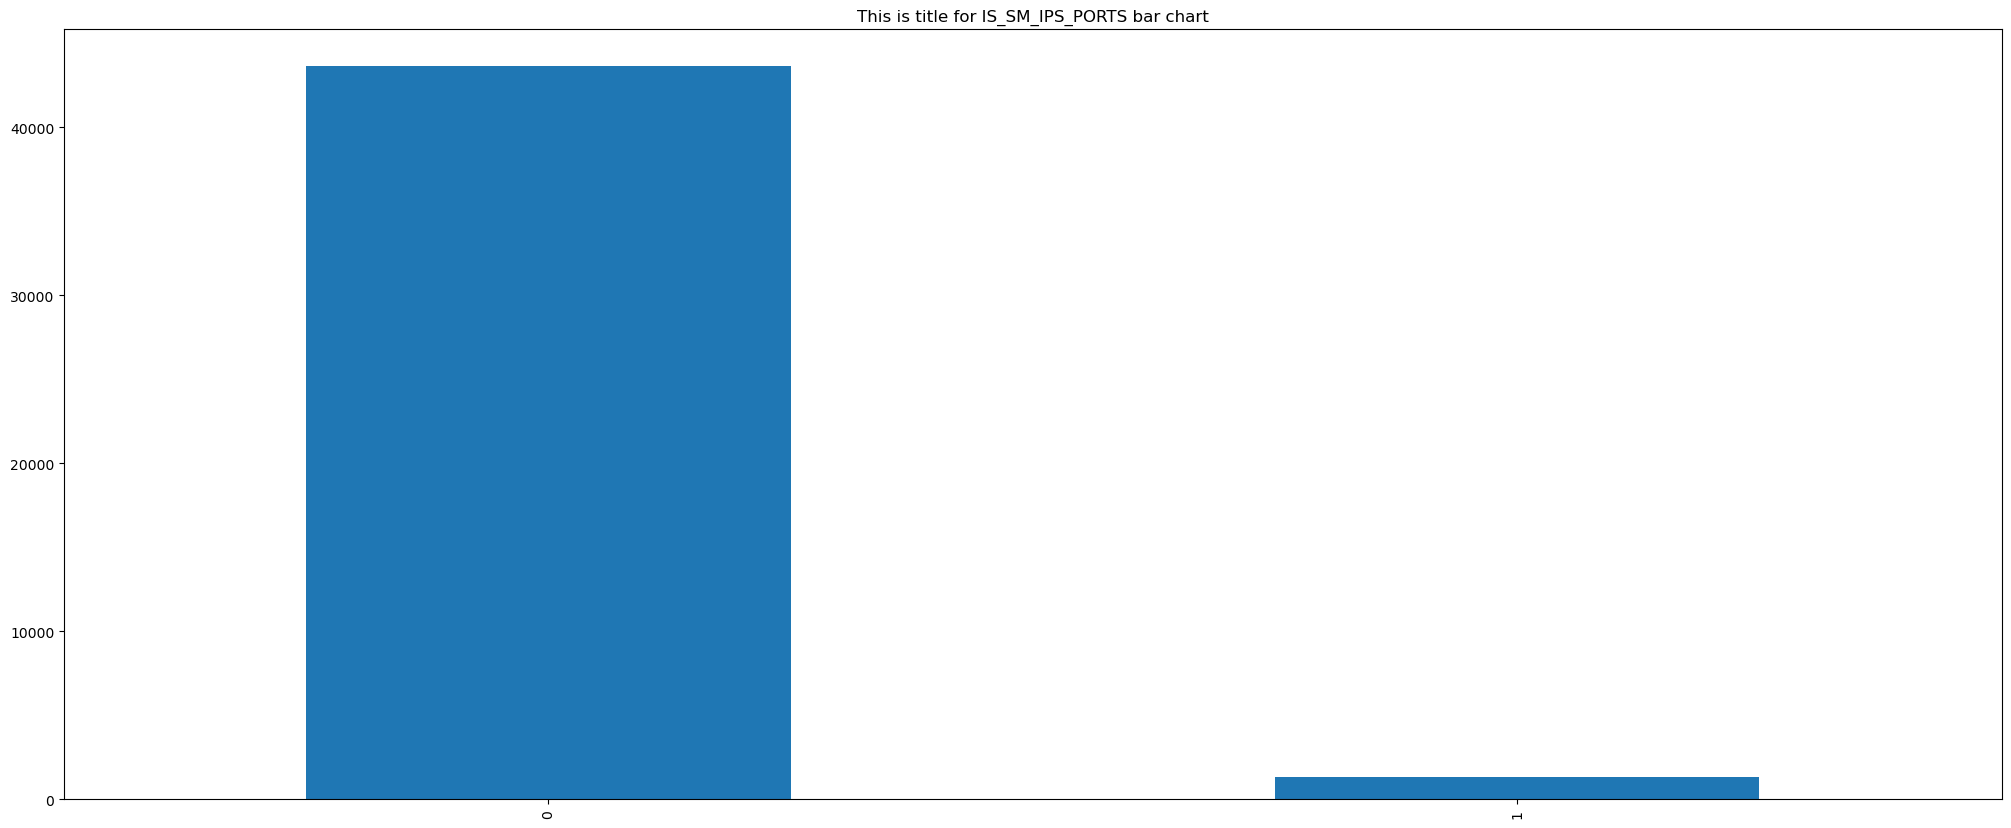

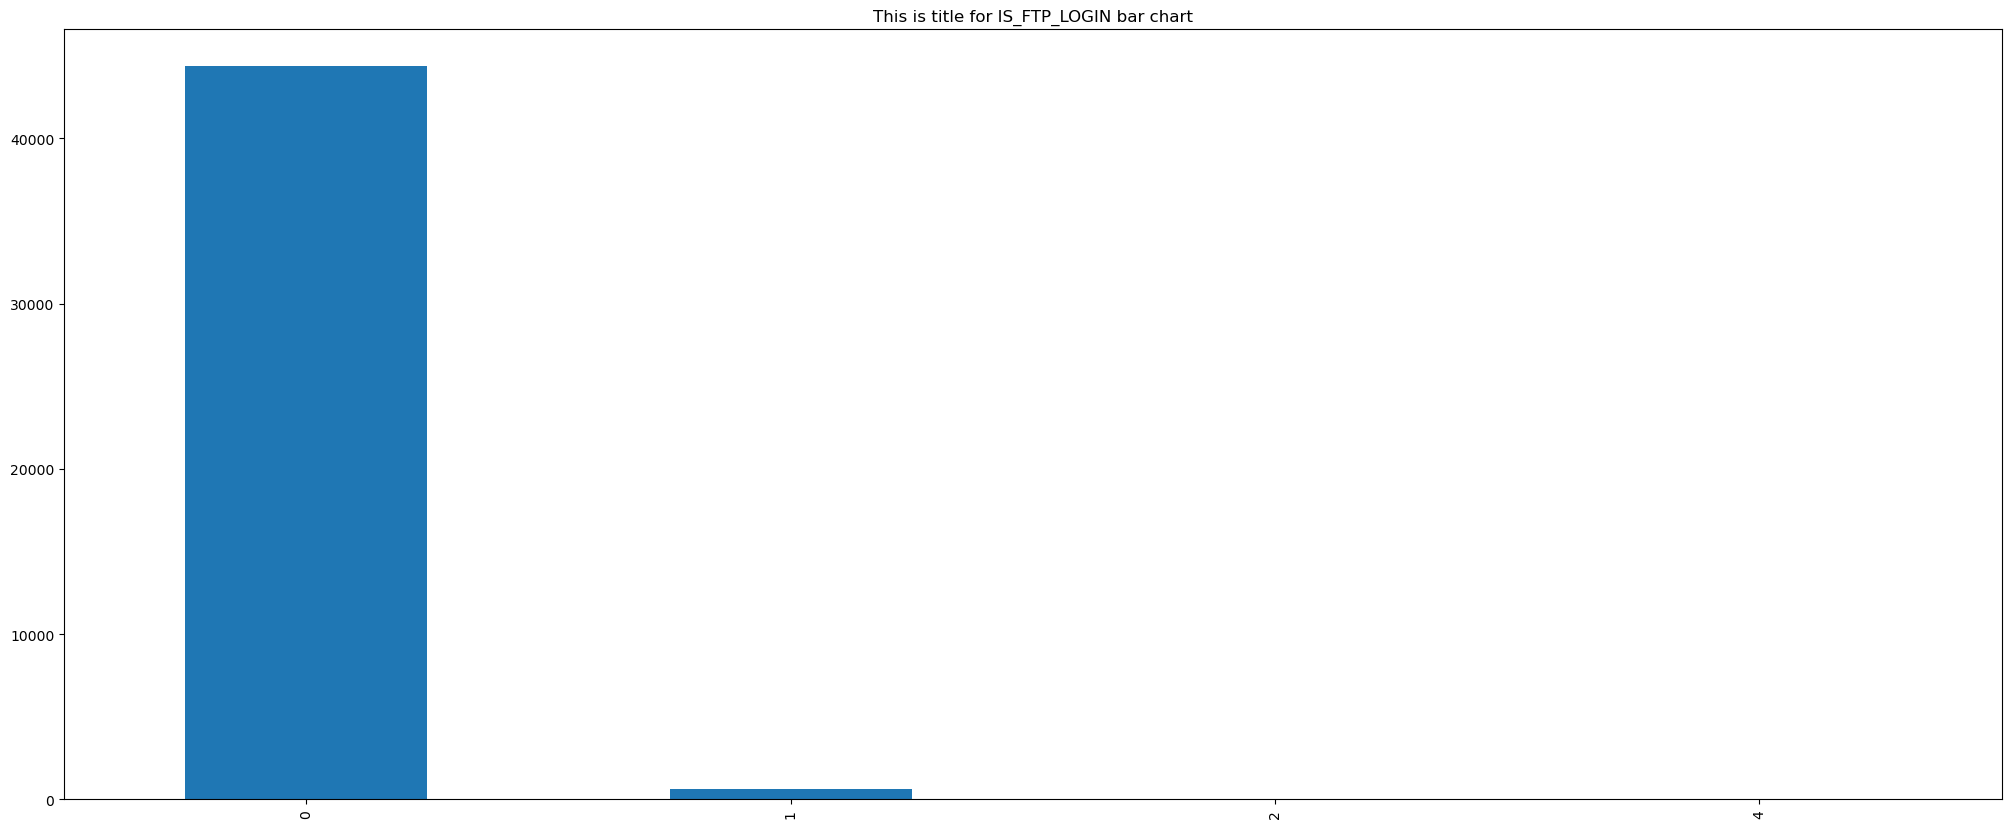

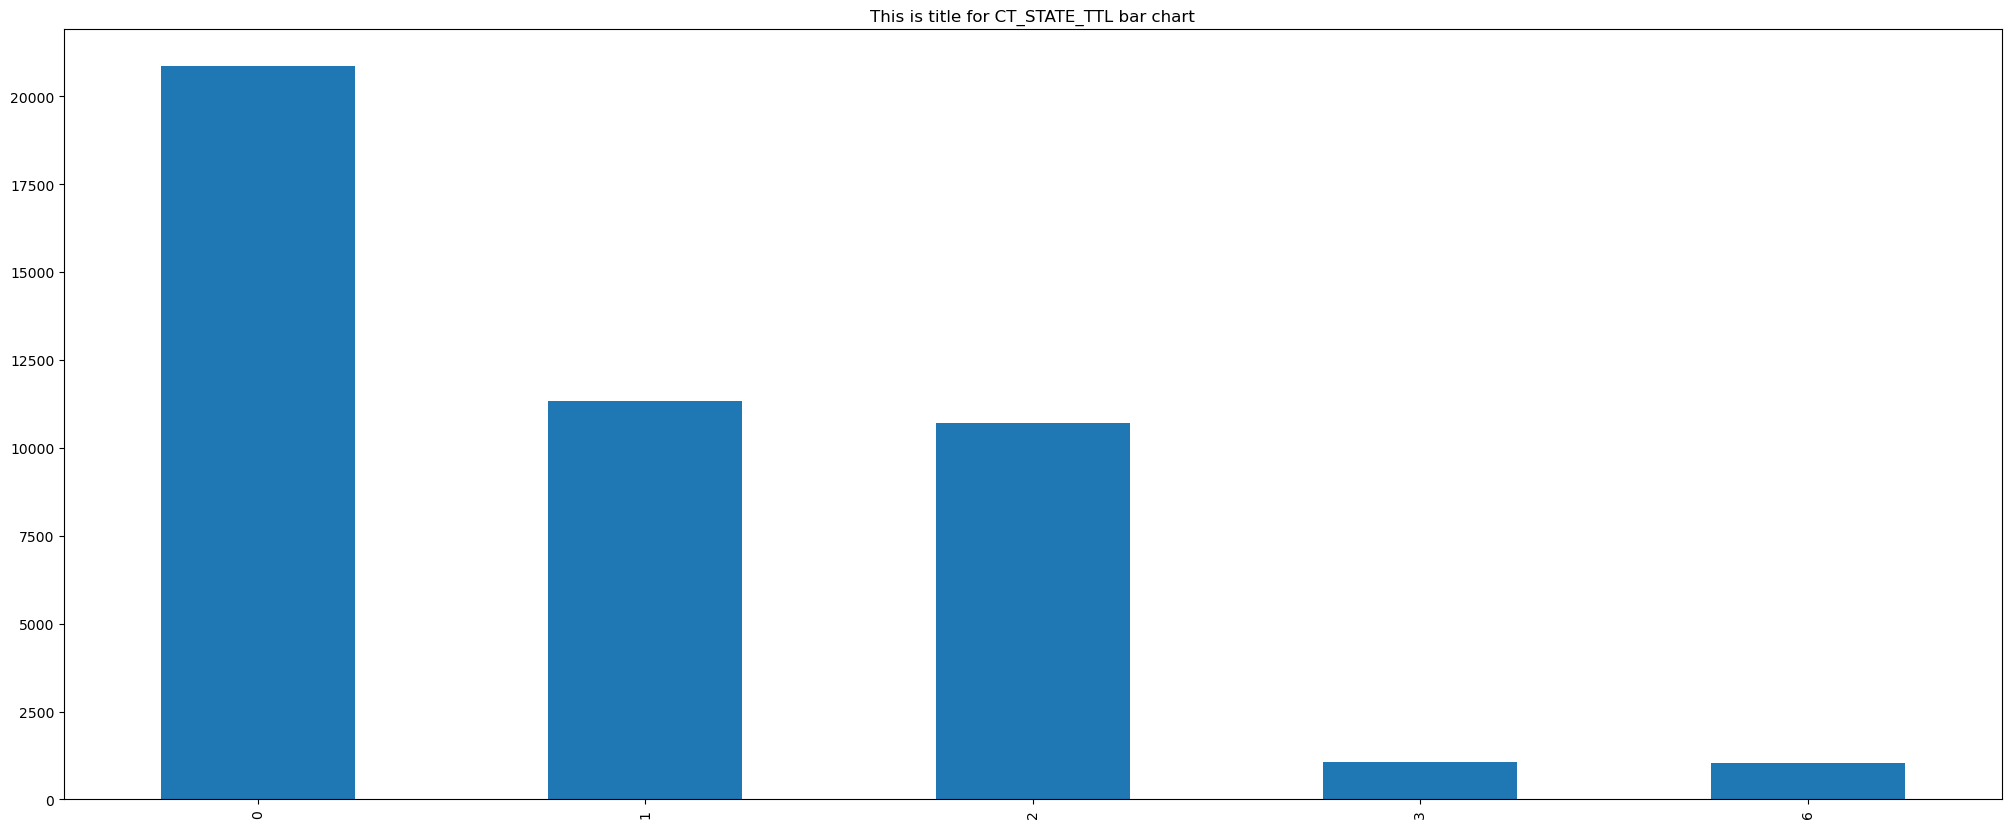

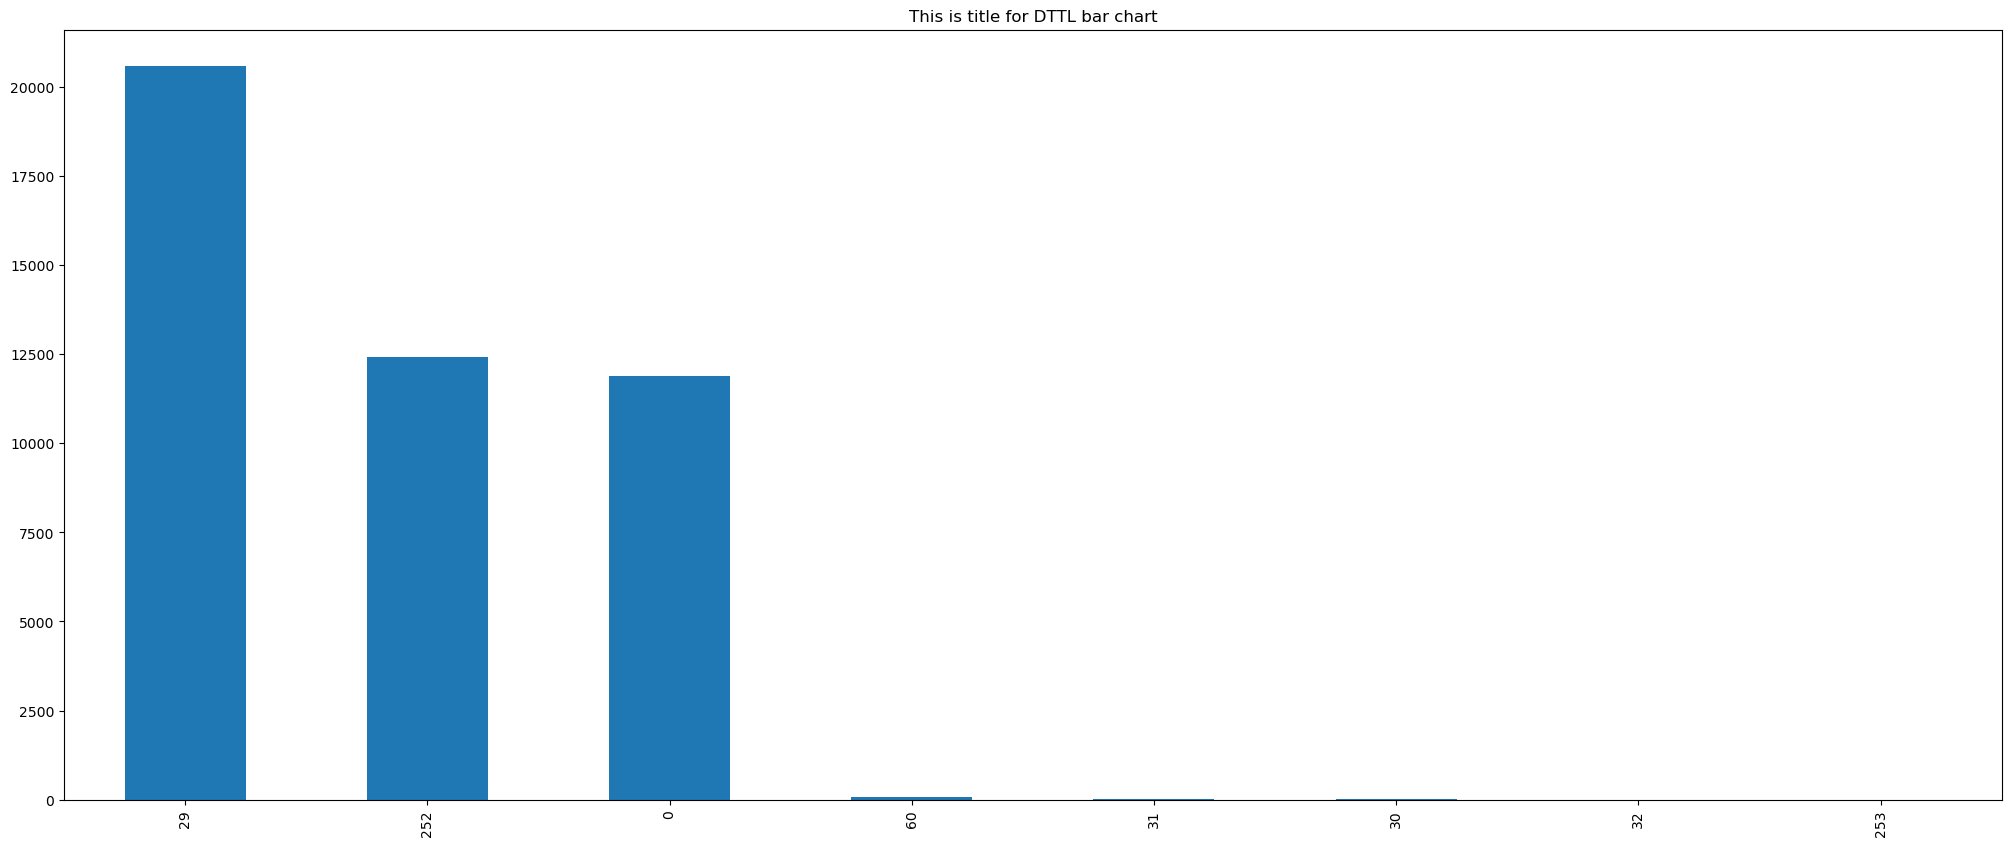

In [52]:
show_bar_plots_for_all_categorical_plots(eda_unsw_nb15_df, eda_unsw_nb15_categorical_features)

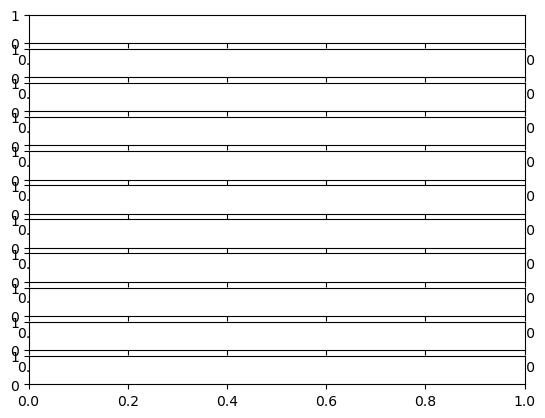

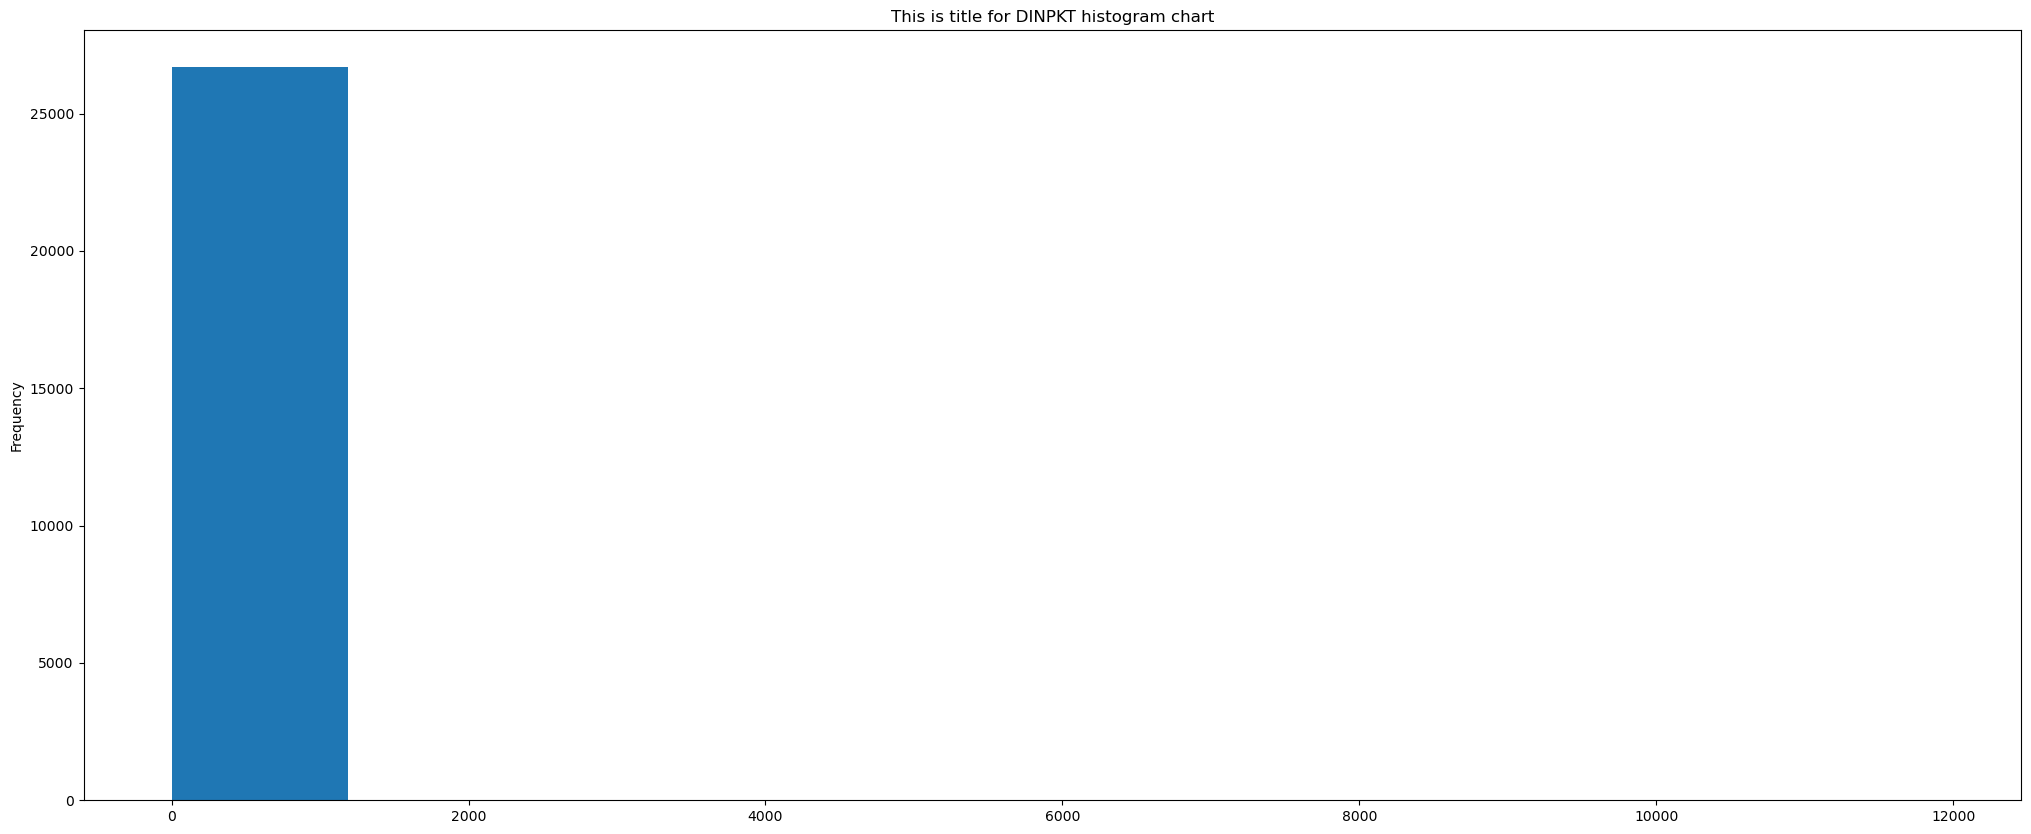

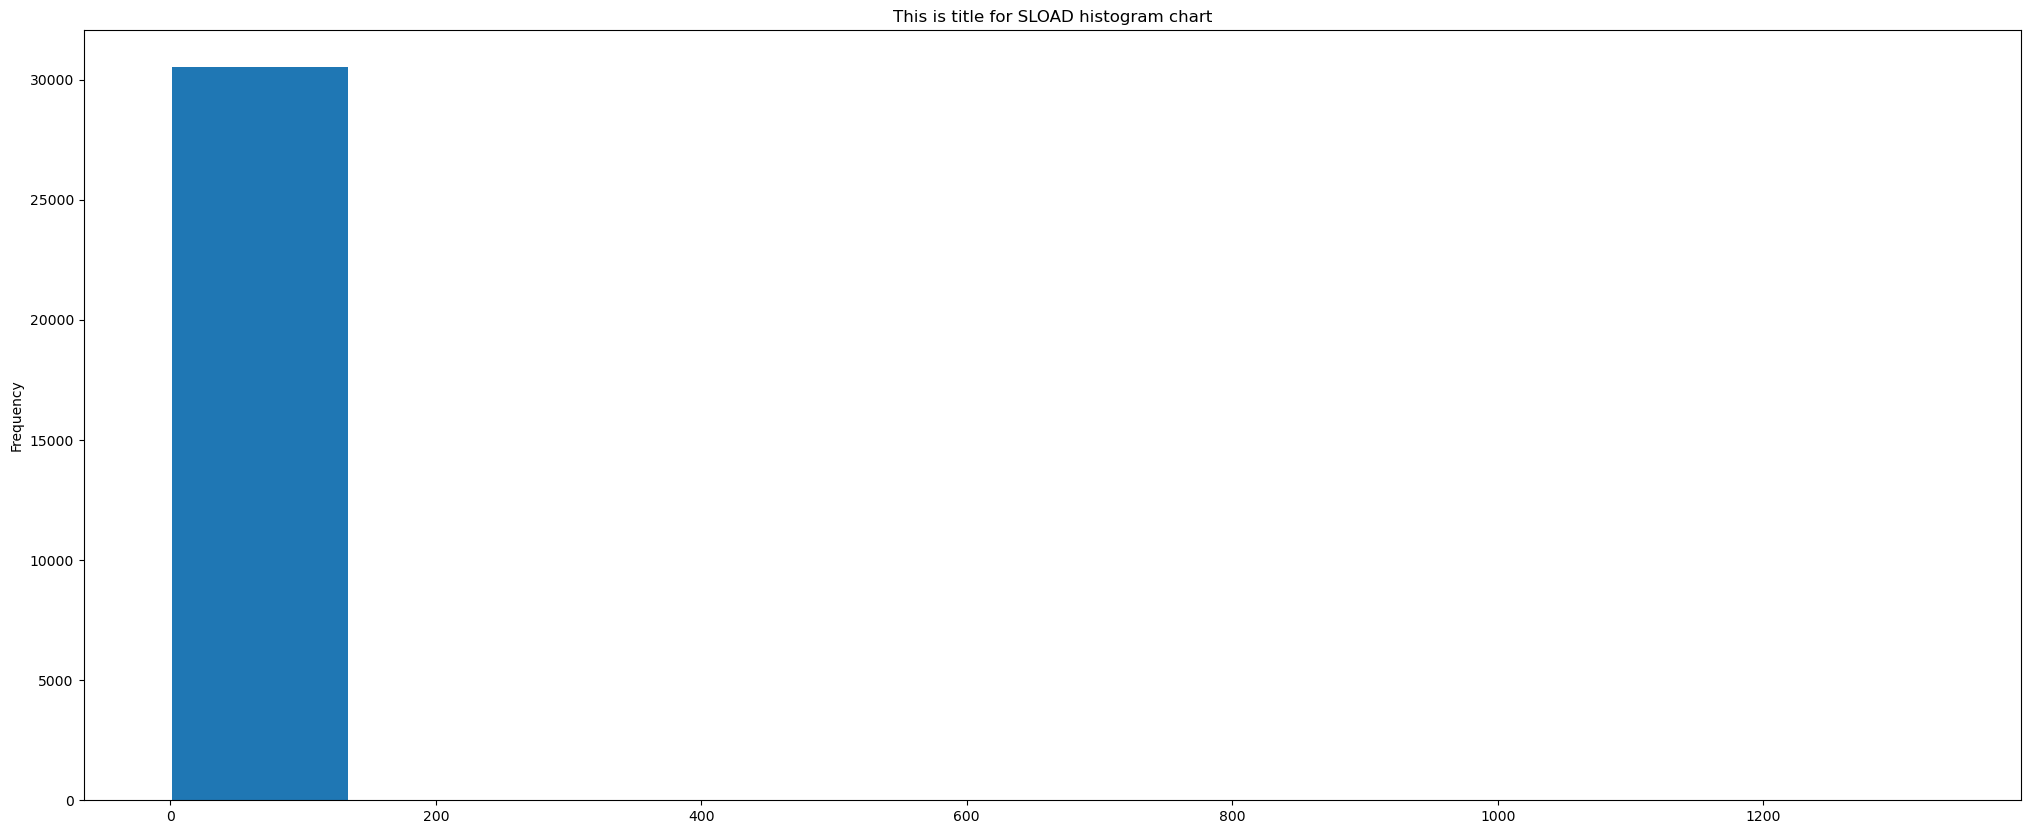

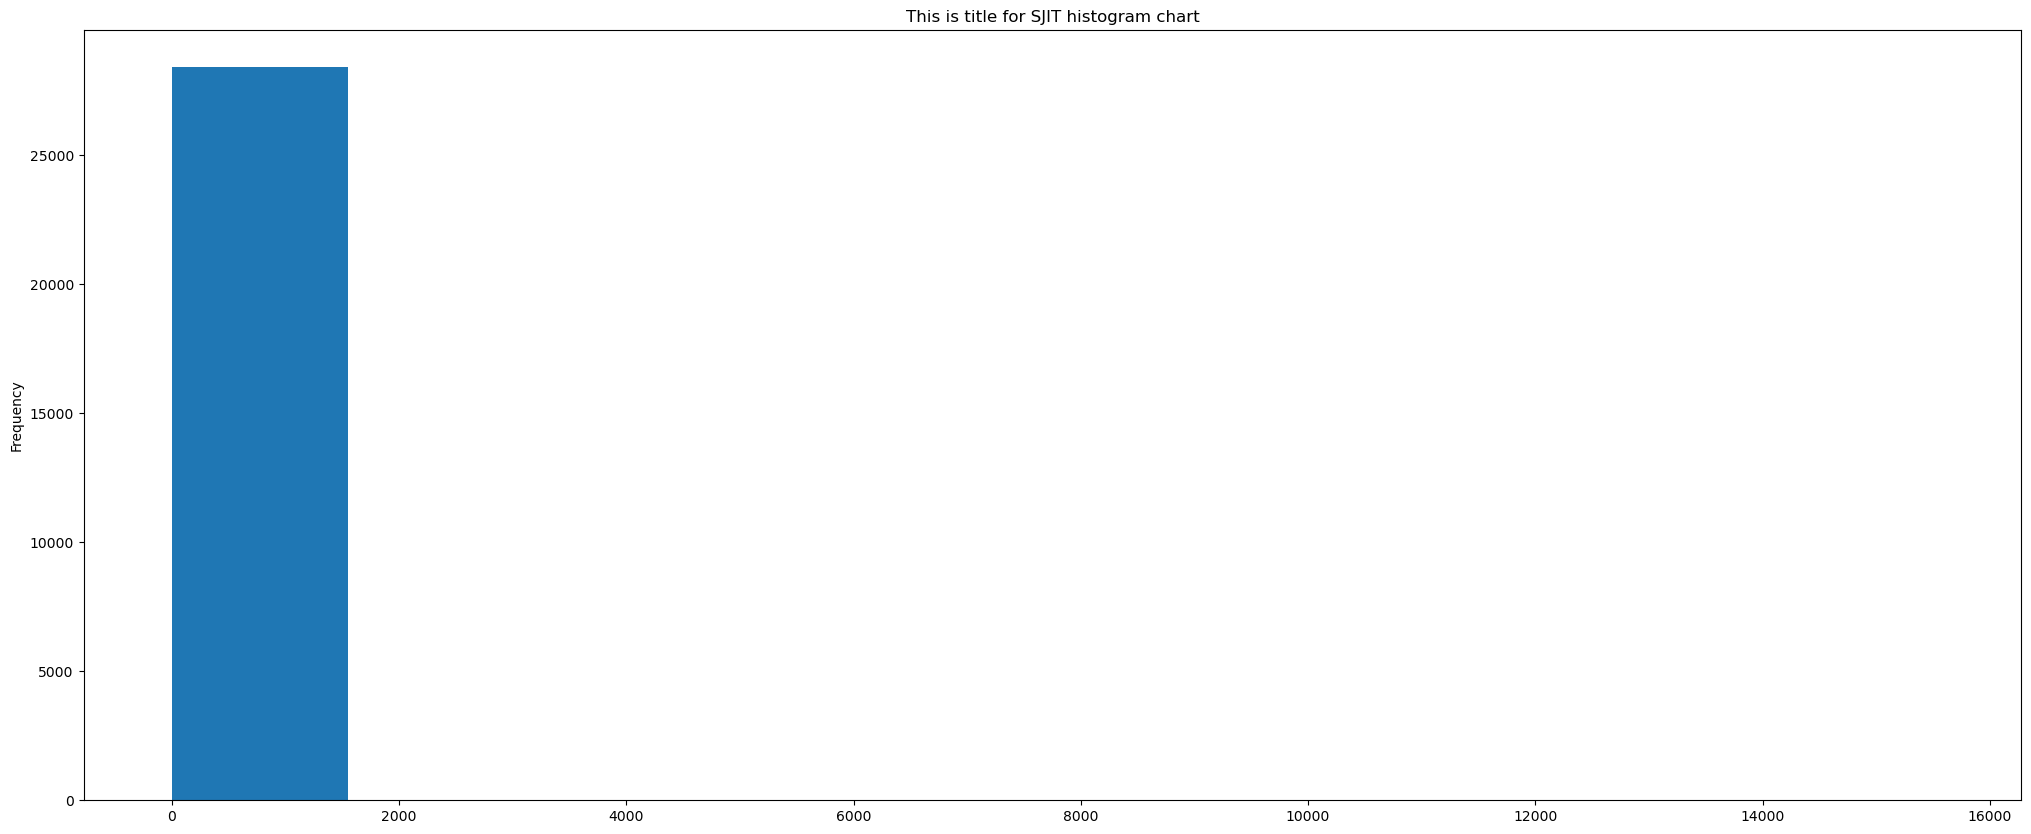

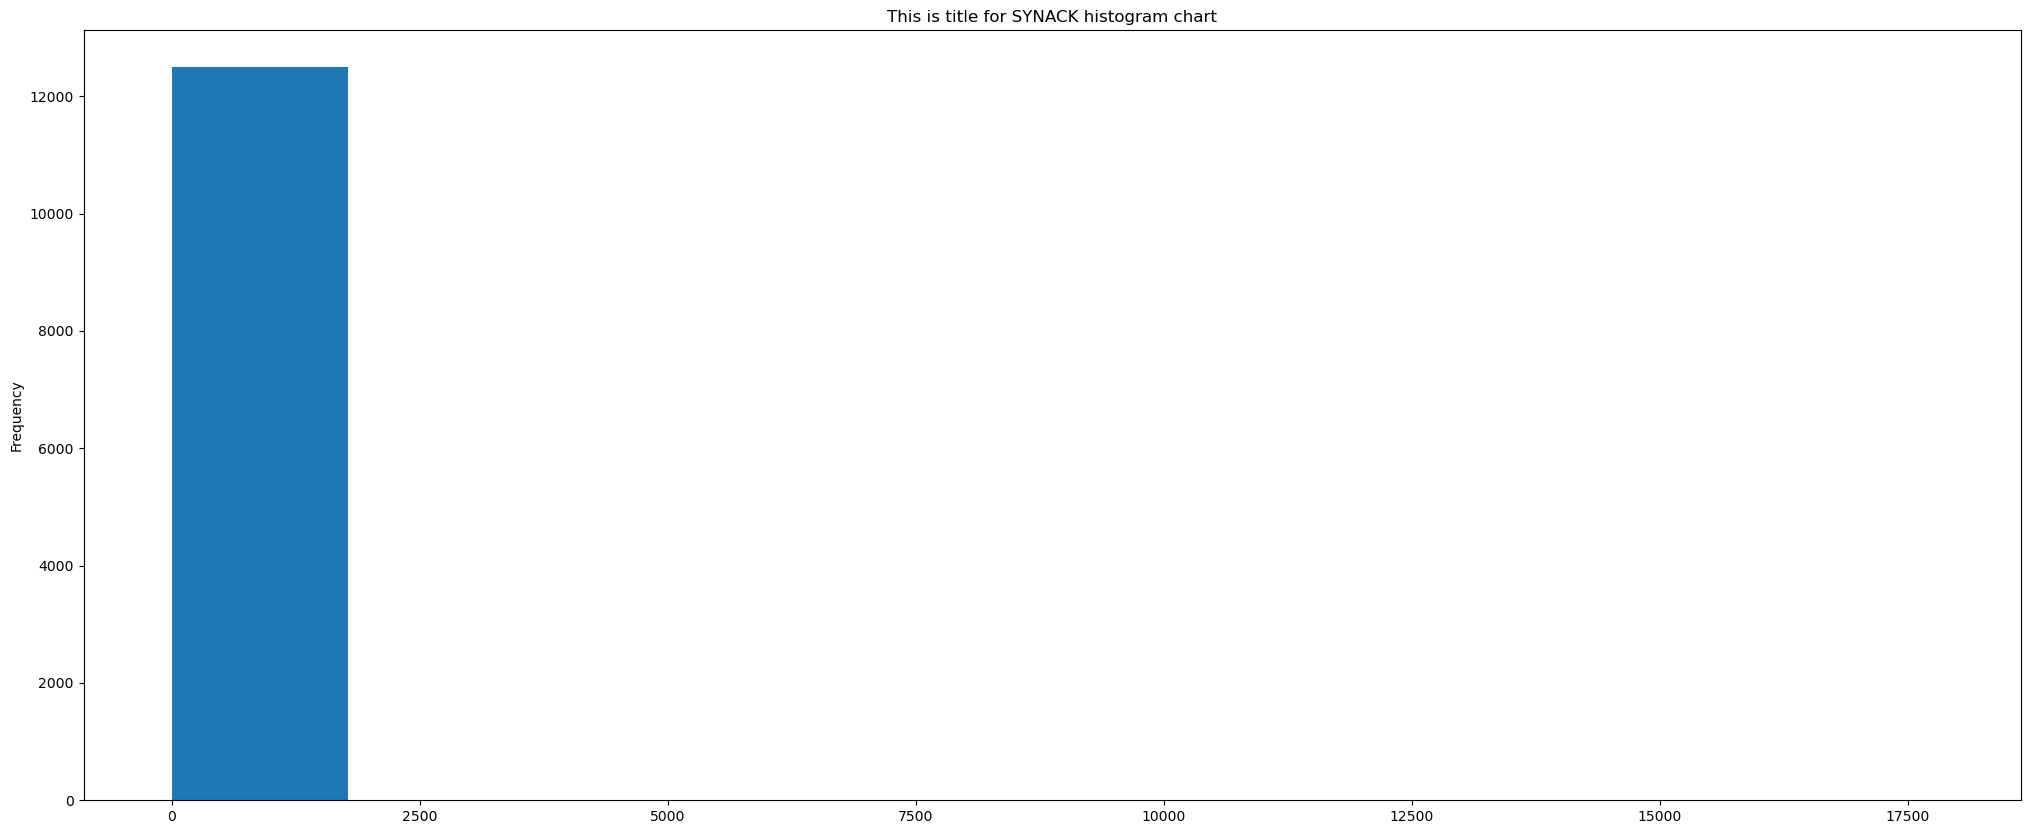

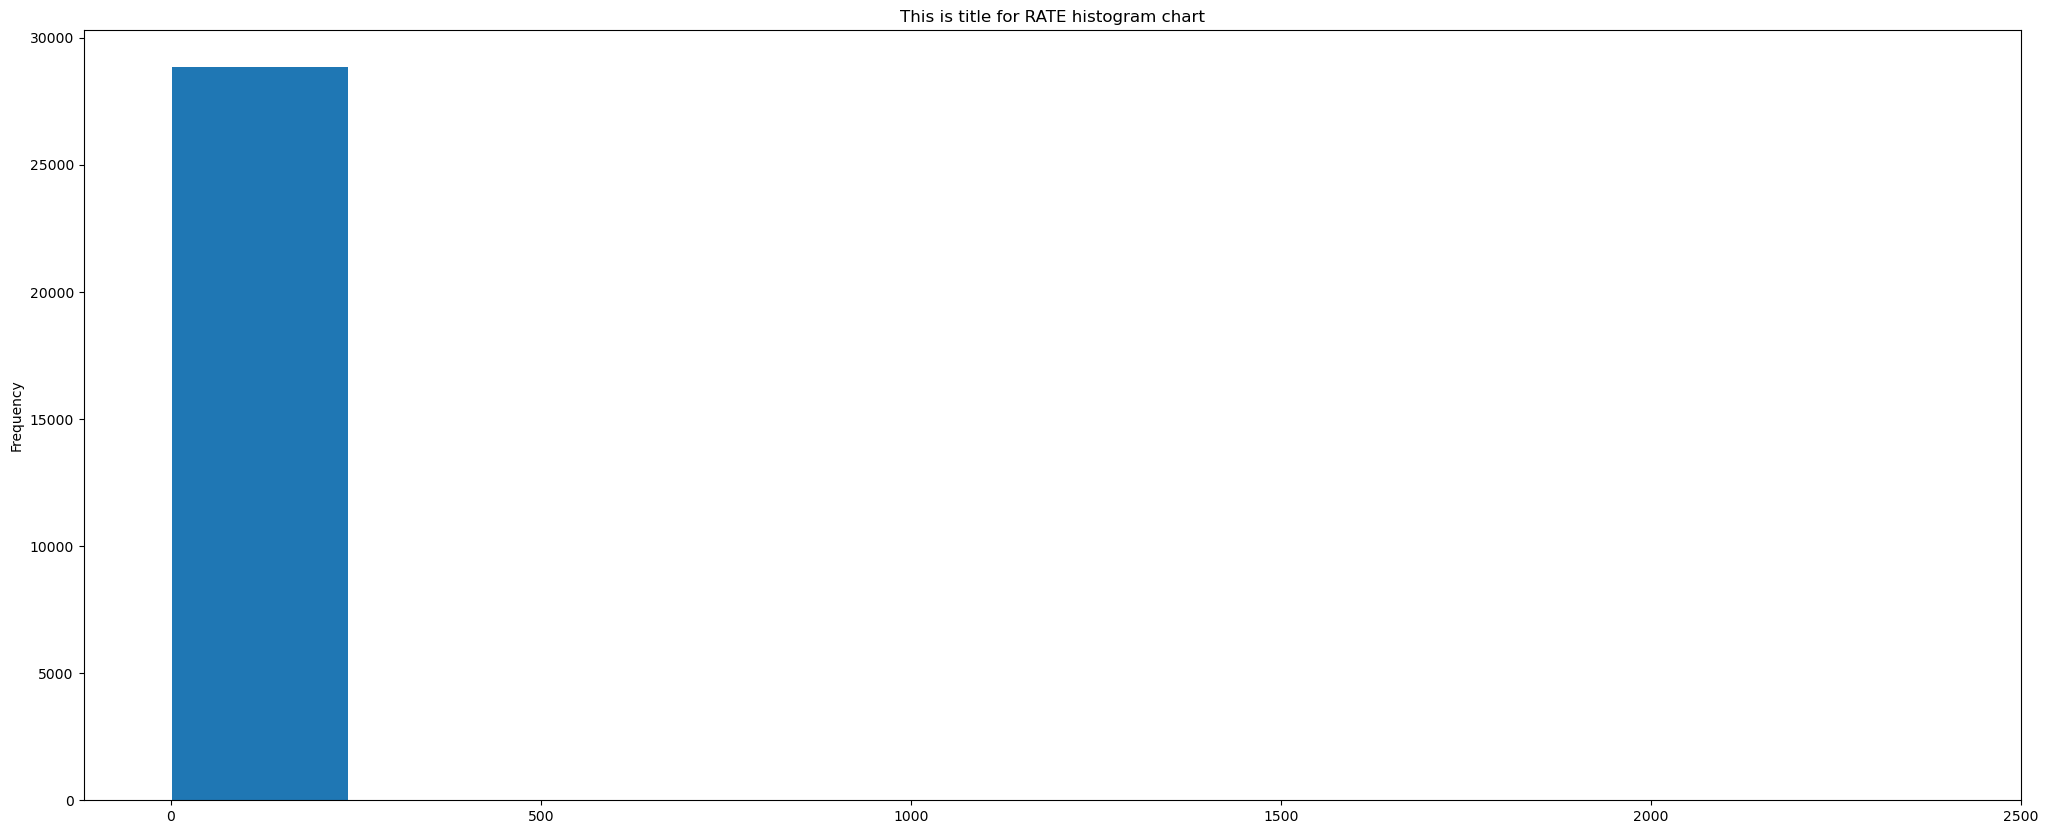

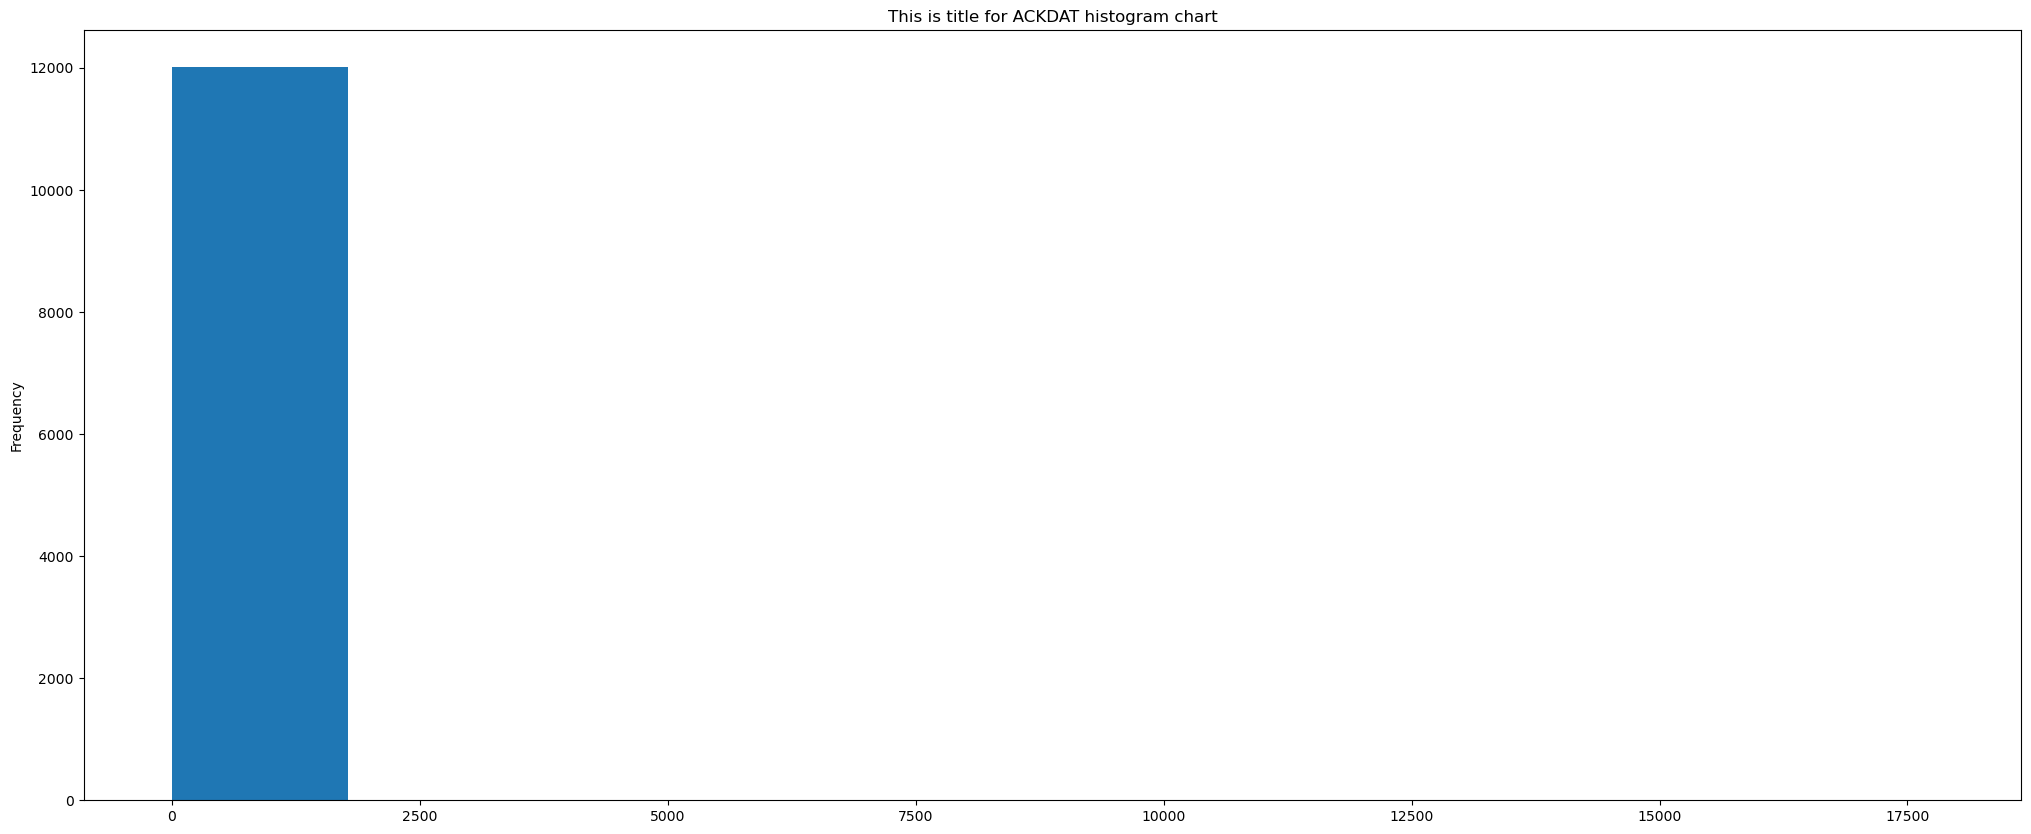

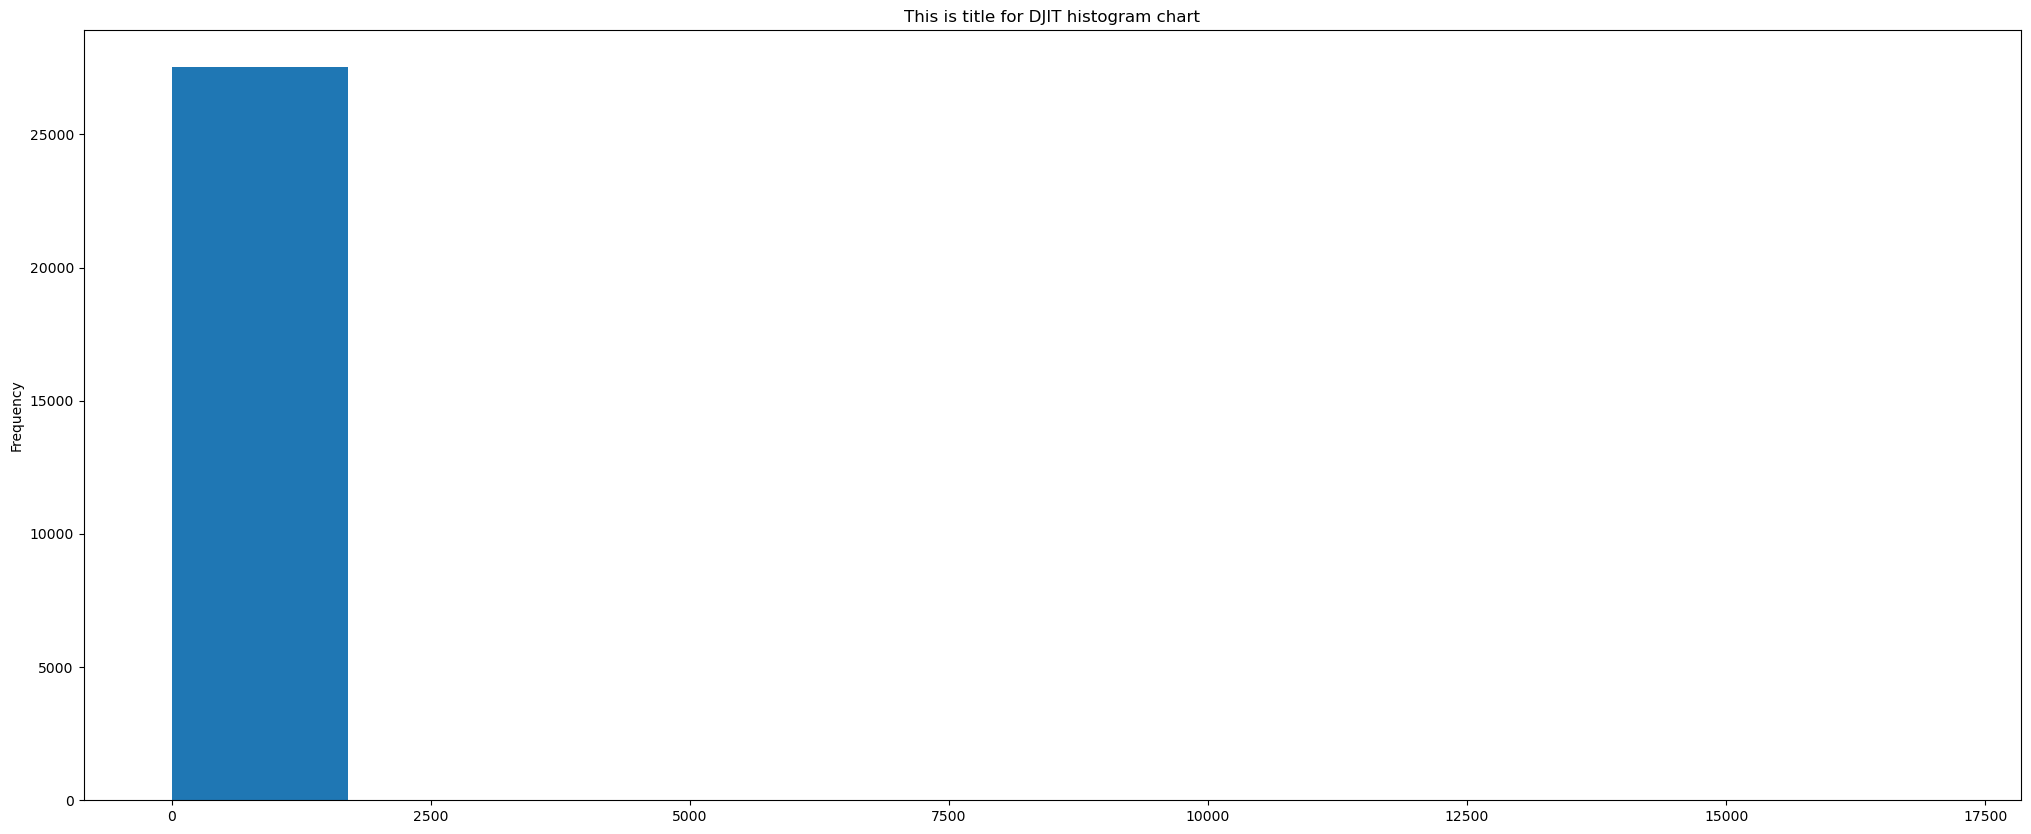

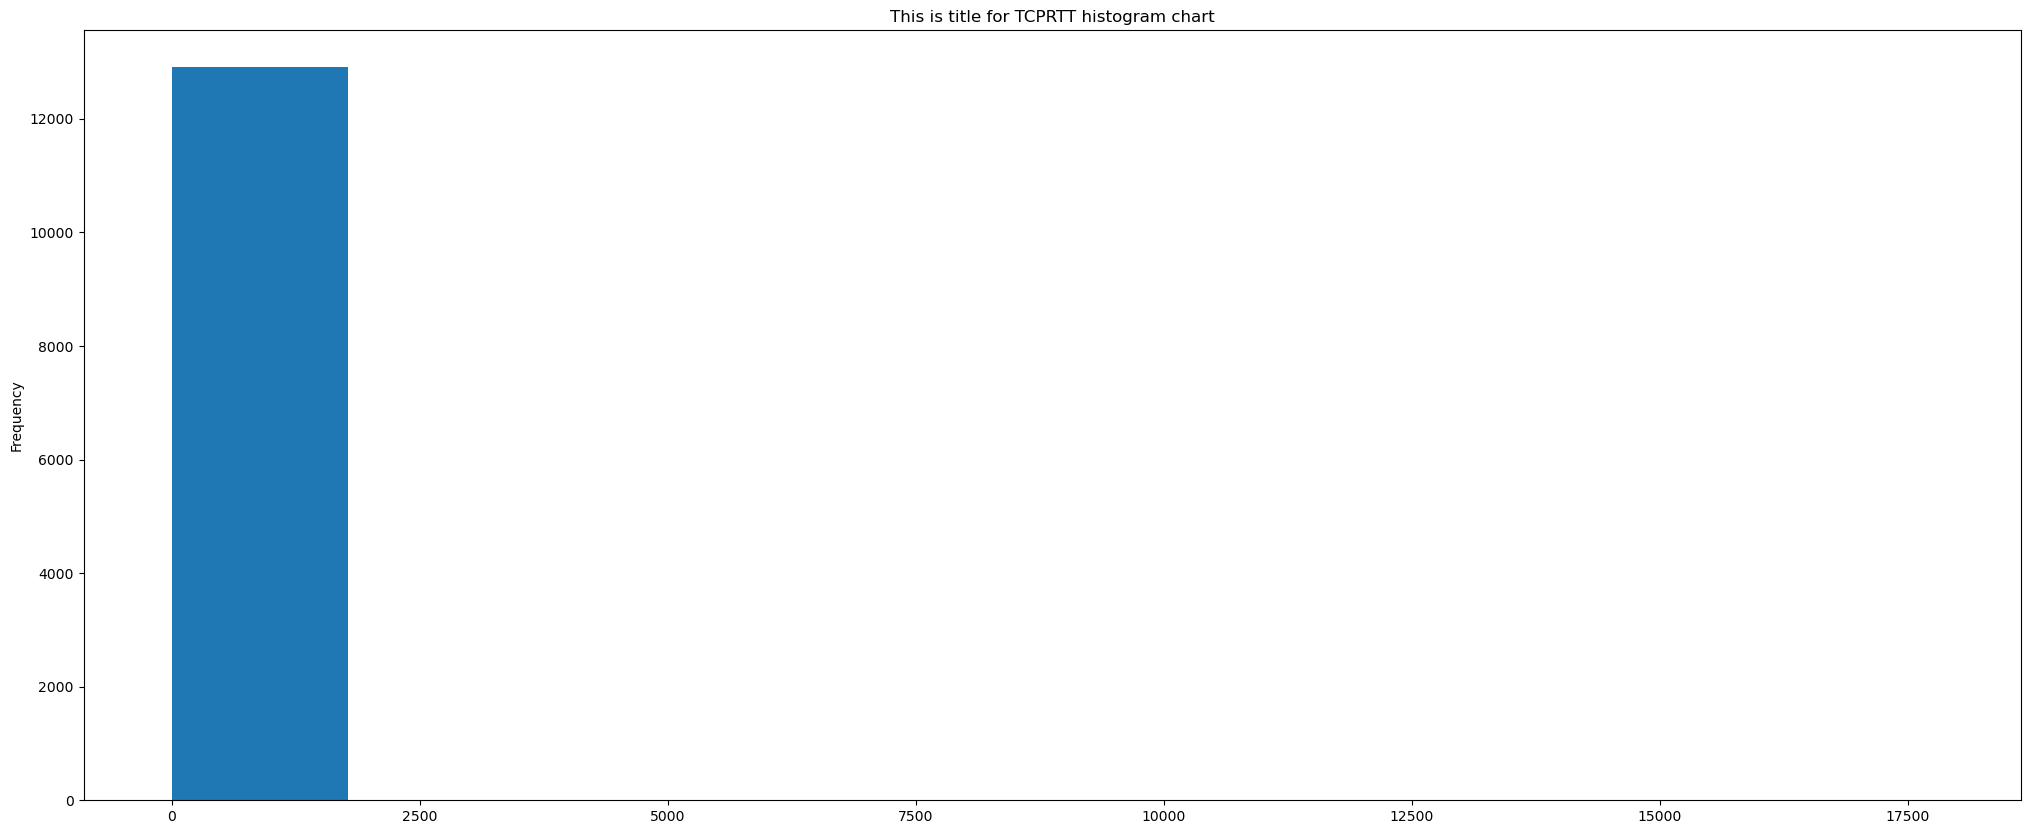

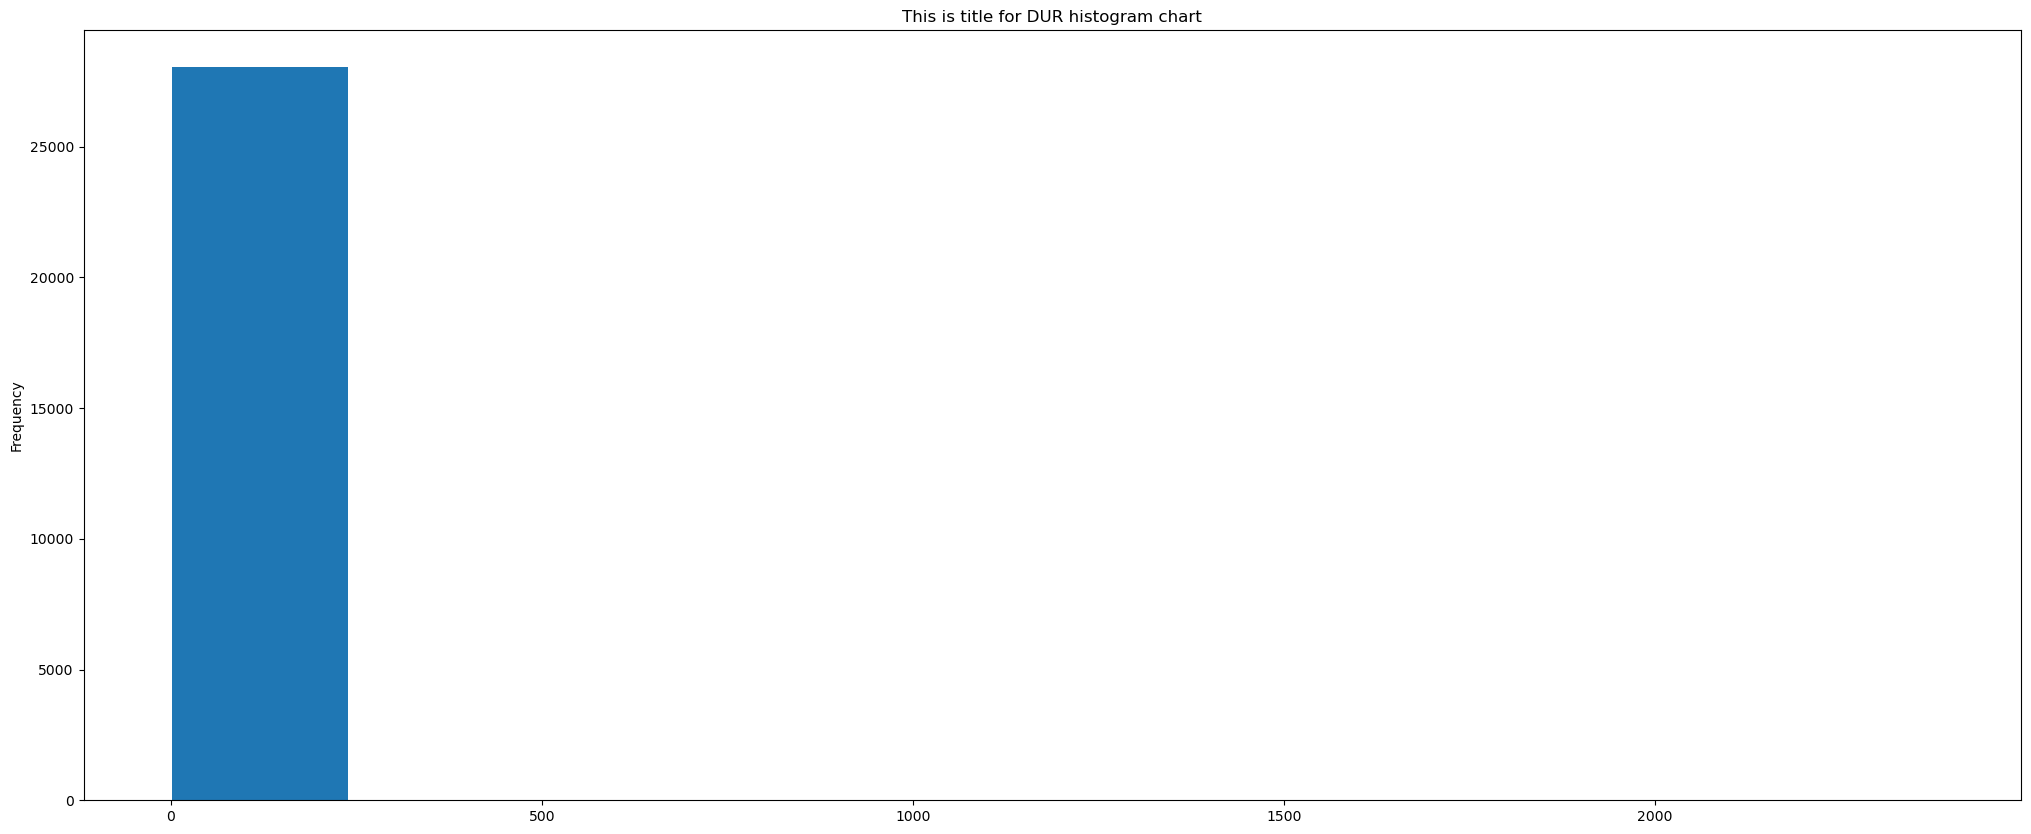

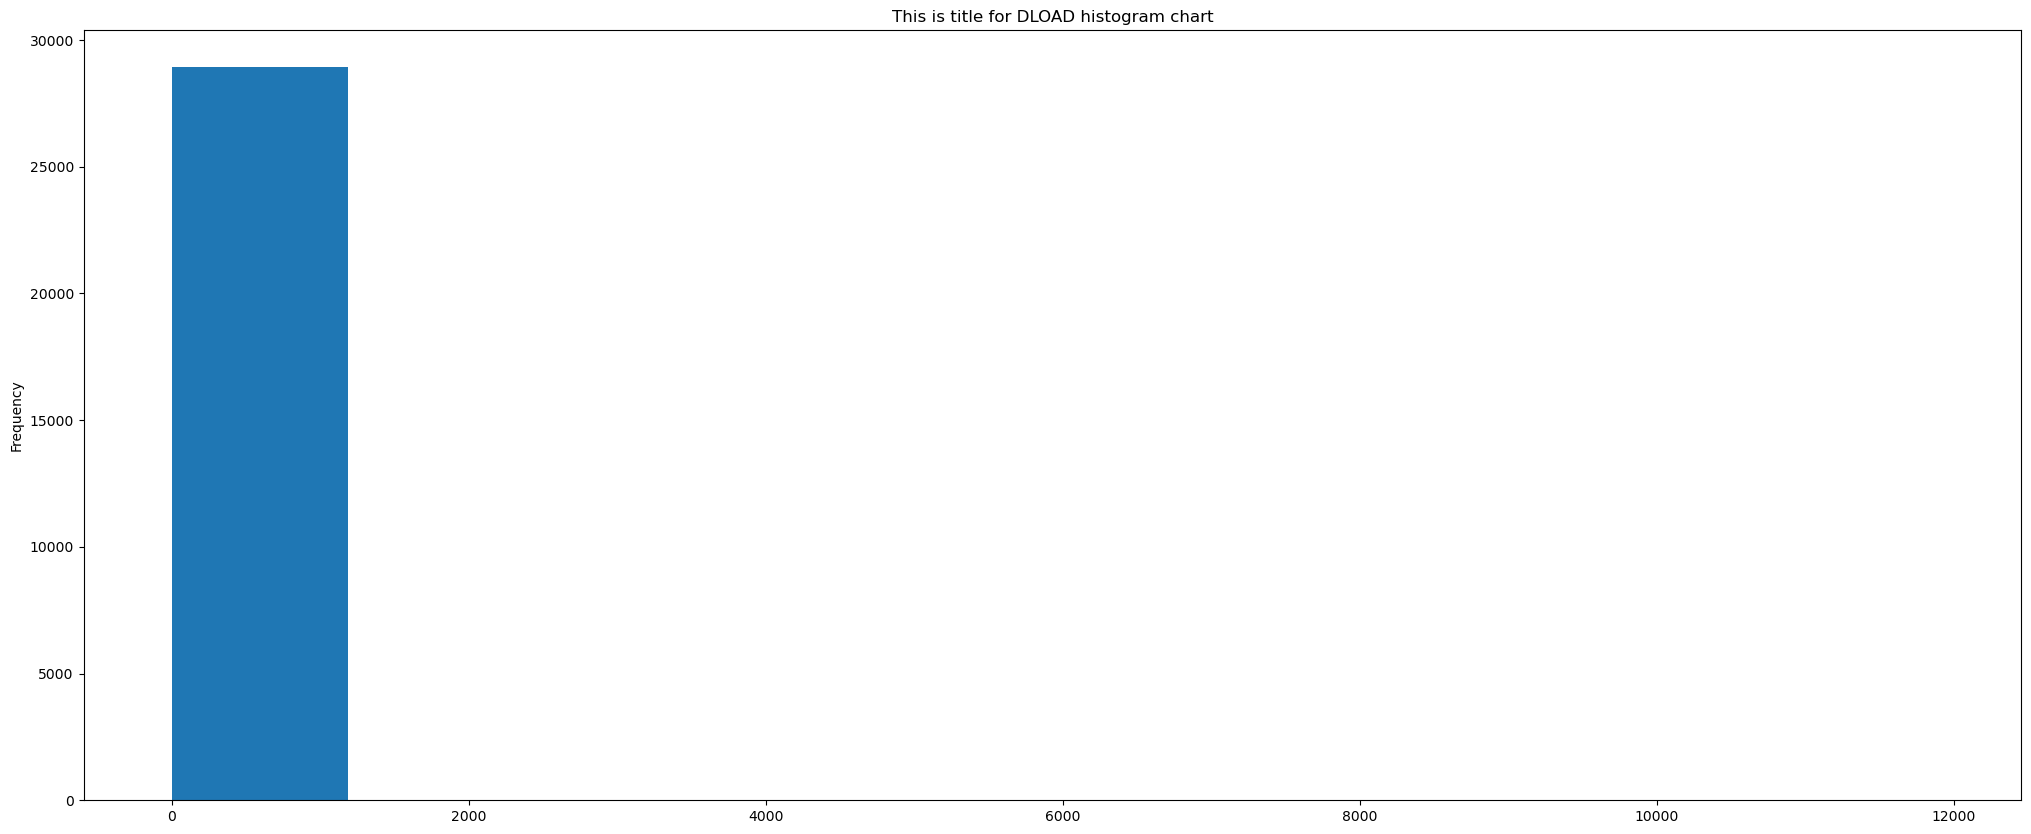

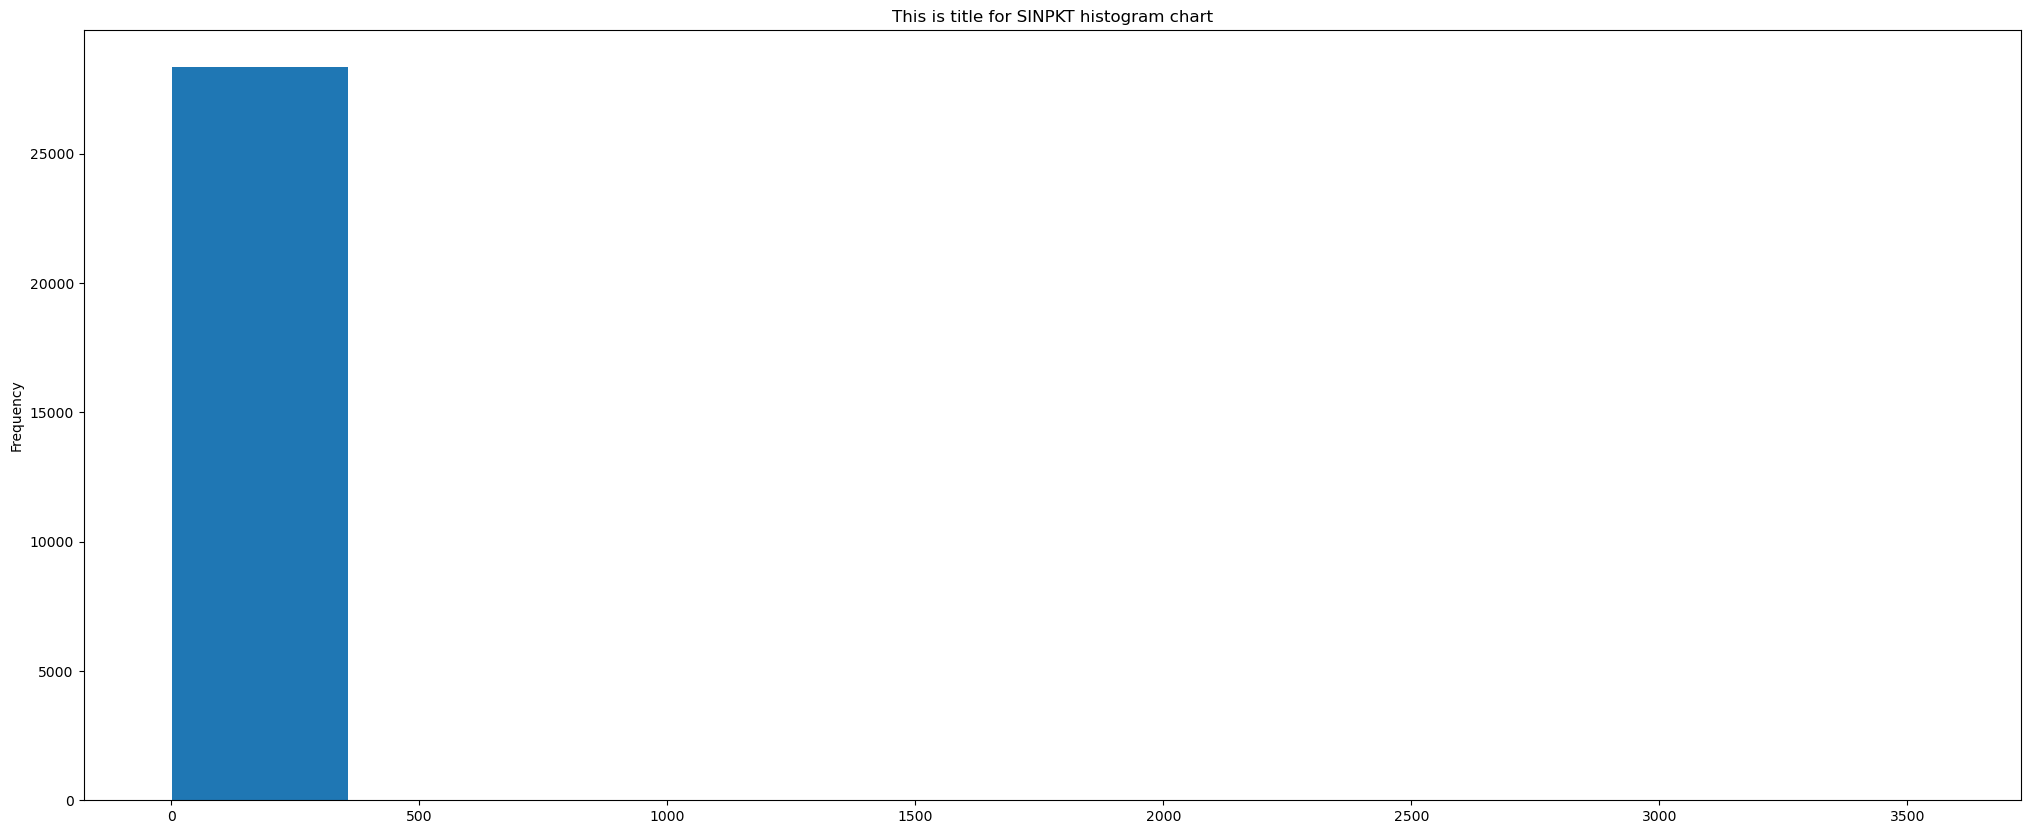

In [53]:
show_histogram_plots_for_all_continuous_plots(eda_unsw_nb15_df, eda_unsw_nb15_continuous_features)

In [54]:
target_kdd_cup_df = kdd_cup_df[target_variable]
target_unsw_nb15_df = unsw_nb15_df[target_variable]

In [55]:
features_kdd_cup_df = kdd_cup_df.drop([target_variable], axis=1)
features_unsw_nb15_df = unsw_nb15_df.drop([target_variable], axis=1)

In [56]:
features_kdd_cup_df = process_feature_mapping(features_kdd_cup_df)







FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME


Processing feature mapping for protocol_type feature




Processing feature mapping for service feature




Processing feature mapping for flag feature






In [57]:
features_kdd_cup_df.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
169090          0              0        0     0        215        310     0   
189211          0              0        1     0       5929          0     0   
543950          0              0        0     0        253       7207     0   
1233157         0              1        2     0       1032          0     0   
1047076         0              1        2     0       1032          0     0   

         wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
169090                0       0    0  ...              41                 255   
189211                0       0    0  ...              72                 101   
543950                0       0    0  ...             255                 255   
1233157               0       0    0  ...             255                 255   
1047076               0       0    0  ...             255                 255   

         dst_host_same_srv_rate  dst_host_diff_srv_rate  \
169090                     1.00                    0.00   
189211                     0.44                    0.03   
543950                     1.00                    0.00   
1233157                    1.00                    0.00   
1047076                    1.00                    0.00   

         dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
169090                          0.02                         0.01   
189211                          0.44                         0.03   
543950                          0.00                         0.00   
1233157                         1.00                         0.00   
1047076                         1.00                         0.00   

         dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
169090                    0.0                       0.0                   0.0   
189211                    0.0                       0.0                   0.0   
543950                    0.0                       0.0                   0.0   
1233157                   0.0                       0.0                   0.0   
1047076                   0.0                       0.0                   0.0   

         dst_host_srv_rerror_rate  
169090                        0.0  
189211                        0.0  
543950                        0.0  
1233157                       0.0  
1047076                       0.0  

[5 rows x 41 columns]

In [58]:
features_unsw_nb15_df = process_feature_mapping(features_unsw_nb15_df)







FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME


Processing feature mapping for proto feature




Processing feature mapping for service feature




Processing feature mapping for state feature






In [59]:
features_unsw_nb15_df.head()

id       dur  proto  service  state  spkts  dpkts  sbytes  dbytes  \
59151  22152  0.004872      0        0      0     18     18    3960    2456   
70350  33351  0.322386      0        0      0     40     42    2542   23508   
12548  35666  0.326474      0        1      0      8     12     424    8824   
11796  34914  0.001141      1        2      1      2      2     146     178   
53381  16382  0.273056      0        0      0     26     26    4160    2872   

              rate  ...  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  \
59151  7183.908275  ...           5                 1                 1   
70350   251.251608  ...           4                 1                 1   
12548    58.197588  ...           2                 1                 1   
11796  2629.272667  ...           3                 1                 1   
53381   186.774874  ...           5                 1                 1   

       ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  \
59151               3             0           0                 0           3   
70350               1             0           0                 0           8   
12548               1             0           0                 0           1   
11796               1             0           0                 0           3   
53381               5             0           0                 0           6   

       ct_srv_dst  is_sm_ips_ports  
59151          14                0  
70350           2                0  
12548           5                0  
11796           4                0  
53381           7                0  

[5 rows x 43 columns]

### Experiment I Setup

In [60]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 42)

In [61]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 42)

In [62]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [63]:
print(kddcup_y_train.agg(['nunique','count','size']))
print("\n")
print(kddcup_y_train[kddcup_y_train == 0].count())
print("\n")
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique        2
count      36000
size       36000
Name: traffic_type, dtype: int64


27294


8706


In [64]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print("\n")
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print("\n")
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique        2
count      36000
size       36000
Name: traffic_type, dtype: int64


27314


8686


In [65]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

### Experiment I

In [66]:
experiment_type = "EXPERIMENT-ONE"





ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      0.84      0.91      6872
      Attack       0.66      0.99      0.79      2128

    accuracy                           0.88      9000
   macro avg       0.83      0.92      0.85      9000
weighted avg       0.92      0.88      0.88      9000







CONFUSION MATRIX




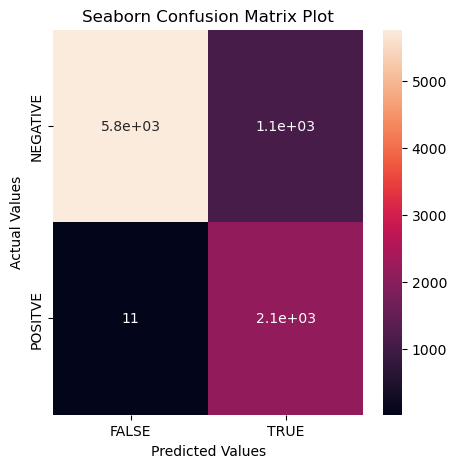







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9171
GEOMETRIC MEAN SCORE:  0.9138






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.23










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.91      0.81      0.86      6814
      Attack       0.55      0.74      0.64      2186

    accuracy                           0.79      9000
   macro avg       0.73      0.78      0.75      9000
weighted avg       0.82      0.79      0.80      9000







CONFUSION MATRIX




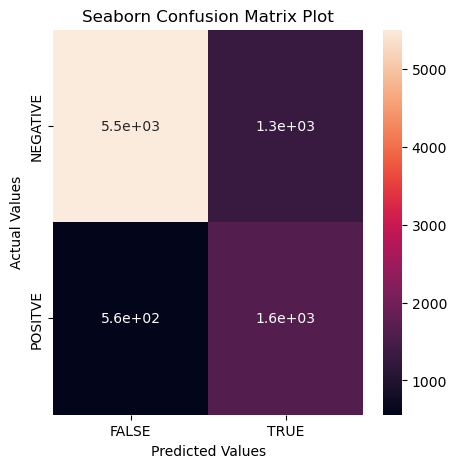







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.7760
GEOMETRIC MEAN SCORE:  0.7753






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.23








In [67]:
perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      6872
      Attack       1.00      1.00      1.00      2128

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000







CONFUSION MATRIX




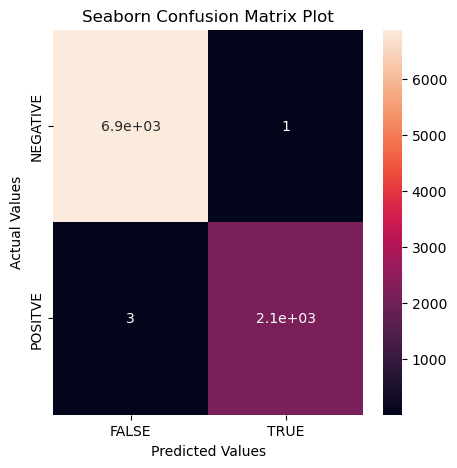







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9992
GEOMETRIC MEAN SCORE:  0.9992






TIME TAKEN TO COMPLETE MODEL ANALYSIS


1.15










ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96      6814
      Attack       0.96      0.80      0.87      2186

    accuracy                           0.94      9000
   macro avg       0.95      0.89      0.92      9000
weighted avg       0.94      0.94      0.94      9000







CONFUSION MATRIX




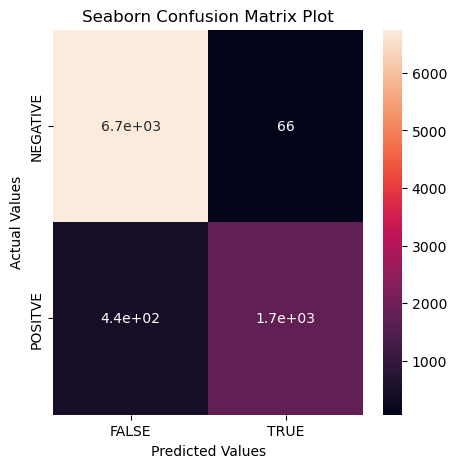







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8947
GEOMETRIC MEAN SCORE:  0.8896






TIME TAKEN TO COMPLETE MODEL ANALYSIS


32.12








In [68]:
perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      6872
      Attack       1.00      0.99      1.00      2128

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000







CONFUSION MATRIX




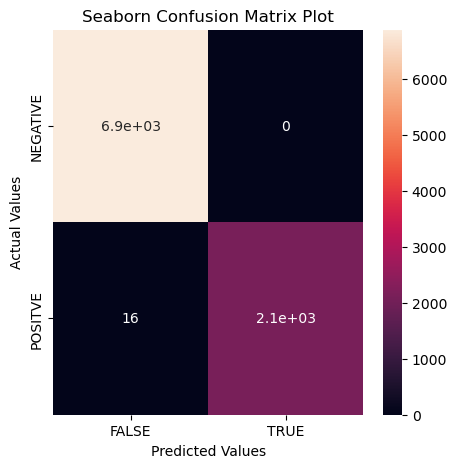







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9962
GEOMETRIC MEAN SCORE:  0.9962






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.27










ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95      6814
      Attack       0.84      0.83      0.83      2186

    accuracy                           0.92      9000
   macro avg       0.89      0.89      0.89      9000
weighted avg       0.92      0.92      0.92      9000







CONFUSION MATRIX




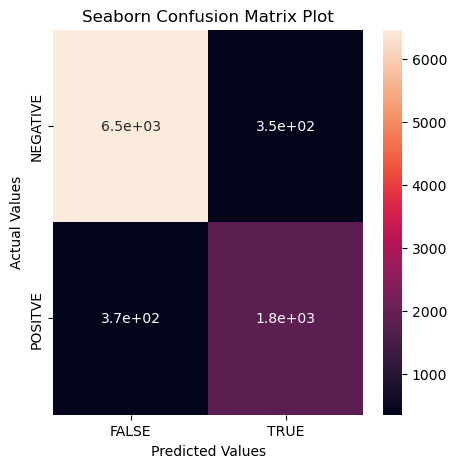







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8895
GEOMETRIC MEAN SCORE:  0.8875






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.38








In [69]:
perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      6872
      Attack       1.00      1.00      1.00      2128

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000







CONFUSION MATRIX




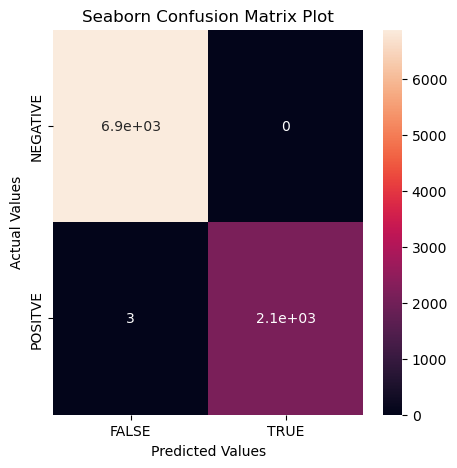







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9993
GEOMETRIC MEAN SCORE:  0.9993






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.62










ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.99      0.86      0.92      6814
      Attack       0.68      0.96      0.80      2186

    accuracy                           0.88      9000
   macro avg       0.83      0.91      0.86      9000
weighted avg       0.91      0.88      0.89      9000







CONFUSION MATRIX




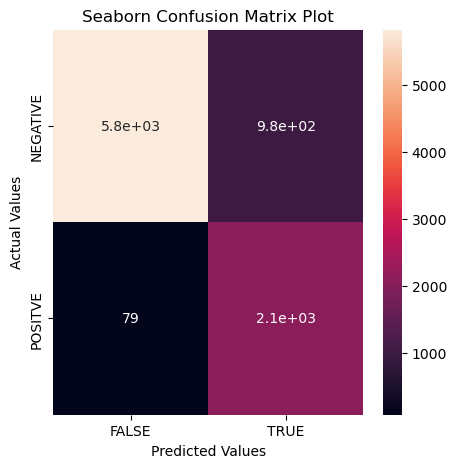







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9097
GEOMETRIC MEAN SCORE:  0.9081






TIME TAKEN TO COMPLETE MODEL ANALYSIS


1.76








In [70]:
perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41)                1722      
                                                                 
 dense_1 (Dense)             (None, 1)                 42        
                                                                 
 dense_2 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,768
Trainable params: 1,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
360/360 [==============================] - 2s 3ms/step - loss: 0.5128 - accuracy: 0.7582
Epoch 2/10
360/360 [==============================] - 1s 3ms/step - loss: 0.3631 - accuracy: 0.7582
Epoch 3/10
360/360 [==============================] - 1s 3ms/step - loss: 0.2971 - accuracy: 0.7582
Epoch 4/10
360/360

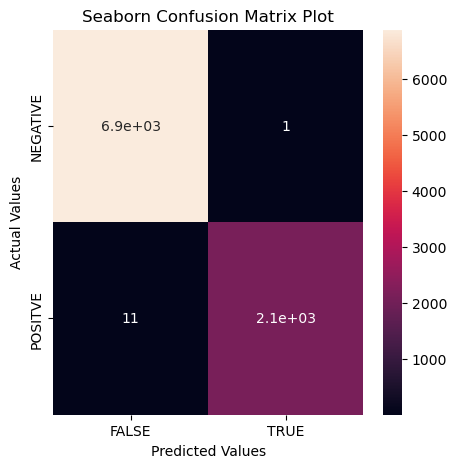







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9973
GEOMETRIC MEAN SCORE:  0.9973






TIME TAKEN TO COMPLETE MODEL ANALYSIS


13.49






Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 43)                1892      
                                                                 
 dense_4 (Dense)             (None, 1)                 44        
                                                                 
 dense_5 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
360/360 [==============================] - 2s 3ms/step - loss: 0.4365 - accuracy: 0.7736
Epoch 2/10
360/360 [==============================] - 1s 3ms/step - loss

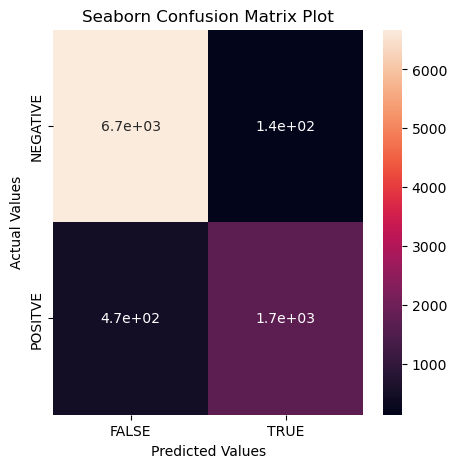







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8831
GEOMETRIC MEAN SCORE:  0.8779






TIME TAKEN TO COMPLETE MODEL ANALYSIS


13.41








In [71]:
perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment I

In [72]:
Exp_1_KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [73]:
Exp_1_UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [74]:
Exp_1_KDD_Analysis_Summary_df

AUC    G-MEAN
NBC  0.917089  0.913788
SVM  0.999222  0.999222
DTC  0.996241  0.996234
RFC  0.999295  0.999295
ANN  0.997343  0.997339

In [75]:
Exp_1_UNSWNB15_Analysis_Summary_df

AUC    G-MEAN
NBC  0.776007  0.775339
SVM  0.894745  0.889627
DTC  0.889524  0.887519
RFC  0.909726  0.908114
ANN  0.883140  0.877872

### Experiment II Setup

In [76]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 42)

In [77]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 42)

In [78]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [79]:
ros = SMOTENC([1], random_state=0)
start_time = time.time()
# kddcup_X_train, kddcup_y_train = remove_imbalance_in_dataset_using_smote_technique(kddcup_X_train, kddcup_y_train)
# unsw_nb15_X_train, unsw_nb15_y_train = remove_imbalance_in_dataset_using_smote_technique(unsw_nb15_X_train, unsw_nb15_y_train)
kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)
unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)
end_time = time.time()        
print("\n")
print("\n")
print("\n")
print("TIME TAKEN TO HANDLE IMBALANCE IN DATASET FOR EXPERIMENT II")
print("=========================================================")
print("\n")
print("{:.2f}".format(end_time - start_time))
print("\n")
print("\n")
print("\n")







TIME TAKEN TO HANDLE IMBALANCE IN DATASET FOR EXPERIMENT II


95.60








In [80]:
print(kddcup_y_train.agg(['nunique','count','size']))
print("\n")
print(kddcup_y_train[kddcup_y_train == 0].count())
print("\n")
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique        2
count      54588
size       54588
Name: traffic_type, dtype: int64


27294


27294


In [81]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print("\n")
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print("\n")
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique        2
count      54628
size       54628
Name: traffic_type, dtype: int64


27314


27314


In [82]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment II

In [83]:
experiment_type = "EXPERIMENT-TWO"





ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      0.84      0.91      6872
      Attack       0.66      0.99      0.79      2128

    accuracy                           0.88      9000
   macro avg       0.83      0.92      0.85      9000
weighted avg       0.92      0.88      0.88      9000







CONFUSION MATRIX




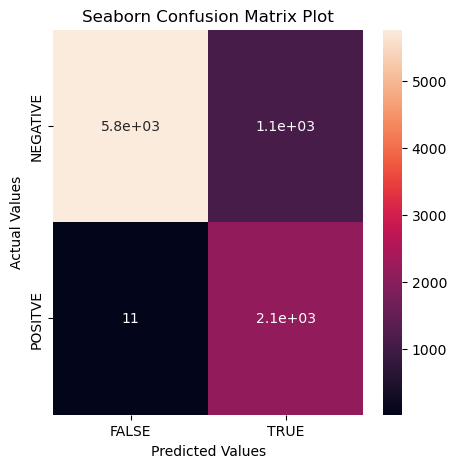







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9171
GEOMETRIC MEAN SCORE:  0.9138






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.40










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.91      0.81      0.86      6814
      Attack       0.56      0.76      0.64      2186

    accuracy                           0.80      9000
   macro avg       0.74      0.78      0.75      9000
weighted avg       0.83      0.80      0.80      9000







CONFUSION MATRIX




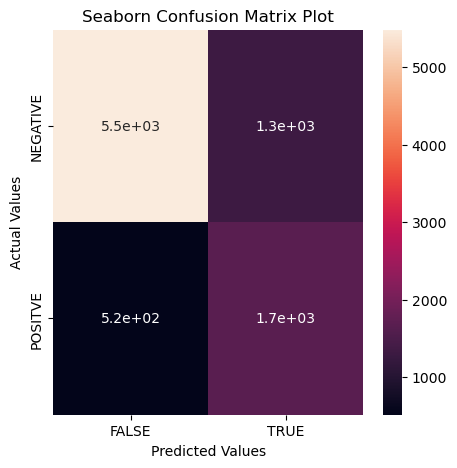







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.7843
GEOMETRIC MEAN SCORE:  0.7840






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.31








In [84]:
perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      6872
      Attack       1.00      1.00      1.00      2128

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000







CONFUSION MATRIX




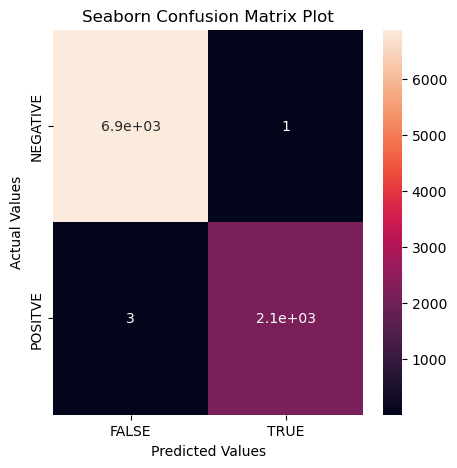







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9992
GEOMETRIC MEAN SCORE:  0.9992






TIME TAKEN TO COMPLETE MODEL ANALYSIS


1.97










ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.97      0.94      0.95      6814
      Attack       0.82      0.90      0.86      2186

    accuracy                           0.93      9000
   macro avg       0.89      0.92      0.90      9000
weighted avg       0.93      0.93      0.93      9000







CONFUSION MATRIX




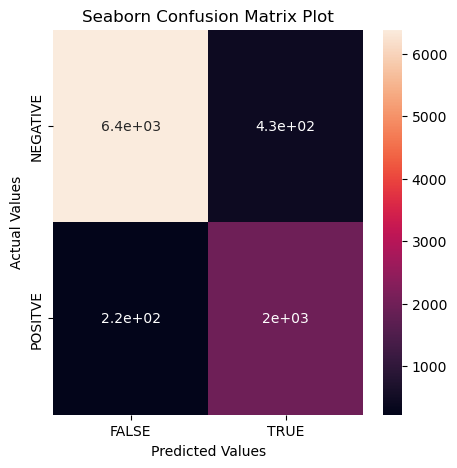







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9172
GEOMETRIC MEAN SCORE:  0.9170






TIME TAKEN TO COMPLETE MODEL ANALYSIS


81.44








In [85]:
perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      6872
      Attack       1.00      1.00      1.00      2128

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000







CONFUSION MATRIX




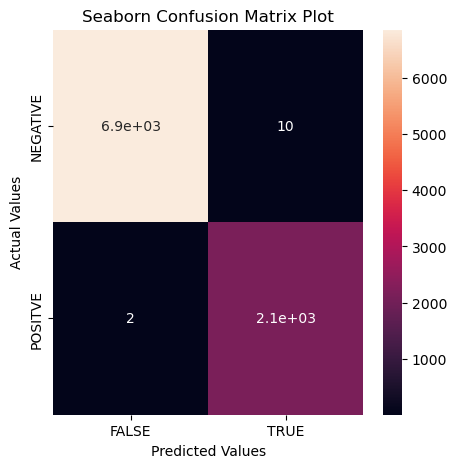







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9988
GEOMETRIC MEAN SCORE:  0.9988






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.31










ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95      6814
      Attack       0.84      0.83      0.83      2186

    accuracy                           0.92      9000
   macro avg       0.89      0.89      0.89      9000
weighted avg       0.92      0.92      0.92      9000







CONFUSION MATRIX




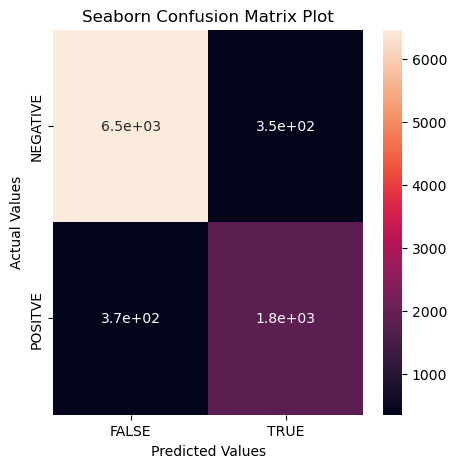







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8894
GEOMETRIC MEAN SCORE:  0.8874






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.56








In [86]:
perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      6872
      Attack       1.00      1.00      1.00      2128

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000







CONFUSION MATRIX




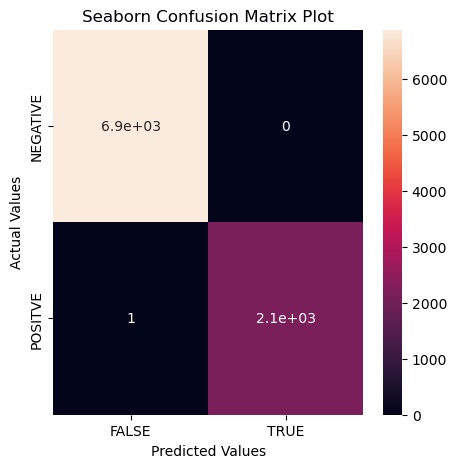







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9998
GEOMETRIC MEAN SCORE:  0.9998






TIME TAKEN TO COMPLETE MODEL ANALYSIS


0.84










ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      0.79      0.88      6814
      Attack       0.60      0.99      0.75      2186

    accuracy                           0.84      9000
   macro avg       0.80      0.89      0.81      9000
weighted avg       0.90      0.84      0.85      9000







CONFUSION MATRIX




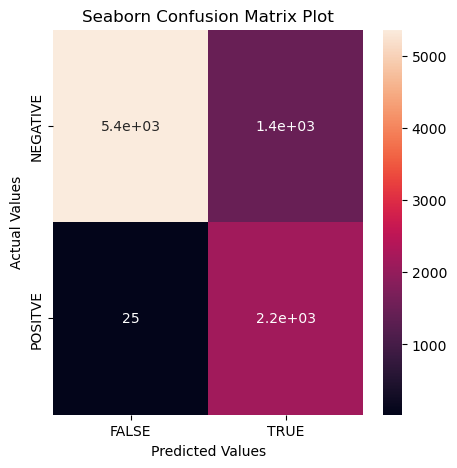







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8880
GEOMETRIC MEAN SCORE:  0.8823






TIME TAKEN TO COMPLETE MODEL ANALYSIS


2.67








In [87]:
perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 41)                1722      
                                                                 
 dense_7 (Dense)             (None, 1)                 42        
                                                                 
 dense_8 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,768
Trainable params: 1,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
546/546 [==============================] - 3s 3ms/step - loss: 0.5402 - accuracy: 0.9182
Epoch 2/10
546/546 [==============================] - 2s 3ms/step - loss: 0.3342 - accuracy: 0.9973
Epoch 3/10
546/546 [==============================] - 2s 3ms/step - loss: 0.2299 - accuracy: 0.9974
Epoch 4/10
546/5

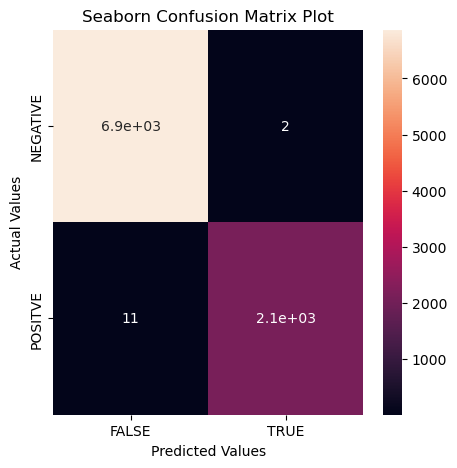







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9973
GEOMETRIC MEAN SCORE:  0.9973






TIME TAKEN TO COMPLETE MODEL ANALYSIS


21.16






Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 43)                1892      
                                                                 
 dense_10 (Dense)            (None, 1)                 44        
                                                                 
 dense_11 (Dense)            (None, 2)                 4         
                                                                 
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
547/547 [==============================] - 3s 3ms/step - loss: 0.5796 - accuracy: 0.7468
Epoch 2/10
547/547 [==============================] - 2s 3ms/step - loss

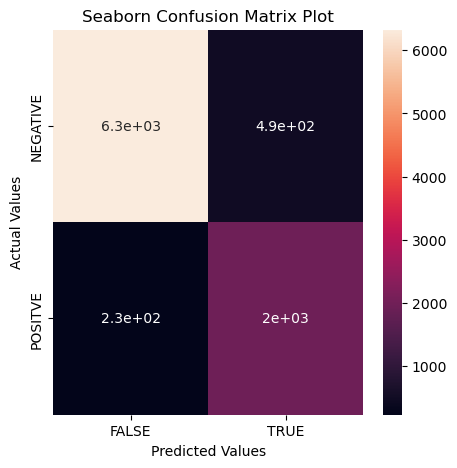







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9106
GEOMETRIC MEAN SCORE:  0.9104






TIME TAKEN TO COMPLETE MODEL ANALYSIS


21.14








In [88]:
perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment II

In [89]:
Exp_2_KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [90]:
Exp_2_UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [91]:
Exp_2_KDD_Analysis_Summary_df

AUC    G-MEAN
NBC  0.917089  0.913788
SVM  0.999222  0.999222
DTC  0.998802  0.998802
RFC  0.999765  0.999765
ANN  0.997270  0.997267

In [92]:
Exp_2_UNSWNB15_Analysis_Summary_df

AUC    G-MEAN
NBC  0.784301  0.784025
SVM  0.917212  0.917001
DTC  0.889377  0.887381
RFC  0.888030  0.882321
ANN  0.910596  0.910425

### Experiment III Setup

#### Correlation Heatmap for the two datasets

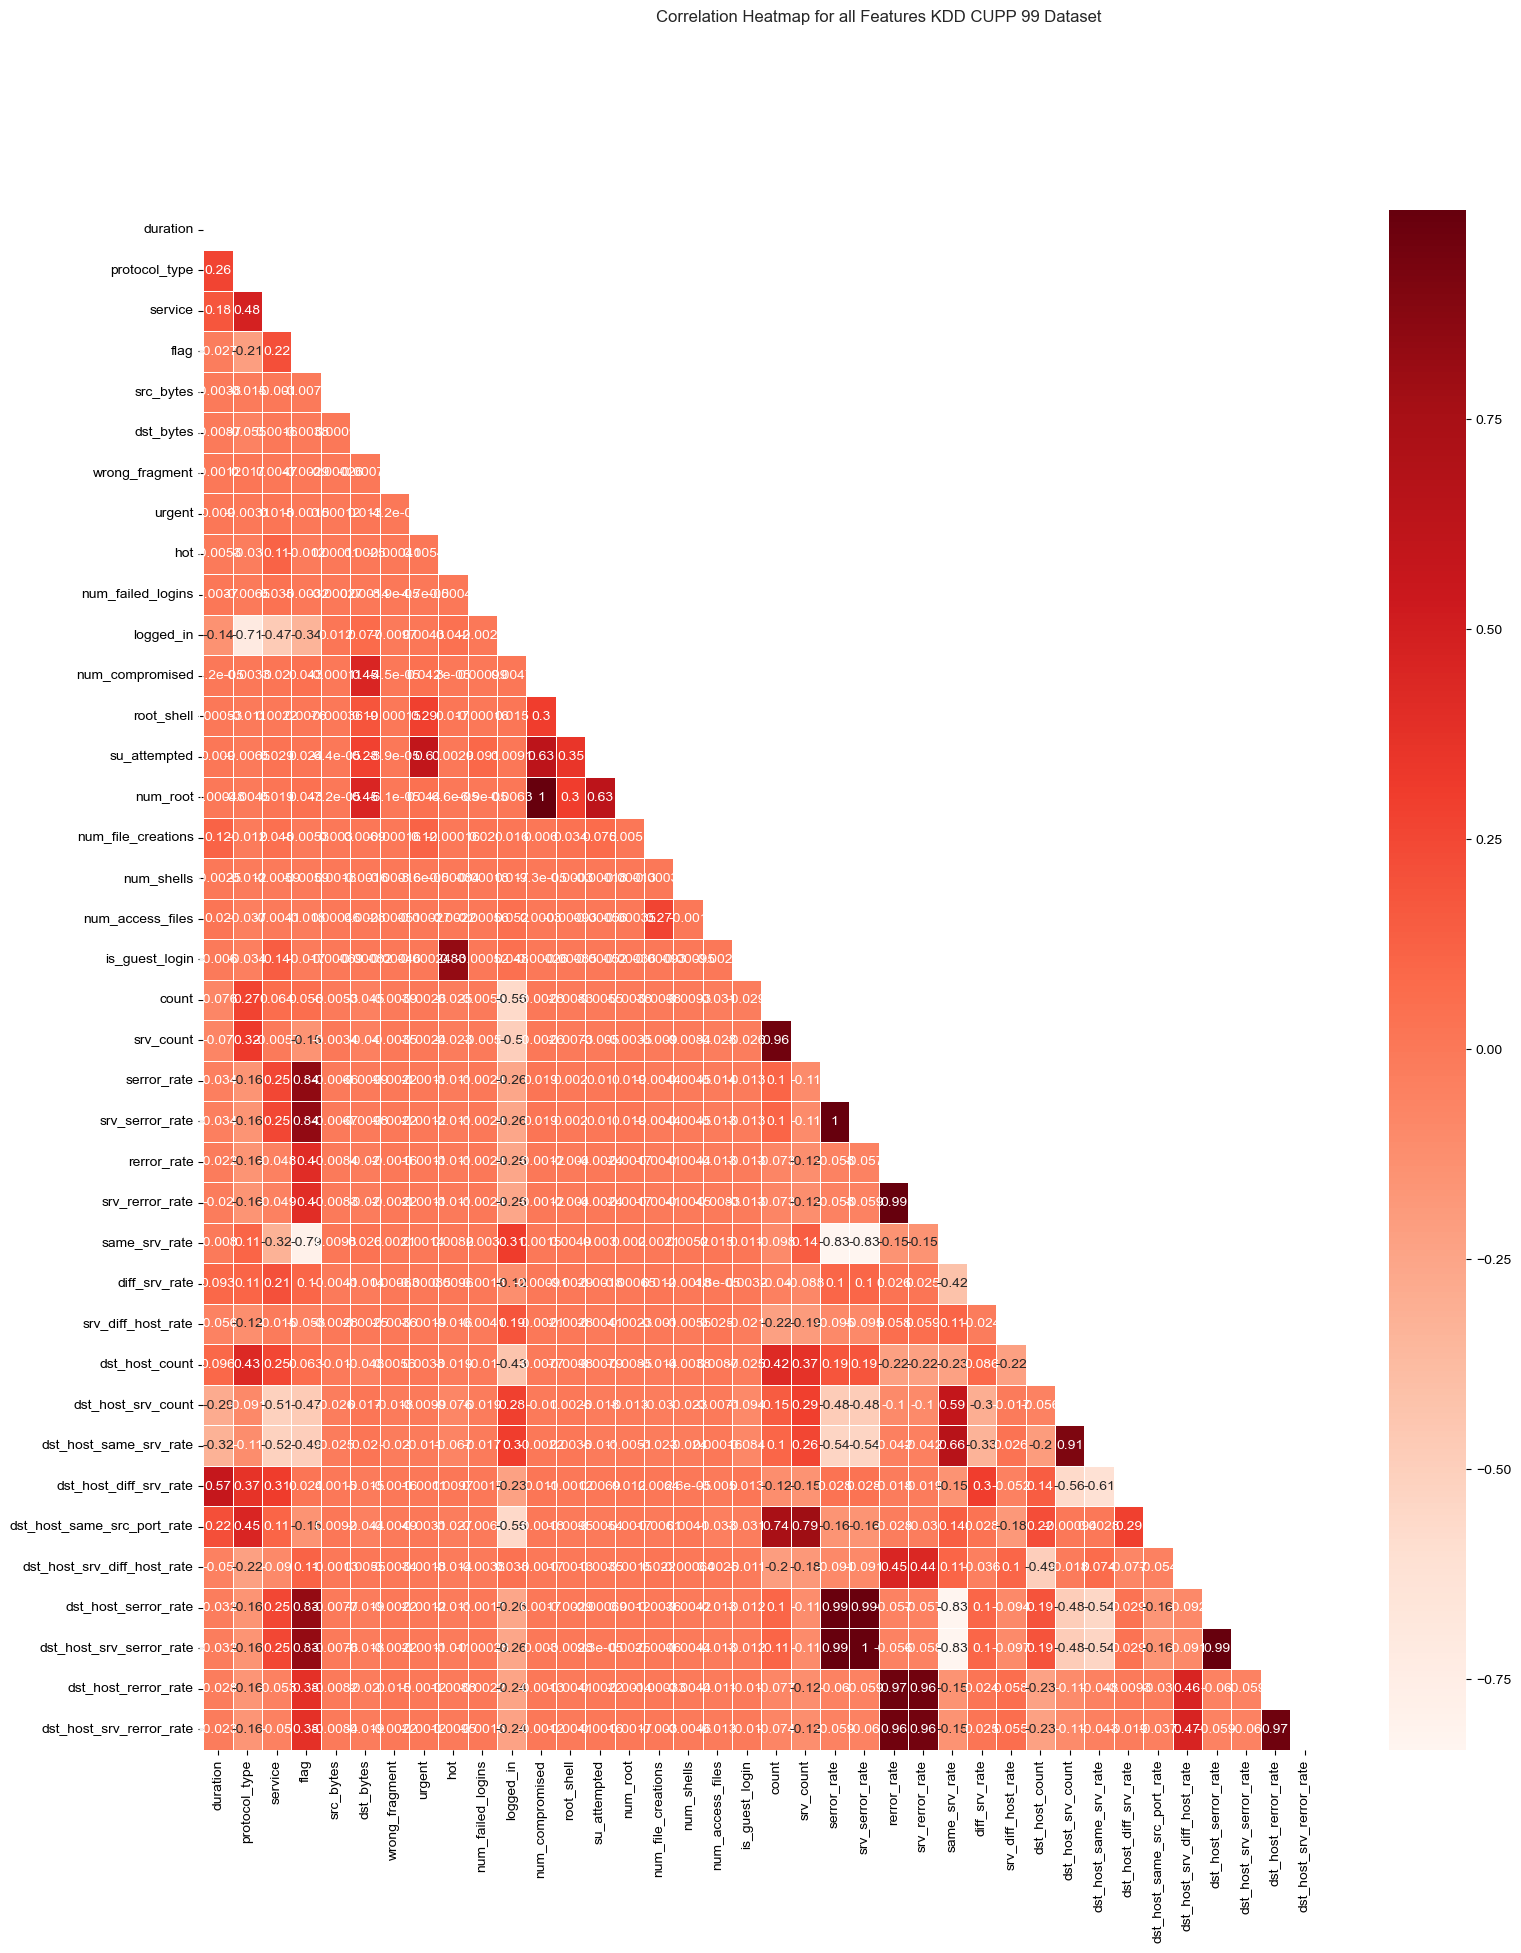

In [93]:
title = "Correlation Heatmap for all Features {} Dataset".format(dataset_label_dict[kddcup99])
show_correlation_heatmap_chart(features_kdd_cup_df, title)

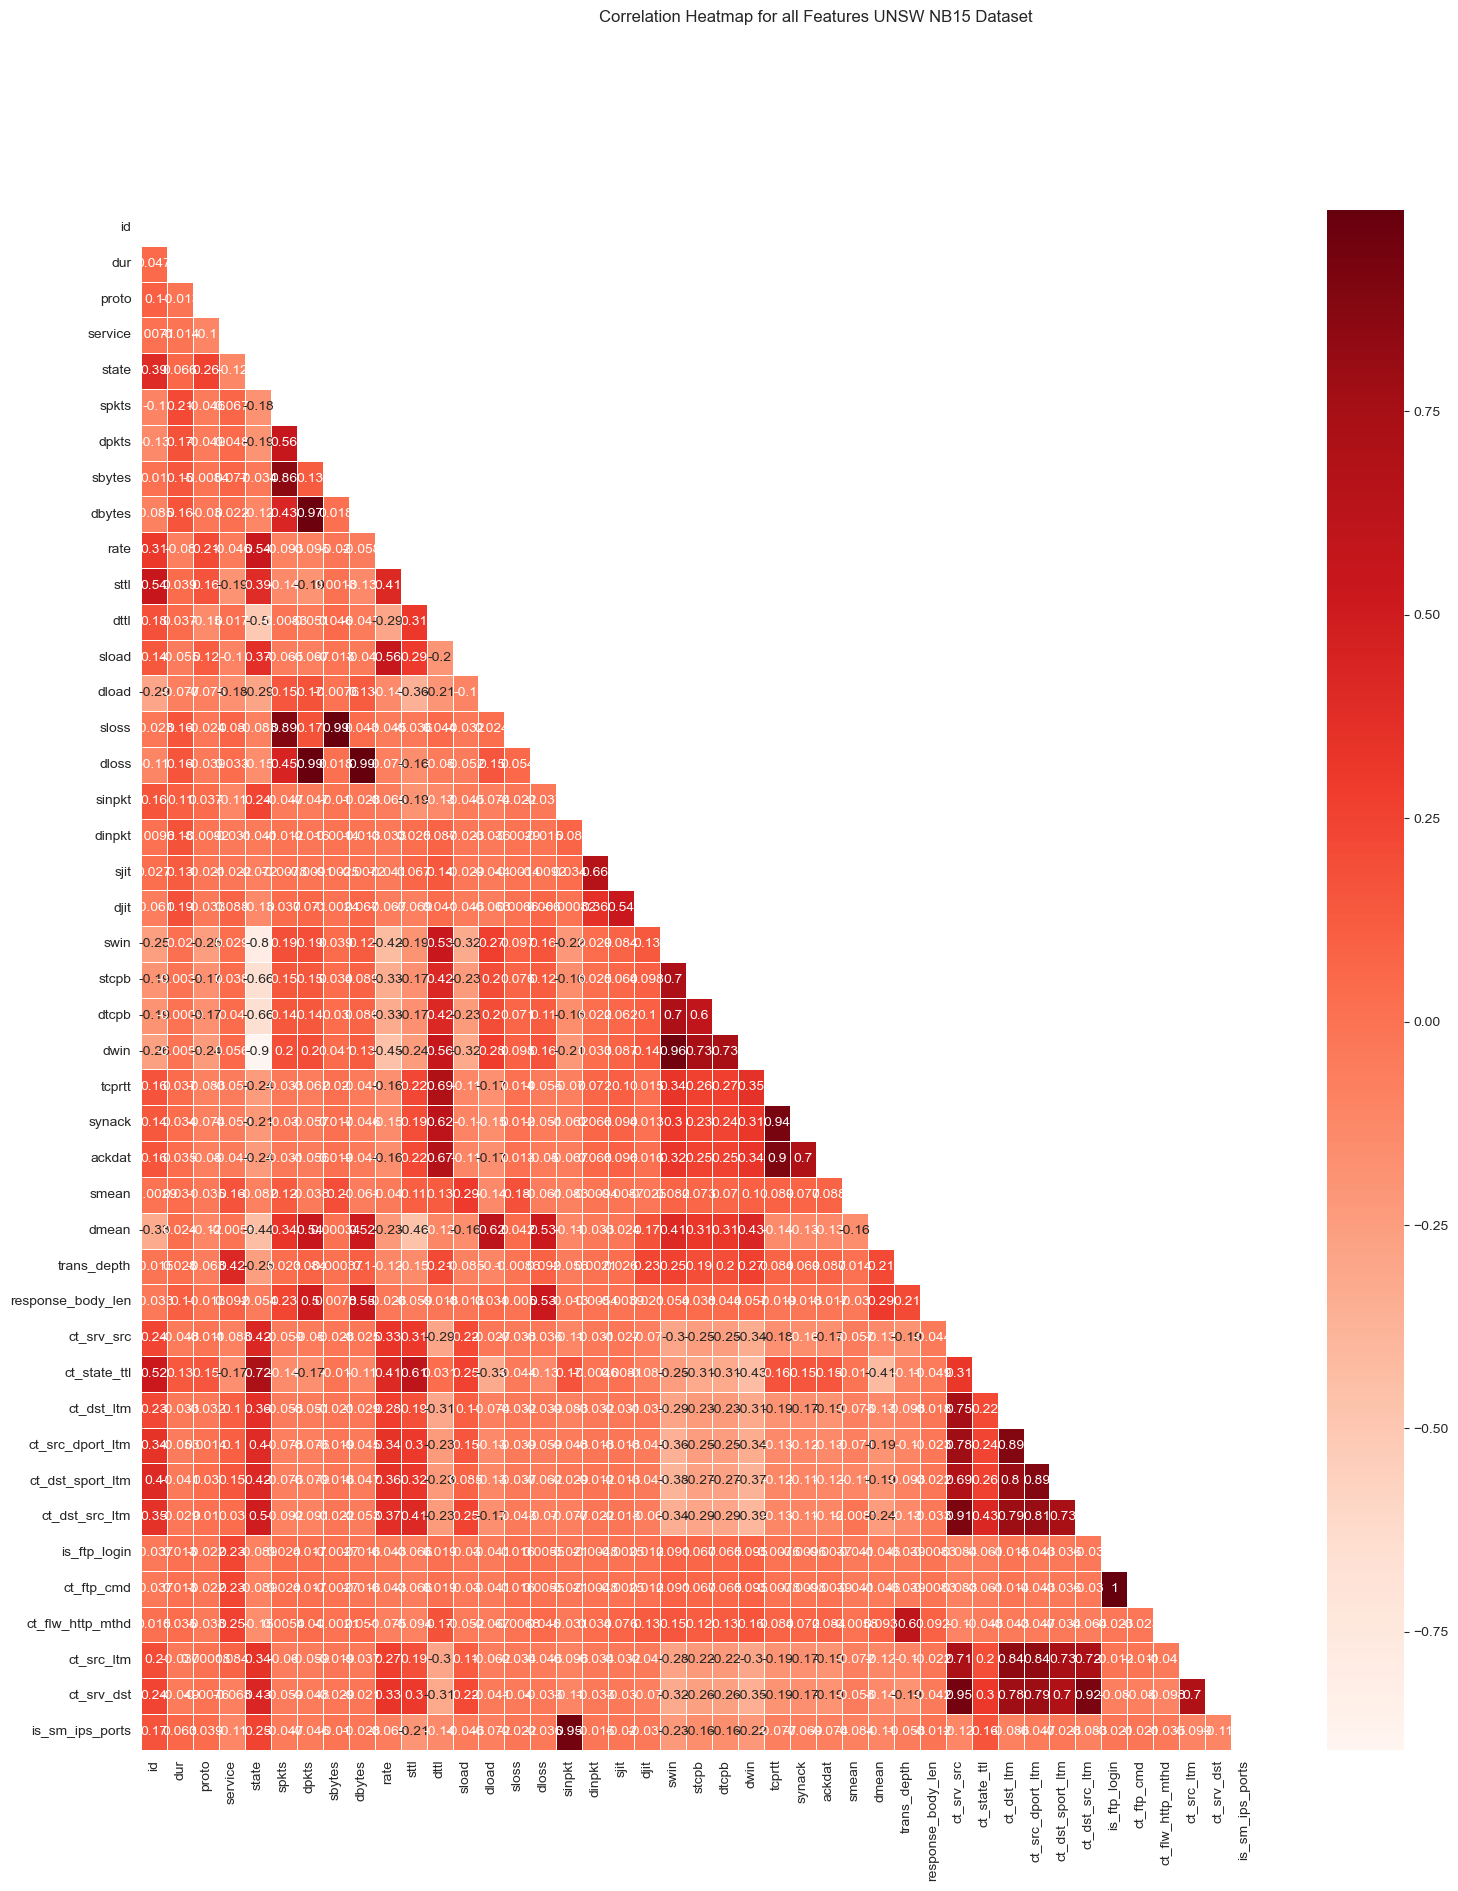

In [94]:
title = "Correlation Heatmap for all Features {} Dataset".format(dataset_label_dict[unswnb15])
show_correlation_heatmap_chart(features_unsw_nb15_df, title)

In [95]:
highly_correlation_kdd_cup_99_features = estimate_correlation_to_select_highly_correlated_features(features_kdd_cup_df, 0.90)







FEATURES WITH HIGH CORRELATION VALUES


Correlation between NUM_ROOT and NUM_COMPROMISED feature is 0.9991274138460227




Correlation between SRV_COUNT and COUNT feature is 0.9630964780524621




Correlation between SRV_SERROR_RATE and SERROR_RATE feature is 0.9973651025244439




Correlation between SRV_RERROR_RATE and RERROR_RATE feature is 0.9920196657261122




Correlation between DST_HOST_SAME_SRV_RATE and DST_HOST_SRV_COUNT feature is 0.9115965546173466




Correlation between DST_HOST_SERROR_RATE and SRV_SERROR_RATE feature is 0.9907587933465692




Correlation between DST_HOST_SRV_SERROR_RATE and DST_HOST_SERROR_RATE feature is 0.9940494706716769




Correlation between DST_HOST_RERROR_RATE and SRV_RERROR_RATE feature is 0.9625031949566027




Correlation between DST_HOST_SRV_RERROR_RATE and DST_HOST_RERROR_RATE feature is 0.9689761393748738
















In [96]:
highly_correlation_unswnb15_features = estimate_correlation_to_select_highly_correlated_features(features_unsw_nb15_df, 0.90)







FEATURES WITH HIGH CORRELATION VALUES


Correlation between DBYTES and DPKTS feature is 0.9742580028416096




Correlation between SLOSS and SBYTES feature is 0.9883564293017345




Correlation between DLOSS and DBYTES feature is 0.9936918575747624




Correlation between DWIN and SWIN feature is 0.9564967341029379




Correlation between SYNACK and TCPRTT feature is 0.936314768866353




Correlation between ACKDAT and TCPRTT feature is 0.9037030041376867




Correlation between CT_DST_SRC_LTM and CT_SRV_SRC feature is 0.9129945632477069




Correlation between CT_FTP_CMD and IS_FTP_LOGIN feature is 0.9976697602502772




Correlation between CT_SRV_DST and CT_DST_SRC_LTM feature is 0.9212908977850247




Correlation between IS_SM_IPS_PORTS and SINPKT feature is 0.9492973070456272
















In [97]:
highly_correlation_kdd_cup_99_features
features_kdd_cup_df.drop(highly_correlation_kdd_cup_99_features, axis=1,  inplace = True)

['dst_host_same_srv_rate',
 'num_root',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'srv_count',
 'dst_host_srv_rerror_rate',
 'srv_rerror_rate',
 'srv_serror_rate',
 'dst_host_serror_rate']

In [98]:
highly_correlation_unswnb15_features
features_unsw_nb15_df.drop(highly_correlation_unswnb15_features, axis=1,  inplace = True)

['ackdat',
 'dloss',
 'ct_dst_src_ltm',
 'is_sm_ips_ports',
 'ct_ftp_cmd',
 'dbytes',
 'ct_srv_dst',
 'synack',
 'dwin',
 'sloss']

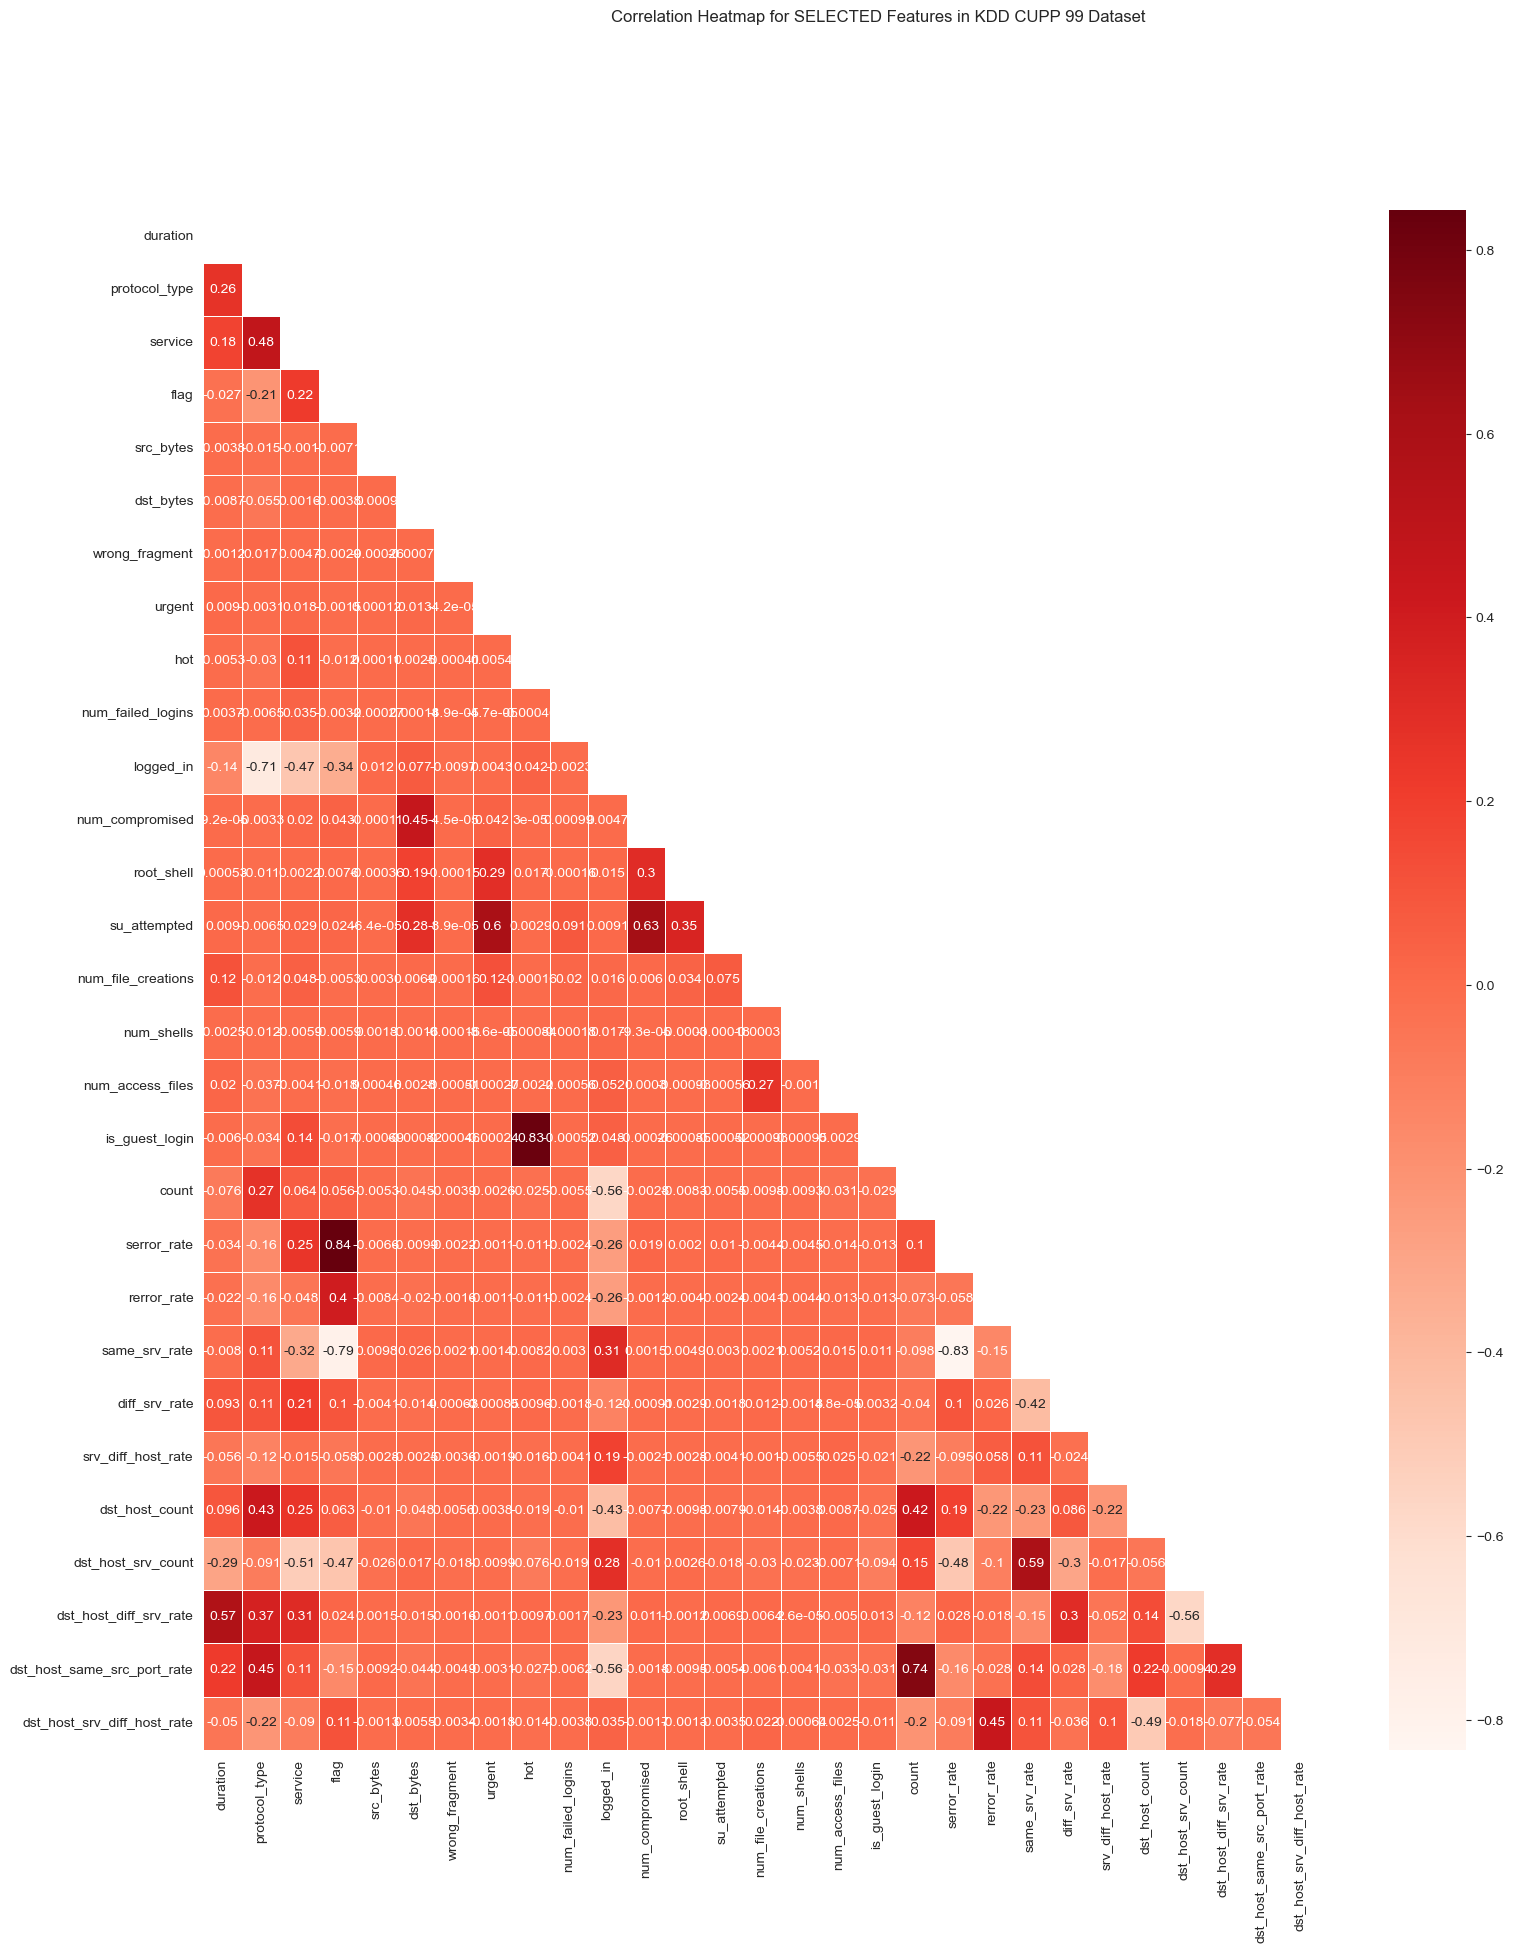

In [99]:
title = "Correlation Heatmap for SELECTED Features in {} Dataset".format(dataset_label_dict[kddcup99])
show_correlation_heatmap_chart(features_kdd_cup_df, title)

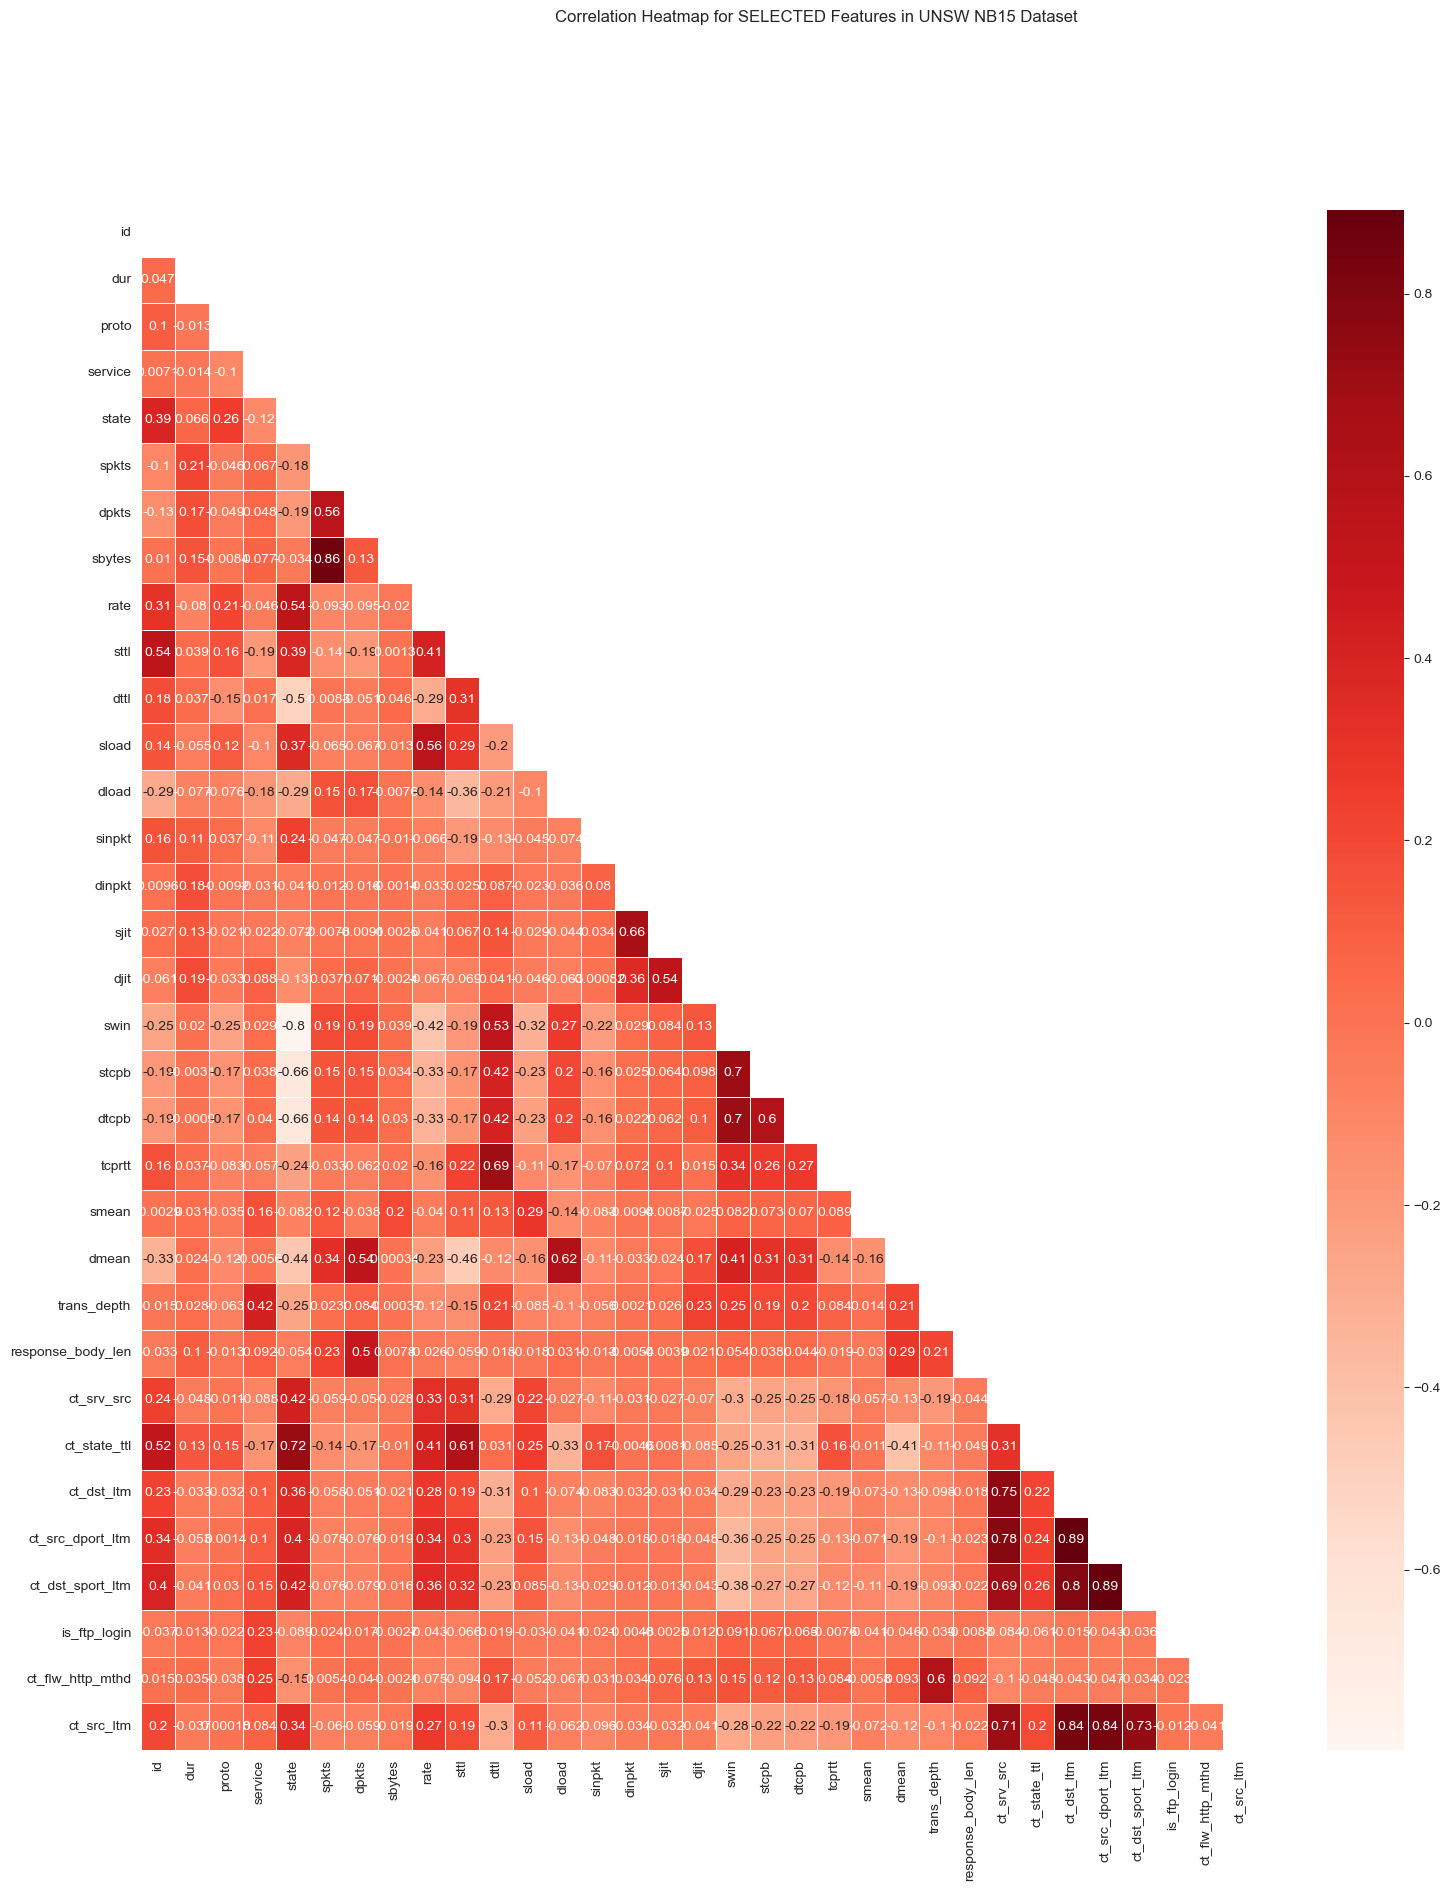

In [100]:
title = "Correlation Heatmap for SELECTED Features in {} Dataset".format(dataset_label_dict[unswnb15])
show_correlation_heatmap_chart(features_unsw_nb15_df, title)

In [101]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 42)

In [102]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 42)

In [103]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [104]:
ros = SMOTENC([1], random_state=0)
start_time = time.time()
# kddcup_X_train, kddcup_y_train = remove_imbalance_in_dataset_using_smote_technique(kddcup_X_train, kddcup_y_train)
# unsw_nb15_X_train, unsw_nb15_y_train = remove_imbalance_in_dataset_using_smote_technique(unsw_nb15_X_train, unsw_nb15_y_train)
kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)
unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)
end_time = time.time()       
print("\n")
print("\n")
print("\n")
print("TIME TAKEN TO HANDLE IMBALANCE IN DATASET FOR EXPERIMENT III")
print("=========================================================")
print("\n")
print("{:.2f}".format(end_time - start_time))
print("\n")
print("\n")
print("\n")







TIME TAKEN TO HANDLE IMBALANCE IN DATASET FOR EXPERIMENT III


112.28








In [105]:
print(kddcup_y_train.agg(['nunique','count','size']))
print("\n")
print(kddcup_y_train[kddcup_y_train == 0].count())
print("\n")
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique        2
count      54588
size       54588
Name: traffic_type, dtype: int64


27294


27294


In [106]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print("\n")
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print("\n")
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique        2
count      54628
size       54628
Name: traffic_type, dtype: int64


27314


27314


In [107]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment III

In [108]:
experiment_type = "EXPERIMENT-THREE"





ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      6872
      Attack       0.97      0.99      0.98      2128

    accuracy                           0.99      9000
   macro avg       0.98      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000







CONFUSION MATRIX




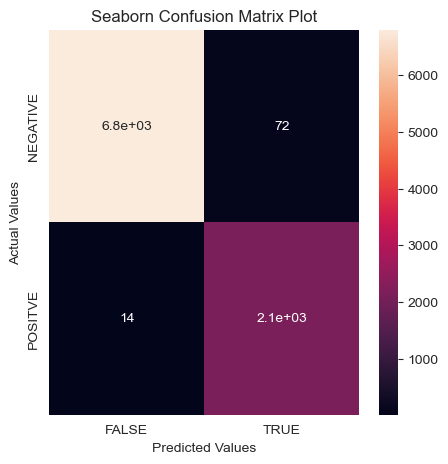







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9915
GEOMETRIC MEAN SCORE:  0.9915






TIME TAKEN TO COMPLETE MODEL ANALYSIS


18.48










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.90      0.91      0.91      6814
      Attack       0.72      0.70      0.71      2186

    accuracy                           0.86      9000
   macro avg       0.81      0.81      0.81      9000
weighted avg       0.86      0.86      0.86      9000







CONFUSION MATRIX




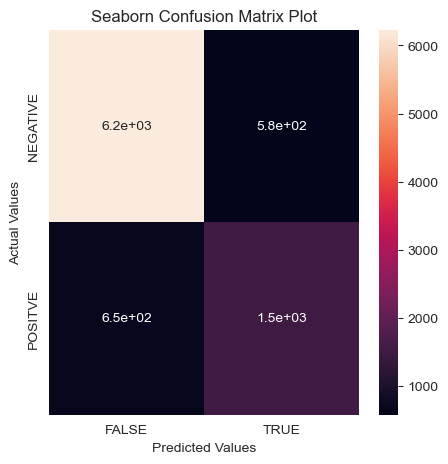







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.8076
GEOMETRIC MEAN SCORE:  0.8005






TIME TAKEN TO COMPLETE MODEL ANALYSIS


14.23








In [109]:
hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      6872
      Attack       0.99      1.00      1.00      2128

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000







CONFUSION MATRIX




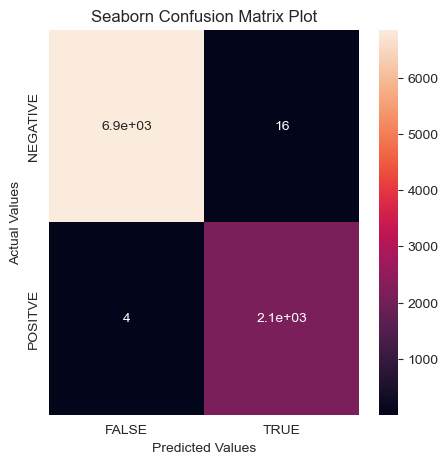







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9979
GEOMETRIC MEAN SCORE:  0.9979






TIME TAKEN TO COMPLETE MODEL ANALYSIS


995.27










ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.89      0.97      0.92      6814
      Attack       0.86      0.61      0.71      2186

    accuracy                           0.88      9000
   macro avg       0.87      0.79      0.82      9000
weighted avg       0.88      0.88      0.87      9000







CONFUSION MATRIX




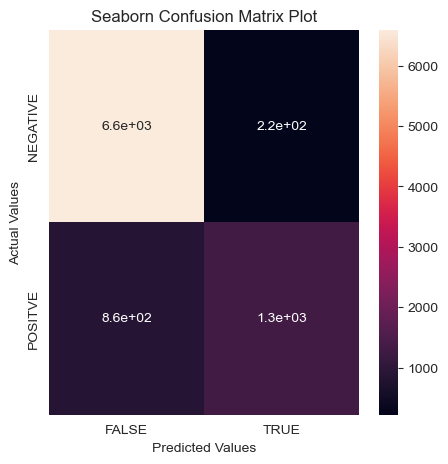







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.7880
GEOMETRIC MEAN SCORE:  0.7671






TIME TAKEN TO COMPLETE MODEL ANALYSIS


5072.93








In [110]:
hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      6872
      Attack       1.00      1.00      1.00      2128

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000







CONFUSION MATRIX




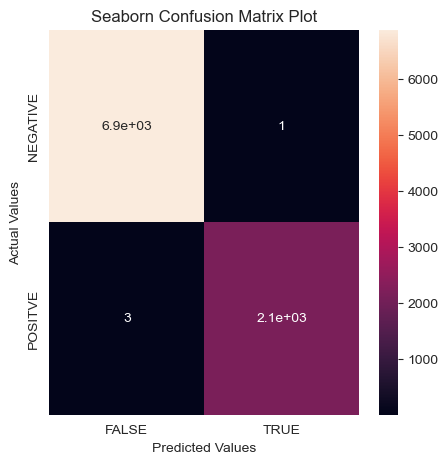







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9992
GEOMETRIC MEAN SCORE:  0.9992






TIME TAKEN TO COMPLETE MODEL ANALYSIS


126.30










ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.99      0.87      0.93      6814
      Attack       0.71      0.96      0.82      2186

    accuracy                           0.89      9000
   macro avg       0.85      0.92      0.87      9000
weighted avg       0.92      0.89      0.90      9000







CONFUSION MATRIX




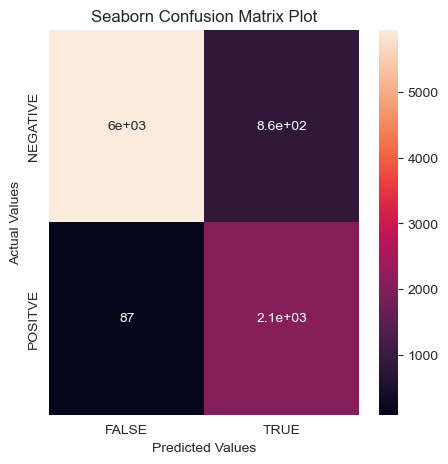







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9168
GEOMETRIC MEAN SCORE:  0.9157






TIME TAKEN TO COMPLETE MODEL ANALYSIS


283.86








In [111]:
hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)





ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      6872
      Attack       1.00      1.00      1.00      2128

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000







CONFUSION MATRIX




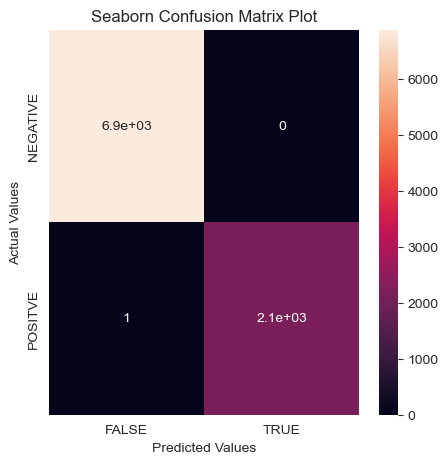







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9998
GEOMETRIC MEAN SCORE:  0.9998






TIME TAKEN TO COMPLETE MODEL ANALYSIS


115.62










ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET




CLASSIFICTION REPORT


              precision    recall  f1-score   support

      Normal       0.99      0.87      0.93      6814
      Attack       0.71      0.98      0.82      2186

    accuracy                           0.90      9000
   macro avg       0.85      0.93      0.87      9000
weighted avg       0.92      0.90      0.90      9000







CONFUSION MATRIX




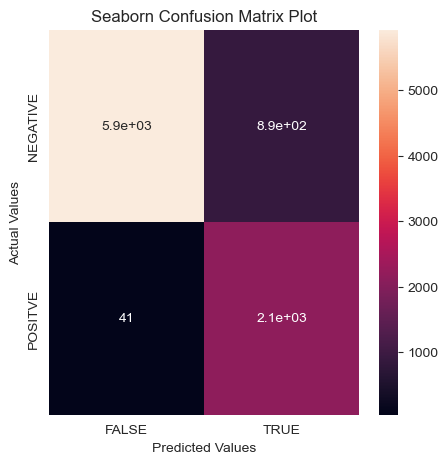







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9255
GEOMETRIC MEAN SCORE:  0.9239






TIME TAKEN TO COMPLETE MODEL ANALYSIS


363.66








In [112]:
hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
 dense_14 (Dense)            (None, 2)                 4         
                                                                 
Total params: 1,093
Trainable params: 1,093
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2730/2730 [==============================] - 9s 3ms/step - loss: 0.2422 - accuracy: 0.9664
Epoch 2/100
2730/2730 [==============================] - 8s 3ms/step - loss: 0.0528 - accuracy: 0.9975
Epoch 3/100
2730/2730 [==============================] - 8s 3ms/step - loss: 0.0236 - accuracy: 0.9975
Epoch 4

2730/2730 [==============================] - 8s 3ms/step - loss: 0.0121 - accuracy: 0.9981
Epoch 73/100
2730/2730 [==============================] - 8s 3ms/step - loss: 0.0119 - accuracy: 0.9980
Epoch 74/100
2730/2730 [==============================] - 8s 3ms/step - loss: 0.0117 - accuracy: 0.9981
Epoch 75/100
2730/2730 [==============================] - 8s 3ms/step - loss: 0.0116 - accuracy: 0.9981
Epoch 76/100
2730/2730 [==============================] - 8s 3ms/step - loss: 0.0114 - accuracy: 0.9981
Epoch 77/100
2730/2730 [==============================] - 8s 3ms/step - loss: 0.0113 - accuracy: 0.9981
Epoch 78/100
2730/2730 [==============================] - 8s 3ms/step - loss: 0.0112 - accuracy: 0.9981
Epoch 79/100
2730/2730 [==============================] - 8s 3ms/step - loss: 0.0112 - accuracy: 0.9982
Epoch 80/100
2730/2730 [==============================] - 8s 3ms/step - loss: 0.0111 - accuracy: 0.9982
Epoch 81/100
2730/2730 [==============================] - 8s 3ms/step - loss:

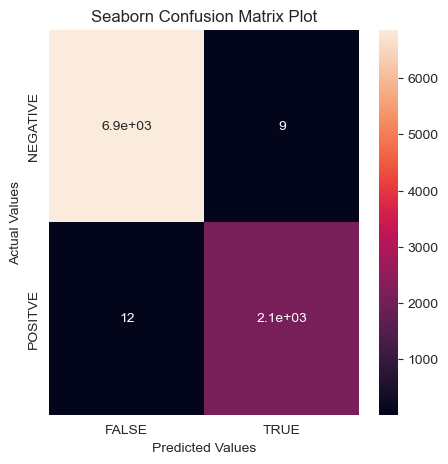







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9965
GEOMETRIC MEAN SCORE:  0.9965






TIME TAKEN TO COMPLETE MODEL ANALYSIS


2432.30






Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 33)                1122      
                                                                 
 dense_16 (Dense)            (None, 1)                 34        
                                                                 
 dense_17 (Dense)            (None, 2)                 4         
                                                                 
Total params: 1,160
Trainable params: 1,160
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2732/2732 [==============================] - 9s 3ms/step - loss: 0.4117 - accuracy: 0.8445
Epoch 2/100
2732/2732 [==============================] - 8s 3ms/ste

2732/2732 [==============================] - 8s 3ms/step - loss: 0.1305 - accuracy: 0.9416
Epoch 70/100
2732/2732 [==============================] - 8s 3ms/step - loss: 0.1297 - accuracy: 0.9424
Epoch 71/100
2732/2732 [==============================] - 8s 3ms/step - loss: 0.1288 - accuracy: 0.9422
Epoch 72/100
2732/2732 [==============================] - 8s 3ms/step - loss: 0.1281 - accuracy: 0.9421
Epoch 73/100
2732/2732 [==============================] - 8s 3ms/step - loss: 0.1272 - accuracy: 0.9425
Epoch 74/100
2732/2732 [==============================] - 8s 3ms/step - loss: 0.1264 - accuracy: 0.9437
Epoch 75/100
2732/2732 [==============================] - 8s 3ms/step - loss: 0.1244 - accuracy: 0.9447
Epoch 76/100
2732/2732 [==============================] - 8s 3ms/step - loss: 0.1233 - accuracy: 0.9448
Epoch 77/100
2732/2732 [==============================] - 8s 3ms/step - loss: 0.1220 - accuracy: 0.9462
Epoch 78/100
2732/2732 [==============================] - 8s 3ms/step - loss:

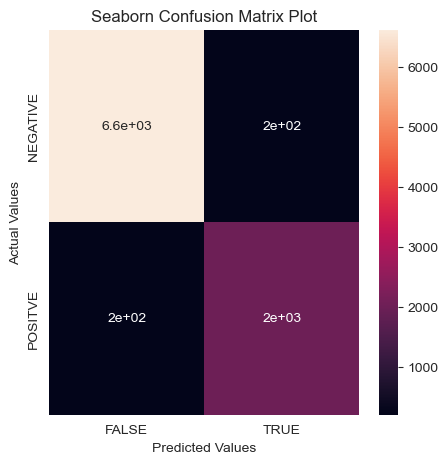







MODEL PERFORMANCE EVALUATION


AUC SCORE:  0.9392
GEOMETRIC MEAN SCORE:  0.9387






TIME TAKEN TO COMPLETE MODEL ANALYSIS


2422.58








In [113]:
hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment III

In [114]:
Exp_3_KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [115]:
Exp_3_UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [116]:
Exp_3_KDD_Analysis_Summary_df

AUC    G-MEAN
NBC  0.991472  0.991470
SVM  0.997896  0.997896
DTC  0.999222  0.999222
RFC  0.999765  0.999765
ANN  0.996526  0.996523

In [117]:
Exp_3_UNSWNB15_Analysis_Summary_df

AUC    G-MEAN
NBC  0.807559  0.800474
SVM  0.787983  0.767144
DTC  0.916775  0.915746
RFC  0.925536  0.923857
ANN  0.939195  0.938663